In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv("train_BRCpofr_yY5tzKr.csv")

In [3]:
test=pd.read_csv("test_koRSKBP_Ua94SFA.csv")

In [4]:
id=test['id']

In [5]:
df.isnull().sum()

id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv              0
dtype: int64

In [6]:
df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


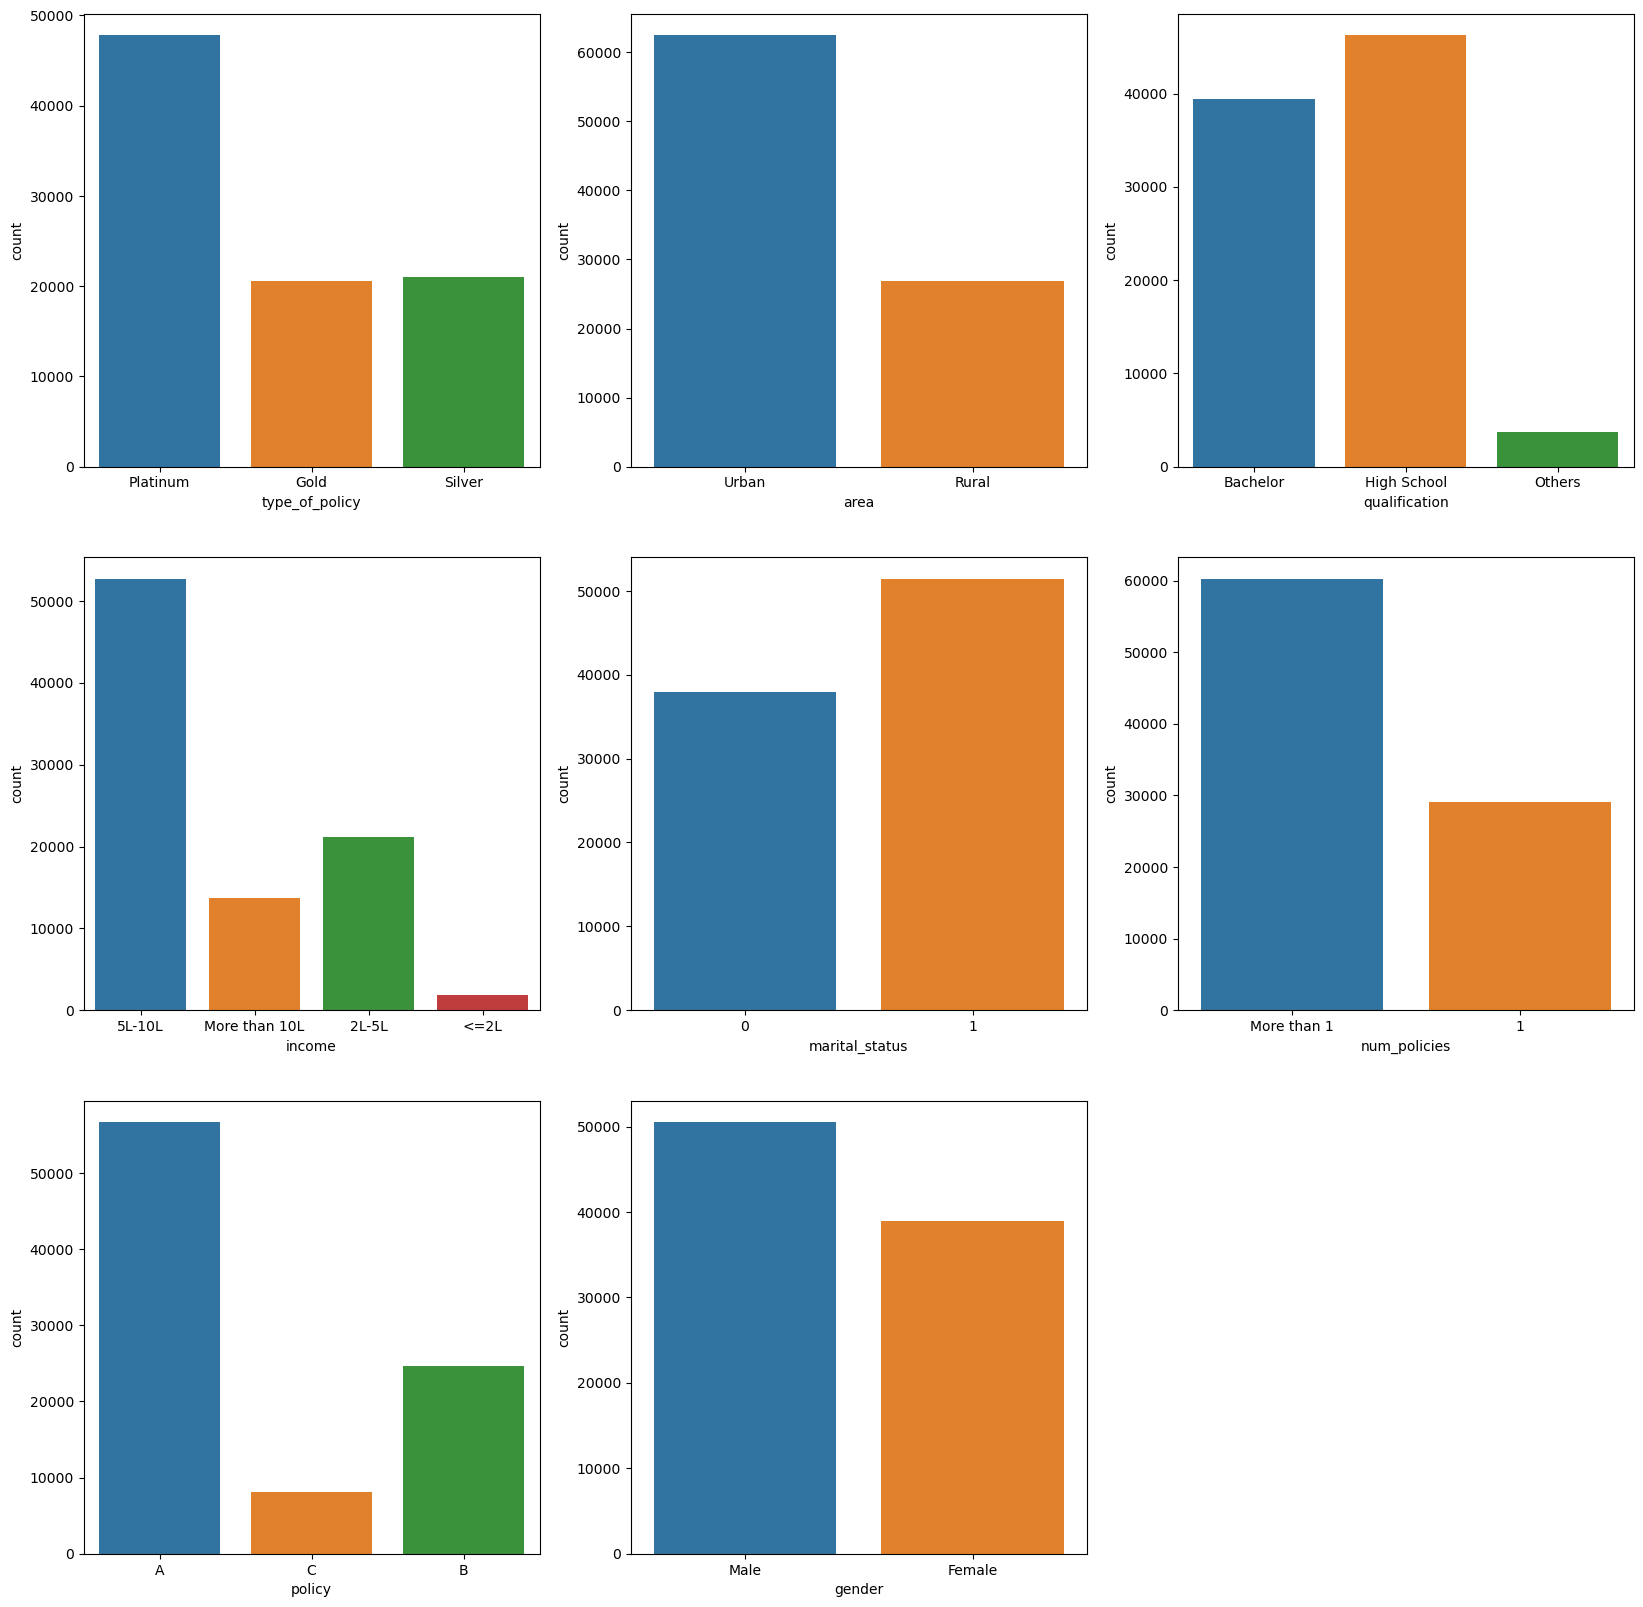

In [7]:
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
sns.countplot(x=df['type_of_policy'])

plt.subplot(3,3,2)
sns.countplot(x=df['area'])

plt.subplot(3,3,3)
sns.countplot(x=df['qualification'])

plt.subplot(3,3,4)
sns.countplot(x=df['income'])

plt.subplot(3,3,5)
sns.countplot(x=df['marital_status'])

plt.subplot(3,3,6)
sns.countplot(x=df['num_policies'])

plt.subplot(3,3,7)
sns.countplot(x=df['policy'])

plt.subplot(3,3,8)
sns.countplot(x=df['gender'])

plt.show()

C:\Users\Nino\AppData\Local\Temp\ipykernel_16592\3405530207.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df['claim_amount'])


<Axes: ylabel='Density'>

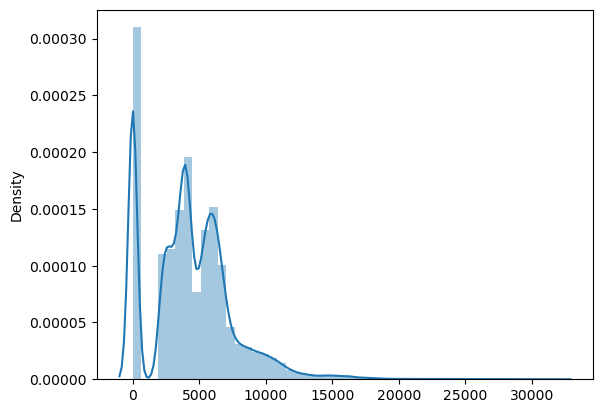

In [8]:
sns.distplot(x=df['claim_amount'])

Right Skewness is in the claim density function Using log on claim amount is advised 

In [9]:
def data_transform(data):
    ### Ordinal Encoding
    
    data['area']=data['area'].map({'Urban':2, 'Rural':1})
    
    data['income']=data['income'].map({'5L-10L':2, 'More than 10L':1, '2L-5L':3, '<=2L':4})
    
    data['num_policies']=data['num_policies'].map({'More than 1':2, '1':1})

    
    ### One Hot Encoding
    
    data=pd.get_dummies(data,columns=['type_of_policy','qualification','policy','gender'])
    
    ### logging claim amount values
    
    data['claim_amount']=np.log2(data['claim_amount']+1)
    
    return data

data=data_transform(data=df)
data.head()

,id,area,income,marital_status,vintage,claim_amount,num_policies,cltv,type_of_policy_Gold,type_of_policy_Platinum,type_of_policy_Silver,qualification_Bachelor,qualification_High School,qualification_Others,policy_A,policy_B,policy_C,gender_Female,gender_Male
0,1,2,2,1,5,12.499597,2,64308,0,1,0,1,0,0,1,0,0,0,1
1,2,1,2,0,8,12.310897,2,515400,0,1,0,0,1,0,1,0,0,0,1
2,3,2,2,1,8,11.344296,2,64212,0,1,0,1,0,0,1,0,0,0,1
3,4,1,2,0,7,0.000000,2,97920,0,1,0,0,1,0,1,0,0,1,0
4,5,2,1,1,6,11.776844,2,59736,1,0,0,0,1,0,1,0,0,0,1


In [10]:
x = data.drop(columns=['id','cltv'])
y = data['cltv']

In [11]:
y.head()

0     64308
1    515400
2     64212
3     97920
4     59736
Name: cltv, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=84)

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
gbr1=GradientBoostingRegressor()
gbr1.fit(x_train,y_train)
ypred1=gbr1.predict(x_test)
print(" r2 score ",r2_score(y_test,ypred1))

 r2 score  0.1724478983875829


### Hypr Parameter Tuning

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_depth=3,max_features='sqrt',learning_rate=0.075,n_estimators=250,random_state=84)

gbr.fit(x_train,y_train)

ypred2 = gbr.predict(x_test)

print(" r2 score ",r2_score(y_test,ypred2))

 r2 score  0.17256781368820184


Grid search CV or Random search CV and other algorithms can also be used to perform a more accurate Hyper parameter tuning

In [15]:
import catboost as cb

model = cb.CatBoostRegressor(loss_function='RMSE', eval_metric='R2')

In [16]:
train_dataset = cb.Pool(x_train, y_train) 
test_dataset = cb.Pool(x_test, y_test)

In [17]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: -1.0969393	test: -1.0967228	best: -1.0967228 (0)	total: 137ms	remaining: 13.5s
1:	learn: -1.0237889	test: -1.0225414	best: -1.0225414 (1)	total: 141ms	remaining: 6.92s
2:	learn: -0.9550315	test: -0.9528276	best: -0.9528276 (2)	total: 145ms	remaining: 4.69s
3:	learn: -0.8908674	test: -0.8878265	best: -0.8878265 (3)	total: 153ms	remaining: 3.66s
4:	learn: -0.8304725	test: -0.8266837	best: -0.8266837 (4)	total: 160ms	remaining: 3.04s
5:	learn: -0.7729574	test: -0.7686257	best: -0.7686257 (5)	total: 167ms	remaining: 2.61s
6:	learn: -0.7188985	test: -0.7139082	best: -0.7139082 (6)	total: 172ms	remaining: 2.28s
7:	learn: -0.6680344	test: -0.6624552	best: -0.6624552 (7)	total: 177ms	remaining: 2.04s
8:	learn: -0.6207186	test: -0.6146579	best: -0.6146579 (8)	total: 182ms	remaining: 1.84s
9:	learn: -0.5761216	test: -0.5696461	best: -0.5696461 (9)	total: 188ms	remaining: 1.69s
10:	learn: -0.5335273	test: -0.5267387	best: -0.5267387 (10)	total: 193ms	remaining: 1.56s
11:	learn: -0.49411

7:	learn: -0.1025567	test: -0.0940202	best: -0.0940202 (7)	total: 37.1ms	remaining: 427ms
8:	learn: -0.0551056	test: -0.0470037	best: -0.0470037 (8)	total: 41ms	remaining: 415ms
9:	learn: -0.0177657	test: -0.0101229	best: -0.0101229 (9)	total: 44.5ms	remaining: 400ms
10:	learn: 0.0137059	test: 0.0206314	best: 0.0206314 (10)	total: 48.1ms	remaining: 389ms
11:	learn: 0.0381016	test: 0.0445374	best: 0.0445374 (11)	total: 52ms	remaining: 381ms
12:	learn: 0.0582986	test: 0.0641980	best: 0.0641980 (12)	total: 58.6ms	remaining: 392ms
13:	learn: 0.0753977	test: 0.0805875	best: 0.0805875 (13)	total: 63.1ms	remaining: 388ms
14:	learn: 0.0893561	test: 0.0940872	best: 0.0940872 (14)	total: 68.2ms	remaining: 387ms
15:	learn: 0.1007063	test: 0.1048951	best: 0.1048951 (15)	total: 72.2ms	remaining: 379ms
16:	learn: 0.1099802	test: 0.1136828	best: 0.1136828 (16)	total: 77.2ms	remaining: 377ms
17:	learn: 0.1174522	test: 0.1207558	best: 0.1207558 (17)	total: 82.2ms	remaining: 374ms
18:	learn: 0.1229924	t

12:	learn: -0.4568775	test: -0.4494819	best: -0.4494819 (12)	total: 53.8ms	remaining: 360ms
13:	learn: -0.4214227	test: -0.4139968	best: -0.4139968 (13)	total: 57.4ms	remaining: 353ms
14:	learn: -0.3879416	test: -0.3803676	best: -0.3803676 (14)	total: 60.6ms	remaining: 343ms
15:	learn: -0.3569825	test: -0.3492414	best: -0.3492414 (15)	total: 64.5ms	remaining: 338ms
16:	learn: -0.3273193	test: -0.3195024	best: -0.3195024 (16)	total: 69.1ms	remaining: 337ms
17:	learn: -0.2994798	test: -0.2915115	best: -0.2915115 (17)	total: 73ms	remaining: 332ms
18:	learn: -0.2736500	test: -0.2655150	best: -0.2655150 (18)	total: 76.1ms	remaining: 324ms
19:	learn: -0.2494388	test: -0.2412372	best: -0.2412372 (19)	total: 79.6ms	remaining: 318ms
20:	learn: -0.2261095	test: -0.2179225	best: -0.2179225 (20)	total: 82.9ms	remaining: 312ms
21:	learn: -0.2041417	test: -0.1959970	best: -0.1959970 (21)	total: 85.8ms	remaining: 304ms
22:	learn: -0.1839733	test: -0.1758223	best: -0.1758223 (22)	total: 88.9ms	remaini

23:	learn: 0.1407121	test: 0.1423297	best: 0.1423297 (23)	total: 86.5ms	remaining: 274ms
24:	learn: 0.1426412	test: 0.1439930	best: 0.1439930 (24)	total: 91ms	remaining: 273ms
25:	learn: 0.1442574	test: 0.1453724	best: 0.1453724 (25)	total: 93.9ms	remaining: 267ms
26:	learn: 0.1457201	test: 0.1466536	best: 0.1466536 (26)	total: 96.8ms	remaining: 262ms
27:	learn: 0.1468862	test: 0.1476856	best: 0.1476856 (27)	total: 101ms	remaining: 260ms
28:	learn: 0.1478431	test: 0.1485215	best: 0.1485215 (28)	total: 105ms	remaining: 258ms
29:	learn: 0.1486803	test: 0.1492637	best: 0.1492637 (29)	total: 109ms	remaining: 255ms
30:	learn: 0.1494673	test: 0.1499640	best: 0.1499640 (30)	total: 114ms	remaining: 254ms
31:	learn: 0.1500253	test: 0.1504243	best: 0.1504243 (31)	total: 117ms	remaining: 249ms
32:	learn: 0.1505599	test: 0.1510226	best: 0.1510226 (32)	total: 120ms	remaining: 244ms
33:	learn: 0.1510408	test: 0.1515232	best: 0.1515232 (33)	total: 123ms	remaining: 240ms
34:	learn: 0.1514947	test: 0.1

34:	learn: -0.0139009	test: -0.0069810	best: -0.0069810 (34)	total: 111ms	remaining: 207ms
35:	learn: -0.0047646	test: 0.0020336	best: 0.0020336 (35)	total: 115ms	remaining: 205ms
36:	learn: 0.0041373	test: 0.0108547	best: 0.0108547 (36)	total: 119ms	remaining: 203ms
37:	learn: 0.0126103	test: 0.0191470	best: 0.0191470 (37)	total: 123ms	remaining: 201ms
38:	learn: 0.0205847	test: 0.0269735	best: 0.0269735 (38)	total: 129ms	remaining: 202ms
39:	learn: 0.0281104	test: 0.0343487	best: 0.0343487 (39)	total: 132ms	remaining: 198ms
40:	learn: 0.0351589	test: 0.0412800	best: 0.0412800 (40)	total: 135ms	remaining: 195ms
41:	learn: 0.0415602	test: 0.0475533	best: 0.0475533 (41)	total: 138ms	remaining: 191ms
42:	learn: 0.0477586	test: 0.0536116	best: 0.0536116 (42)	total: 142ms	remaining: 188ms
43:	learn: 0.0536605	test: 0.0593593	best: 0.0593593 (43)	total: 145ms	remaining: 185ms
44:	learn: 0.0592472	test: 0.0647773	best: 0.0647773 (44)	total: 148ms	remaining: 181ms
45:	learn: 0.0643942	test: 0

45:	learn: 0.1541056	test: 0.1542601	best: 0.1542601 (45)	total: 151ms	remaining: 177ms
46:	learn: 0.1542751	test: 0.1544912	best: 0.1544912 (46)	total: 155ms	remaining: 175ms
47:	learn: 0.1544020	test: 0.1545581	best: 0.1545581 (47)	total: 159ms	remaining: 172ms
48:	learn: 0.1544979	test: 0.1547227	best: 0.1547227 (48)	total: 163ms	remaining: 170ms
49:	learn: 0.1545670	test: 0.1547715	best: 0.1547715 (49)	total: 168ms	remaining: 168ms
50:	learn: 0.1546308	test: 0.1548683	best: 0.1548683 (50)	total: 172ms	remaining: 165ms
51:	learn: 0.1547132	test: 0.1549887	best: 0.1549887 (51)	total: 178ms	remaining: 164ms
52:	learn: 0.1547921	test: 0.1550257	best: 0.1550257 (52)	total: 183ms	remaining: 162ms
53:	learn: 0.1548669	test: 0.1550893	best: 0.1550893 (53)	total: 187ms	remaining: 160ms
54:	learn: 0.1549150	test: 0.1551174	best: 0.1551174 (54)	total: 192ms	remaining: 157ms
55:	learn: 0.1549865	test: 0.1551925	best: 0.1551925 (55)	total: 196ms	remaining: 154ms
56:	learn: 0.1550596	test: 0.155

54:	learn: 0.0989785	test: 0.1032736	best: 0.1032736 (54)	total: 209ms	remaining: 171ms
55:	learn: 0.1019609	test: 0.1061331	best: 0.1061331 (55)	total: 213ms	remaining: 167ms
56:	learn: 0.1045668	test: 0.1086665	best: 0.1086665 (56)	total: 216ms	remaining: 163ms
57:	learn: 0.1071958	test: 0.1111654	best: 0.1111654 (57)	total: 219ms	remaining: 159ms
58:	learn: 0.1096967	test: 0.1135539	best: 0.1135539 (58)	total: 223ms	remaining: 155ms
59:	learn: 0.1120718	test: 0.1158187	best: 0.1158187 (59)	total: 228ms	remaining: 152ms
60:	learn: 0.1143065	test: 0.1179441	best: 0.1179441 (60)	total: 236ms	remaining: 151ms
61:	learn: 0.1163987	test: 0.1199372	best: 0.1199372 (61)	total: 243ms	remaining: 149ms
62:	learn: 0.1183740	test: 0.1217988	best: 0.1217988 (62)	total: 249ms	remaining: 146ms
63:	learn: 0.1202474	test: 0.1235680	best: 0.1235680 (63)	total: 253ms	remaining: 142ms
64:	learn: 0.1219711	test: 0.1251862	best: 0.1251862 (64)	total: 256ms	remaining: 138ms
65:	learn: 0.1234521	test: 0.126

61:	learn: 0.1554126	test: 0.1555655	best: 0.1555655 (61)	total: 227ms	remaining: 139ms
62:	learn: 0.1554493	test: 0.1556085	best: 0.1556085 (62)	total: 231ms	remaining: 136ms
63:	learn: 0.1554831	test: 0.1556547	best: 0.1556547 (63)	total: 234ms	remaining: 132ms
64:	learn: 0.1555228	test: 0.1557200	best: 0.1557200 (64)	total: 238ms	remaining: 128ms
65:	learn: 0.1555611	test: 0.1557976	best: 0.1557976 (65)	total: 242ms	remaining: 125ms
66:	learn: 0.1556338	test: 0.1558351	best: 0.1558351 (66)	total: 246ms	remaining: 121ms
67:	learn: 0.1556612	test: 0.1558218	best: 0.1558351 (66)	total: 250ms	remaining: 117ms
68:	learn: 0.1557023	test: 0.1557859	best: 0.1558351 (66)	total: 254ms	remaining: 114ms
69:	learn: 0.1557892	test: 0.1558857	best: 0.1558857 (69)	total: 258ms	remaining: 111ms
70:	learn: 0.1558365	test: 0.1559155	best: 0.1559155 (70)	total: 262ms	remaining: 107ms
71:	learn: 0.1558740	test: 0.1559402	best: 0.1559402 (71)	total: 266ms	remaining: 103ms
72:	learn: 0.1559280	test: 0.155

59:	learn: 0.1120945	test: 0.1158405	best: 0.1158405 (59)	total: 271ms	remaining: 406ms
60:	learn: 0.1143283	test: 0.1179650	best: 0.1179650 (60)	total: 275ms	remaining: 401ms
61:	learn: 0.1164197	test: 0.1199572	best: 0.1199572 (61)	total: 278ms	remaining: 395ms
62:	learn: 0.1183940	test: 0.1218179	best: 0.1218179 (62)	total: 282ms	remaining: 390ms
63:	learn: 0.1202667	test: 0.1235864	best: 0.1235864 (63)	total: 286ms	remaining: 384ms
64:	learn: 0.1219895	test: 0.1252037	best: 0.1252037 (64)	total: 289ms	remaining: 379ms
65:	learn: 0.1234698	test: 0.1265986	best: 0.1265986 (65)	total: 293ms	remaining: 373ms
66:	learn: 0.1250324	test: 0.1280579	best: 0.1280579 (66)	total: 297ms	remaining: 368ms
67:	learn: 0.1265261	test: 0.1294543	best: 0.1294543 (67)	total: 301ms	remaining: 363ms
68:	learn: 0.1279459	test: 0.1307681	best: 0.1307681 (68)	total: 305ms	remaining: 358ms
69:	learn: 0.1291826	test: 0.1318906	best: 0.1318906 (69)	total: 309ms	remaining: 353ms
70:	learn: 0.1304194	test: 0.133

4:	learn: -0.3196045	test: -0.3113447	best: -0.3113447 (4)	total: 18.7ms	remaining: 542ms
5:	learn: -0.2315921	test: -0.2229762	best: -0.2229762 (5)	total: 23ms	remaining: 551ms
6:	learn: -0.1603019	test: -0.1516195	best: -0.1516195 (6)	total: 26.2ms	remaining: 536ms
7:	learn: -0.1025567	test: -0.0940202	best: -0.0940202 (7)	total: 30ms	remaining: 533ms
8:	learn: -0.0551056	test: -0.0470037	best: -0.0470037 (8)	total: 35ms	remaining: 548ms
9:	learn: -0.0177657	test: -0.0101229	best: -0.0101229 (9)	total: 38.3ms	remaining: 537ms
10:	learn: 0.0137059	test: 0.0206314	best: 0.0206314 (10)	total: 41.5ms	remaining: 524ms
11:	learn: 0.0381016	test: 0.0445374	best: 0.0445374 (11)	total: 45.4ms	remaining: 523ms
12:	learn: 0.0582986	test: 0.0641980	best: 0.0641980 (12)	total: 50.8ms	remaining: 535ms
13:	learn: 0.0753977	test: 0.0805875	best: 0.0805875 (13)	total: 55ms	remaining: 535ms
14:	learn: 0.0893561	test: 0.0940872	best: 0.0940872 (14)	total: 59.5ms	remaining: 536ms
15:	learn: 0.1007063	te

108:	learn: 0.1570625	test: 0.1570609	best: 0.1570609 (108)	total: 419ms	remaining: 157ms
109:	learn: 0.1570982	test: 0.1570664	best: 0.1570664 (109)	total: 423ms	remaining: 154ms
110:	learn: 0.1571180	test: 0.1570750	best: 0.1570750 (110)	total: 426ms	remaining: 150ms
111:	learn: 0.1571469	test: 0.1570766	best: 0.1570766 (111)	total: 430ms	remaining: 146ms
112:	learn: 0.1571842	test: 0.1571579	best: 0.1571579 (112)	total: 433ms	remaining: 142ms
113:	learn: 0.1572145	test: 0.1572274	best: 0.1572274 (113)	total: 438ms	remaining: 138ms
114:	learn: 0.1572379	test: 0.1572261	best: 0.1572274 (113)	total: 441ms	remaining: 134ms
115:	learn: 0.1572538	test: 0.1572298	best: 0.1572298 (115)	total: 444ms	remaining: 130ms
116:	learn: 0.1572853	test: 0.1572747	best: 0.1572747 (116)	total: 447ms	remaining: 126ms
117:	learn: 0.1573092	test: 0.1573030	best: 0.1573030 (117)	total: 451ms	remaining: 122ms
118:	learn: 0.1573361	test: 0.1572950	best: 0.1573030 (117)	total: 456ms	remaining: 119ms
119:	learn

54:	learn: 0.0990028	test: 0.1032968	best: 0.1032968 (54)	total: 224ms	remaining: 387ms
55:	learn: 0.1019842	test: 0.1061553	best: 0.1061553 (55)	total: 228ms	remaining: 384ms
56:	learn: 0.1045898	test: 0.1086885	best: 0.1086885 (56)	total: 232ms	remaining: 378ms
57:	learn: 0.1072178	test: 0.1111865	best: 0.1111865 (57)	total: 236ms	remaining: 374ms
58:	learn: 0.1097179	test: 0.1135742	best: 0.1135742 (58)	total: 239ms	remaining: 369ms
59:	learn: 0.1120921	test: 0.1158381	best: 0.1158381 (59)	total: 243ms	remaining: 364ms
60:	learn: 0.1143260	test: 0.1179628	best: 0.1179628 (60)	total: 247ms	remaining: 360ms
61:	learn: 0.1164175	test: 0.1199551	best: 0.1199551 (61)	total: 251ms	remaining: 357ms
62:	learn: 0.1183919	test: 0.1218159	best: 0.1218159 (62)	total: 256ms	remaining: 353ms
63:	learn: 0.1202646	test: 0.1235844	best: 0.1235844 (63)	total: 259ms	remaining: 349ms
64:	learn: 0.1219875	test: 0.1252019	best: 0.1252019 (64)	total: 263ms	remaining: 344ms
65:	learn: 0.1234679	test: 0.126

33:	learn: 0.1510408	test: 0.1515232	best: 0.1515232 (33)	total: 130ms	remaining: 444ms
34:	learn: 0.1514947	test: 0.1518862	best: 0.1518862 (34)	total: 135ms	remaining: 442ms
35:	learn: 0.1519055	test: 0.1522142	best: 0.1522142 (35)	total: 138ms	remaining: 437ms
36:	learn: 0.1522128	test: 0.1525622	best: 0.1525622 (36)	total: 141ms	remaining: 432ms
37:	learn: 0.1525106	test: 0.1529264	best: 0.1529264 (37)	total: 145ms	remaining: 426ms
38:	learn: 0.1527937	test: 0.1531438	best: 0.1531438 (38)	total: 148ms	remaining: 422ms
39:	learn: 0.1530727	test: 0.1533912	best: 0.1533912 (39)	total: 151ms	remaining: 416ms
40:	learn: 0.1532429	test: 0.1535106	best: 0.1535106 (40)	total: 155ms	remaining: 413ms
41:	learn: 0.1534294	test: 0.1536656	best: 0.1536656 (41)	total: 160ms	remaining: 411ms
42:	learn: 0.1536625	test: 0.1539593	best: 0.1539593 (42)	total: 164ms	remaining: 407ms
43:	learn: 0.1538449	test: 0.1540805	best: 0.1540805 (43)	total: 167ms	remaining: 402ms
44:	learn: 0.1539644	test: 0.154

142:	learn: 0.1578684	test: 0.1575233	best: 0.1575233 (142)	total: 530ms	remaining: 25.9ms
143:	learn: 0.1578850	test: 0.1574960	best: 0.1575233 (142)	total: 534ms	remaining: 22.2ms
144:	learn: 0.1579022	test: 0.1574898	best: 0.1575233 (142)	total: 537ms	remaining: 18.5ms
145:	learn: 0.1579186	test: 0.1574825	best: 0.1575233 (142)	total: 540ms	remaining: 14.8ms
146:	learn: 0.1579341	test: 0.1574865	best: 0.1575233 (142)	total: 543ms	remaining: 11.1ms
147:	learn: 0.1579453	test: 0.1574911	best: 0.1575233 (142)	total: 547ms	remaining: 7.39ms
148:	learn: 0.1579619	test: 0.1574870	best: 0.1575233 (142)	total: 550ms	remaining: 3.69ms
149:	learn: 0.1579792	test: 0.1575180	best: 0.1575233 (142)	total: 554ms	remaining: 0us

bestTest = 0.1575232528
bestIteration = 142

11:	loss: 0.1575233	best: 0.1575236 (9)	total: 5.82s	remaining: 40.7s
0:	learn: -1.0969428	test: -1.0967264	best: -1.0967264 (0)	total: 3.39ms	remaining: 505ms
1:	learn: -1.0237953	test: -1.0225479	best: -1.0225479 (1)	total: 6.1

107:	learn: 0.1497973	test: 0.1504038	best: 0.1504038 (107)	total: 366ms	remaining: 142ms
108:	learn: 0.1499717	test: 0.1505437	best: 0.1505437 (108)	total: 370ms	remaining: 139ms
109:	learn: 0.1501847	test: 0.1507336	best: 0.1507336 (109)	total: 373ms	remaining: 135ms
110:	learn: 0.1503394	test: 0.1508637	best: 0.1508637 (110)	total: 376ms	remaining: 132ms
111:	learn: 0.1504963	test: 0.1510332	best: 0.1510332 (111)	total: 379ms	remaining: 129ms
112:	learn: 0.1506606	test: 0.1511584	best: 0.1511584 (112)	total: 382ms	remaining: 125ms
113:	learn: 0.1508346	test: 0.1513399	best: 0.1513399 (113)	total: 385ms	remaining: 122ms
114:	learn: 0.1509634	test: 0.1514474	best: 0.1514474 (114)	total: 388ms	remaining: 118ms
115:	learn: 0.1511151	test: 0.1515608	best: 0.1515608 (115)	total: 391ms	remaining: 115ms
116:	learn: 0.1512790	test: 0.1517072	best: 0.1517072 (116)	total: 394ms	remaining: 111ms
117:	learn: 0.1514107	test: 0.1518217	best: 0.1518217 (117)	total: 398ms	remaining: 108ms
118:	learn

68:	learn: 0.1557034	test: 0.1557869	best: 0.1558362 (66)	total: 244ms	remaining: 286ms
69:	learn: 0.1557902	test: 0.1558868	best: 0.1558868 (69)	total: 248ms	remaining: 283ms
70:	learn: 0.1558375	test: 0.1559166	best: 0.1559166 (70)	total: 251ms	remaining: 279ms
71:	learn: 0.1558750	test: 0.1559413	best: 0.1559413 (71)	total: 255ms	remaining: 276ms
72:	learn: 0.1559291	test: 0.1559659	best: 0.1559659 (72)	total: 258ms	remaining: 272ms
73:	learn: 0.1559699	test: 0.1560183	best: 0.1560183 (73)	total: 261ms	remaining: 269ms
74:	learn: 0.1559985	test: 0.1560992	best: 0.1560992 (74)	total: 265ms	remaining: 265ms
75:	learn: 0.1560210	test: 0.1561564	best: 0.1561564 (75)	total: 269ms	remaining: 262ms
76:	learn: 0.1560428	test: 0.1561902	best: 0.1561902 (76)	total: 272ms	remaining: 258ms
77:	learn: 0.1560822	test: 0.1562200	best: 0.1562200 (77)	total: 275ms	remaining: 254ms
78:	learn: 0.1561004	test: 0.1562412	best: 0.1562412 (78)	total: 278ms	remaining: 250ms
79:	learn: 0.1561641	test: 0.156

26:	learn: -0.1139135	test: -0.1060021	best: -0.1060021 (26)	total: 94.8ms	remaining: 432ms
27:	learn: -0.0990403	test: -0.0911957	best: -0.0911957 (27)	total: 98.5ms	remaining: 429ms
28:	learn: -0.0846020	test: -0.0769322	best: -0.0769322 (28)	total: 102ms	remaining: 426ms
29:	learn: -0.0710321	test: -0.0635249	best: -0.0635249 (29)	total: 107ms	remaining: 429ms
30:	learn: -0.0582188	test: -0.0507793	best: -0.0507793 (30)	total: 112ms	remaining: 430ms
31:	learn: -0.0461626	test: -0.0388009	best: -0.0388009 (31)	total: 116ms	remaining: 428ms
32:	learn: -0.0347582	test: -0.0275680	best: -0.0275680 (32)	total: 119ms	remaining: 422ms
33:	learn: -0.0240138	test: -0.0169974	best: -0.0169974 (33)	total: 122ms	remaining: 417ms
34:	learn: -0.0139402	test: -0.0070196	best: -0.0070196 (34)	total: 126ms	remaining: 415ms
35:	learn: -0.0048027	test: 0.0019962	best: 0.0019962 (35)	total: 129ms	remaining: 409ms
36:	learn: 0.0041005	test: 0.0108186	best: 0.0108186 (36)	total: 132ms	remaining: 404ms
37

140:	learn: 0.1533313	test: 0.1534341	best: 0.1534341 (140)	total: 496ms	remaining: 31.7ms
141:	learn: 0.1533918	test: 0.1535108	best: 0.1535108 (141)	total: 501ms	remaining: 28.2ms
142:	learn: 0.1534742	test: 0.1535878	best: 0.1535878 (142)	total: 506ms	remaining: 24.8ms
143:	learn: 0.1535371	test: 0.1536556	best: 0.1536556 (143)	total: 511ms	remaining: 21.3ms
144:	learn: 0.1535961	test: 0.1537224	best: 0.1537224 (144)	total: 518ms	remaining: 17.9ms
145:	learn: 0.1536676	test: 0.1537803	best: 0.1537803 (145)	total: 523ms	remaining: 14.3ms
146:	learn: 0.1537128	test: 0.1538314	best: 0.1538314 (146)	total: 526ms	remaining: 10.7ms
147:	learn: 0.1537555	test: 0.1538797	best: 0.1538797 (147)	total: 530ms	remaining: 7.16ms
148:	learn: 0.1538041	test: 0.1539079	best: 0.1539079 (148)	total: 533ms	remaining: 3.58ms
149:	learn: 0.1538730	test: 0.1539729	best: 0.1539729 (149)	total: 536ms	remaining: 0us

bestTest = 0.1539729102
bestIteration = 149

14:	loss: 0.1539729	best: 0.1575236 (9)	total: 

99:	learn: 0.1568590	test: 0.1568033	best: 0.1568033 (99)	total: 353ms	remaining: 176ms
100:	learn: 0.1568812	test: 0.1568289	best: 0.1568289 (100)	total: 357ms	remaining: 173ms
101:	learn: 0.1568925	test: 0.1568366	best: 0.1568366 (101)	total: 361ms	remaining: 170ms
102:	learn: 0.1569019	test: 0.1568679	best: 0.1568679 (102)	total: 367ms	remaining: 167ms
103:	learn: 0.1569219	test: 0.1568853	best: 0.1568853 (103)	total: 372ms	remaining: 164ms
104:	learn: 0.1569374	test: 0.1569232	best: 0.1569232 (104)	total: 376ms	remaining: 161ms
105:	learn: 0.1569552	test: 0.1569340	best: 0.1569340 (105)	total: 380ms	remaining: 158ms
106:	learn: 0.1570015	test: 0.1570299	best: 0.1570299 (106)	total: 384ms	remaining: 154ms
107:	learn: 0.1570316	test: 0.1570303	best: 0.1570303 (107)	total: 389ms	remaining: 151ms
108:	learn: 0.1570609	test: 0.1570596	best: 0.1570596 (108)	total: 394ms	remaining: 148ms
109:	learn: 0.1570965	test: 0.1570650	best: 0.1570650 (109)	total: 399ms	remaining: 145ms
110:	learn: 

56:	learn: 0.1045925	test: 0.1086911	best: 0.1086911 (56)	total: 212ms	remaining: 531ms
57:	learn: 0.1072205	test: 0.1111891	best: 0.1111891 (57)	total: 215ms	remaining: 527ms
58:	learn: 0.1097204	test: 0.1135766	best: 0.1135766 (58)	total: 219ms	remaining: 523ms
59:	learn: 0.1120945	test: 0.1158405	best: 0.1158405 (59)	total: 223ms	remaining: 519ms
60:	learn: 0.1143283	test: 0.1179650	best: 0.1179650 (60)	total: 226ms	remaining: 515ms
61:	learn: 0.1164197	test: 0.1199572	best: 0.1199572 (61)	total: 231ms	remaining: 515ms
62:	learn: 0.1183940	test: 0.1218179	best: 0.1218179 (62)	total: 235ms	remaining: 511ms
63:	learn: 0.1202667	test: 0.1235864	best: 0.1235864 (63)	total: 240ms	remaining: 510ms
64:	learn: 0.1219895	test: 0.1252037	best: 0.1252037 (64)	total: 245ms	remaining: 509ms
65:	learn: 0.1234698	test: 0.1265986	best: 0.1265986 (65)	total: 249ms	remaining: 505ms
66:	learn: 0.1250324	test: 0.1280579	best: 0.1280579 (66)	total: 255ms	remaining: 505ms
67:	learn: 0.1265261	test: 0.129

156:	learn: 0.1542093	test: 0.1543436	best: 0.1543436 (156)	total: 613ms	remaining: 168ms
157:	learn: 0.1542512	test: 0.1543802	best: 0.1543802 (157)	total: 617ms	remaining: 164ms
158:	learn: 0.1543056	test: 0.1544249	best: 0.1544249 (158)	total: 620ms	remaining: 160ms
159:	learn: 0.1543391	test: 0.1544516	best: 0.1544516 (159)	total: 623ms	remaining: 156ms
160:	learn: 0.1543757	test: 0.1544718	best: 0.1544718 (160)	total: 627ms	remaining: 152ms
161:	learn: 0.1544194	test: 0.1545023	best: 0.1545023 (161)	total: 631ms	remaining: 148ms
162:	learn: 0.1544506	test: 0.1545190	best: 0.1545190 (162)	total: 636ms	remaining: 144ms
163:	learn: 0.1544765	test: 0.1545478	best: 0.1545478 (163)	total: 640ms	remaining: 141ms
164:	learn: 0.1545135	test: 0.1545686	best: 0.1545686 (164)	total: 647ms	remaining: 137ms
165:	learn: 0.1545505	test: 0.1546121	best: 0.1546121 (165)	total: 651ms	remaining: 133ms
166:	learn: 0.1545685	test: 0.1546223	best: 0.1546223 (166)	total: 655ms	remaining: 129ms
167:	learn

49:	learn: 0.1545674	test: 0.1547720	best: 0.1547720 (49)	total: 211ms	remaining: 633ms
50:	learn: 0.1546313	test: 0.1548687	best: 0.1548687 (50)	total: 215ms	remaining: 629ms
51:	learn: 0.1547136	test: 0.1549892	best: 0.1549892 (51)	total: 219ms	remaining: 624ms
52:	learn: 0.1547926	test: 0.1550261	best: 0.1550261 (52)	total: 224ms	remaining: 620ms
53:	learn: 0.1548674	test: 0.1550897	best: 0.1550897 (53)	total: 229ms	remaining: 620ms
54:	learn: 0.1549154	test: 0.1551178	best: 0.1551178 (54)	total: 234ms	remaining: 617ms
55:	learn: 0.1549869	test: 0.1551930	best: 0.1551930 (55)	total: 237ms	remaining: 610ms
56:	learn: 0.1550600	test: 0.1552525	best: 0.1552525 (56)	total: 241ms	remaining: 604ms
57:	learn: 0.1551189	test: 0.1553044	best: 0.1553044 (57)	total: 244ms	remaining: 597ms
58:	learn: 0.1551678	test: 0.1553430	best: 0.1553430 (58)	total: 247ms	remaining: 591ms
59:	learn: 0.1552131	test: 0.1553497	best: 0.1553497 (59)	total: 251ms	remaining: 585ms
60:	learn: 0.1553336	test: 0.155

152:	learn: 0.1580589	test: 0.1575747	best: 0.1575747 (152)	total: 614ms	remaining: 189ms
153:	learn: 0.1580767	test: 0.1576404	best: 0.1576404 (153)	total: 619ms	remaining: 185ms
154:	learn: 0.1580903	test: 0.1576427	best: 0.1576427 (154)	total: 622ms	remaining: 181ms
155:	learn: 0.1581063	test: 0.1576622	best: 0.1576622 (155)	total: 626ms	remaining: 177ms
156:	learn: 0.1581173	test: 0.1576631	best: 0.1576631 (156)	total: 630ms	remaining: 173ms
157:	learn: 0.1581314	test: 0.1576894	best: 0.1576894 (157)	total: 634ms	remaining: 169ms
158:	learn: 0.1581462	test: 0.1577476	best: 0.1577476 (158)	total: 638ms	remaining: 164ms
159:	learn: 0.1581674	test: 0.1577351	best: 0.1577476 (158)	total: 642ms	remaining: 160ms
160:	learn: 0.1581845	test: 0.1577313	best: 0.1577476 (158)	total: 647ms	remaining: 157ms
161:	learn: 0.1582014	test: 0.1577237	best: 0.1577476 (158)	total: 651ms	remaining: 153ms
162:	learn: 0.1582341	test: 0.1577509	best: 0.1577509 (162)	total: 655ms	remaining: 149ms
163:	learn

51:	learn: 0.0891845	test: 0.0938689	best: 0.0938689 (51)	total: 204ms	remaining: 581ms
52:	learn: 0.0926442	test: 0.0972267	best: 0.0972267 (52)	total: 209ms	remaining: 578ms
53:	learn: 0.0959697	test: 0.1004014	best: 0.1004014 (53)	total: 213ms	remaining: 576ms
54:	learn: 0.0990028	test: 0.1032968	best: 0.1032968 (54)	total: 218ms	remaining: 575ms
55:	learn: 0.1019842	test: 0.1061553	best: 0.1061553 (55)	total: 223ms	remaining: 573ms
56:	learn: 0.1045898	test: 0.1086885	best: 0.1086885 (56)	total: 227ms	remaining: 569ms
57:	learn: 0.1072178	test: 0.1111865	best: 0.1111865 (57)	total: 232ms	remaining: 567ms
58:	learn: 0.1097179	test: 0.1135742	best: 0.1135742 (58)	total: 235ms	remaining: 563ms
59:	learn: 0.1120921	test: 0.1158381	best: 0.1158381 (59)	total: 239ms	remaining: 559ms
60:	learn: 0.1143260	test: 0.1179628	best: 0.1179628 (60)	total: 243ms	remaining: 554ms
61:	learn: 0.1164175	test: 0.1199551	best: 0.1199551 (61)	total: 247ms	remaining: 551ms
62:	learn: 0.1183919	test: 0.121

150:	learn: 0.1539265	test: 0.1540325	best: 0.1540325 (150)	total: 609ms	remaining: 198ms
151:	learn: 0.1539887	test: 0.1541129	best: 0.1541129 (151)	total: 613ms	remaining: 194ms
152:	learn: 0.1540361	test: 0.1541402	best: 0.1541402 (152)	total: 617ms	remaining: 190ms
153:	learn: 0.1540941	test: 0.1542160	best: 0.1542160 (153)	total: 621ms	remaining: 186ms
154:	learn: 0.1541288	test: 0.1542570	best: 0.1542570 (154)	total: 626ms	remaining: 182ms
155:	learn: 0.1541705	test: 0.1543135	best: 0.1543135 (155)	total: 629ms	remaining: 177ms
156:	learn: 0.1542091	test: 0.1543433	best: 0.1543433 (156)	total: 633ms	remaining: 173ms
157:	learn: 0.1542511	test: 0.1543799	best: 0.1543799 (157)	total: 637ms	remaining: 169ms
158:	learn: 0.1543055	test: 0.1544247	best: 0.1544247 (158)	total: 641ms	remaining: 165ms
159:	learn: 0.1543389	test: 0.1544514	best: 0.1544514 (159)	total: 646ms	remaining: 161ms
160:	learn: 0.1543755	test: 0.1544715	best: 0.1544715 (160)	total: 650ms	remaining: 158ms
161:	learn

66:	learn: 0.1556351	test: 0.1558364	best: 0.1558364 (66)	total: 369ms	remaining: 733ms
67:	learn: 0.1556625	test: 0.1558231	best: 0.1558364 (66)	total: 373ms	remaining: 725ms
68:	learn: 0.1557036	test: 0.1557872	best: 0.1558364 (66)	total: 379ms	remaining: 719ms
69:	learn: 0.1557904	test: 0.1558871	best: 0.1558871 (69)	total: 383ms	remaining: 711ms
70:	learn: 0.1558378	test: 0.1559168	best: 0.1559168 (70)	total: 387ms	remaining: 703ms
71:	learn: 0.1558752	test: 0.1559416	best: 0.1559416 (71)	total: 391ms	remaining: 695ms
72:	learn: 0.1559293	test: 0.1559662	best: 0.1559662 (72)	total: 395ms	remaining: 688ms
73:	learn: 0.1559702	test: 0.1560186	best: 0.1560186 (73)	total: 401ms	remaining: 682ms
74:	learn: 0.1559988	test: 0.1560995	best: 0.1560995 (74)	total: 408ms	remaining: 680ms
75:	learn: 0.1560213	test: 0.1561566	best: 0.1561566 (75)	total: 416ms	remaining: 679ms
76:	learn: 0.1560431	test: 0.1561904	best: 0.1561904 (76)	total: 422ms	remaining: 675ms
77:	learn: 0.1560825	test: 0.156

191:	learn: 0.1586573	test: 0.1579970	best: 0.1580131 (190)	total: 970ms	remaining: 40.4ms
192:	learn: 0.1586857	test: 0.1580402	best: 0.1580402 (192)	total: 974ms	remaining: 35.3ms
193:	learn: 0.1587045	test: 0.1580367	best: 0.1580402 (192)	total: 978ms	remaining: 30.2ms
194:	learn: 0.1587200	test: 0.1580539	best: 0.1580539 (194)	total: 982ms	remaining: 25.2ms
195:	learn: 0.1587368	test: 0.1580486	best: 0.1580539 (194)	total: 987ms	remaining: 20.1ms
196:	learn: 0.1587456	test: 0.1580160	best: 0.1580539 (194)	total: 991ms	remaining: 15.1ms
197:	learn: 0.1587574	test: 0.1580665	best: 0.1580665 (197)	total: 996ms	remaining: 10.1ms
198:	learn: 0.1587718	test: 0.1580814	best: 0.1580814 (198)	total: 1s	remaining: 5.03ms
199:	learn: 0.1587830	test: 0.1581019	best: 0.1581019 (199)	total: 1s	remaining: 0us

bestTest = 0.1581018745
bestIteration = 199

19:	loss: 0.1581019	best: 0.1581019 (19)	total: 11.6s	remaining: 44.2s
0:	learn: -1.0969428	test: -1.0967264	best: -1.0967264 (0)	total: 4.54ms	

85:	learn: 0.1424878	test: 0.1440992	best: 0.1440992 (85)	total: 361ms	remaining: 479ms
86:	learn: 0.1429607	test: 0.1445340	best: 0.1445340 (86)	total: 365ms	remaining: 474ms
87:	learn: 0.1434424	test: 0.1449426	best: 0.1449426 (87)	total: 369ms	remaining: 470ms
88:	learn: 0.1439362	test: 0.1453731	best: 0.1453731 (88)	total: 374ms	remaining: 466ms
89:	learn: 0.1444344	test: 0.1458127	best: 0.1458127 (89)	total: 380ms	remaining: 464ms
90:	learn: 0.1448386	test: 0.1461780	best: 0.1461780 (90)	total: 383ms	remaining: 459ms
91:	learn: 0.1452233	test: 0.1465050	best: 0.1465050 (91)	total: 387ms	remaining: 454ms
92:	learn: 0.1456316	test: 0.1468586	best: 0.1468586 (92)	total: 391ms	remaining: 449ms
93:	learn: 0.1460087	test: 0.1471732	best: 0.1471732 (93)	total: 394ms	remaining: 445ms
94:	learn: 0.1464073	test: 0.1475337	best: 0.1475337 (94)	total: 398ms	remaining: 440ms
95:	learn: 0.1467824	test: 0.1478713	best: 0.1478713 (95)	total: 401ms	remaining: 435ms
96:	learn: 0.1471134	test: 0.148

188:	learn: 0.1551017	test: 0.1551860	best: 0.1551860 (188)	total: 762ms	remaining: 44.3ms
189:	learn: 0.1551175	test: 0.1551998	best: 0.1551998 (189)	total: 766ms	remaining: 40.3ms
190:	learn: 0.1551280	test: 0.1552081	best: 0.1552081 (190)	total: 771ms	remaining: 36.3ms
191:	learn: 0.1551448	test: 0.1552214	best: 0.1552214 (191)	total: 775ms	remaining: 32.3ms
192:	learn: 0.1551651	test: 0.1552555	best: 0.1552555 (192)	total: 779ms	remaining: 28.2ms
193:	learn: 0.1551857	test: 0.1552663	best: 0.1552663 (193)	total: 783ms	remaining: 24.2ms
194:	learn: 0.1552219	test: 0.1552989	best: 0.1552989 (194)	total: 787ms	remaining: 20.2ms
195:	learn: 0.1552560	test: 0.1553294	best: 0.1553294 (195)	total: 791ms	remaining: 16.2ms
196:	learn: 0.1552857	test: 0.1553767	best: 0.1553767 (196)	total: 795ms	remaining: 12.1ms
197:	learn: 0.1552933	test: 0.1553762	best: 0.1553767 (196)	total: 799ms	remaining: 8.07ms
198:	learn: 0.1553134	test: 0.1554023	best: 0.1554023 (198)	total: 803ms	remaining: 4.03ms

82:	learn: 0.1562968	test: 0.1565012	best: 0.1565012 (82)	total: 348ms	remaining: 491ms
83:	learn: 0.1563168	test: 0.1565233	best: 0.1565233 (83)	total: 352ms	remaining: 486ms
84:	learn: 0.1563753	test: 0.1565449	best: 0.1565449 (84)	total: 355ms	remaining: 480ms
85:	learn: 0.1564022	test: 0.1565869	best: 0.1565869 (85)	total: 358ms	remaining: 475ms
86:	learn: 0.1564319	test: 0.1566239	best: 0.1566239 (86)	total: 362ms	remaining: 471ms
87:	learn: 0.1564623	test: 0.1565854	best: 0.1566239 (86)	total: 367ms	remaining: 467ms
88:	learn: 0.1564854	test: 0.1565973	best: 0.1566239 (86)	total: 371ms	remaining: 463ms
89:	learn: 0.1565356	test: 0.1566439	best: 0.1566439 (89)	total: 374ms	remaining: 458ms
90:	learn: 0.1565526	test: 0.1566696	best: 0.1566696 (90)	total: 378ms	remaining: 453ms
91:	learn: 0.1565823	test: 0.1566814	best: 0.1566814 (91)	total: 383ms	remaining: 450ms
92:	learn: 0.1566658	test: 0.1567700	best: 0.1567700 (92)	total: 390ms	remaining: 449ms
93:	learn: 0.1566962	test: 0.156

180:	learn: 0.1584926	test: 0.1579407	best: 0.1579407 (180)	total: 766ms	remaining: 80.4ms
181:	learn: 0.1585032	test: 0.1579623	best: 0.1579623 (181)	total: 770ms	remaining: 76.1ms
182:	learn: 0.1585206	test: 0.1579690	best: 0.1579690 (182)	total: 773ms	remaining: 71.8ms
183:	learn: 0.1585358	test: 0.1579755	best: 0.1579755 (183)	total: 778ms	remaining: 67.6ms
184:	learn: 0.1585460	test: 0.1579824	best: 0.1579824 (184)	total: 784ms	remaining: 63.6ms
185:	learn: 0.1585573	test: 0.1579824	best: 0.1579824 (185)	total: 788ms	remaining: 59.3ms
186:	learn: 0.1585689	test: 0.1579753	best: 0.1579824 (185)	total: 792ms	remaining: 55ms
187:	learn: 0.1585847	test: 0.1579921	best: 0.1579921 (187)	total: 797ms	remaining: 50.9ms
188:	learn: 0.1586005	test: 0.1579949	best: 0.1579949 (188)	total: 800ms	remaining: 46.6ms
189:	learn: 0.1586103	test: 0.1580100	best: 0.1580100 (189)	total: 805ms	remaining: 42.4ms
190:	learn: 0.1586253	test: 0.1580125	best: 0.1580125 (190)	total: 812ms	remaining: 38.3ms
1

112:	learn: 0.1506582	test: 0.1511559	best: 0.1511559 (112)	total: 510ms	remaining: 393ms
113:	learn: 0.1508322	test: 0.1513374	best: 0.1513374 (113)	total: 514ms	remaining: 388ms
114:	learn: 0.1509610	test: 0.1514450	best: 0.1514450 (114)	total: 519ms	remaining: 383ms
115:	learn: 0.1511128	test: 0.1515584	best: 0.1515584 (115)	total: 523ms	remaining: 379ms
116:	learn: 0.1512768	test: 0.1517049	best: 0.1517049 (116)	total: 528ms	remaining: 374ms
117:	learn: 0.1514086	test: 0.1518194	best: 0.1518194 (117)	total: 534ms	remaining: 371ms
118:	learn: 0.1515084	test: 0.1519083	best: 0.1519083 (118)	total: 541ms	remaining: 368ms
119:	learn: 0.1516324	test: 0.1520186	best: 0.1520186 (119)	total: 546ms	remaining: 364ms
120:	learn: 0.1517298	test: 0.1521041	best: 0.1521041 (120)	total: 550ms	remaining: 359ms
121:	learn: 0.1518125	test: 0.1521766	best: 0.1521766 (121)	total: 554ms	remaining: 354ms
122:	learn: 0.1519030	test: 0.1522471	best: 0.1522471 (122)	total: 559ms	remaining: 350ms
123:	learn

50:	learn: 0.1546298	test: 0.1548672	best: 0.1548672 (50)	total: 208ms	remaining: 608ms
51:	learn: 0.1547121	test: 0.1549877	best: 0.1549877 (51)	total: 212ms	remaining: 603ms
52:	learn: 0.1547911	test: 0.1550247	best: 0.1550247 (52)	total: 218ms	remaining: 605ms
53:	learn: 0.1548659	test: 0.1550883	best: 0.1550883 (53)	total: 225ms	remaining: 609ms
54:	learn: 0.1549139	test: 0.1551163	best: 0.1551163 (54)	total: 231ms	remaining: 610ms
55:	learn: 0.1549855	test: 0.1551914	best: 0.1551914 (55)	total: 238ms	remaining: 613ms
56:	learn: 0.1550586	test: 0.1552510	best: 0.1552510 (56)	total: 244ms	remaining: 612ms
57:	learn: 0.1551175	test: 0.1553029	best: 0.1553029 (57)	total: 248ms	remaining: 607ms
58:	learn: 0.1551664	test: 0.1553415	best: 0.1553415 (58)	total: 252ms	remaining: 603ms
59:	learn: 0.1552117	test: 0.1553483	best: 0.1553483 (59)	total: 259ms	remaining: 604ms
60:	learn: 0.1553322	test: 0.1554801	best: 0.1554801 (60)	total: 264ms	remaining: 602ms
61:	learn: 0.1554126	test: 0.155

171:	learn: 0.1583654	test: 0.1578459	best: 0.1578521 (169)	total: 818ms	remaining: 133ms
172:	learn: 0.1583819	test: 0.1578912	best: 0.1578912 (172)	total: 822ms	remaining: 128ms
173:	learn: 0.1584117	test: 0.1579355	best: 0.1579355 (173)	total: 827ms	remaining: 124ms
174:	learn: 0.1584317	test: 0.1579230	best: 0.1579355 (173)	total: 831ms	remaining: 119ms
175:	learn: 0.1584507	test: 0.1579307	best: 0.1579355 (173)	total: 835ms	remaining: 114ms
176:	learn: 0.1584617	test: 0.1579303	best: 0.1579355 (173)	total: 840ms	remaining: 109ms
177:	learn: 0.1584741	test: 0.1579215	best: 0.1579355 (173)	total: 843ms	remaining: 104ms
178:	learn: 0.1584894	test: 0.1579296	best: 0.1579355 (173)	total: 848ms	remaining: 99.5ms
179:	learn: 0.1585055	test: 0.1579394	best: 0.1579394 (179)	total: 852ms	remaining: 94.7ms
180:	learn: 0.1585183	test: 0.1579374	best: 0.1579394 (179)	total: 857ms	remaining: 90ms
181:	learn: 0.1585295	test: 0.1579368	best: 0.1579394 (179)	total: 862ms	remaining: 85.3ms
182:	lea

80:	learn: 0.1439749	test: 0.1462376	best: 0.1462376 (80)	total: 472ms	remaining: 111ms
81:	learn: 0.1446302	test: 0.1468184	best: 0.1468184 (81)	total: 479ms	remaining: 105ms
82:	learn: 0.1452277	test: 0.1473435	best: 0.1473435 (82)	total: 488ms	remaining: 100ms
83:	learn: 0.1458228	test: 0.1478631	best: 0.1478631 (83)	total: 494ms	remaining: 94.1ms
84:	learn: 0.1463433	test: 0.1483717	best: 0.1483717 (84)	total: 504ms	remaining: 88.9ms
85:	learn: 0.1469027	test: 0.1488782	best: 0.1488782 (85)	total: 512ms	remaining: 83.4ms
86:	learn: 0.1474414	test: 0.1493596	best: 0.1493596 (86)	total: 518ms	remaining: 77.5ms
87:	learn: 0.1478893	test: 0.1497476	best: 0.1497476 (87)	total: 526ms	remaining: 71.7ms
88:	learn: 0.1483411	test: 0.1501358	best: 0.1501358 (88)	total: 534ms	remaining: 66ms
89:	learn: 0.1487674	test: 0.1504938	best: 0.1504938 (89)	total: 539ms	remaining: 59.9ms
90:	learn: 0.1491825	test: 0.1508867	best: 0.1508867 (90)	total: 544ms	remaining: 53.8ms
91:	learn: 0.1495637	test:

81:	learn: 0.1602964	test: 0.1586867	best: 0.1586867 (81)	total: 473ms	remaining: 104ms
82:	learn: 0.1603385	test: 0.1587176	best: 0.1587176 (82)	total: 479ms	remaining: 98.1ms
83:	learn: 0.1603693	test: 0.1587369	best: 0.1587369 (83)	total: 484ms	remaining: 92.3ms
84:	learn: 0.1604426	test: 0.1586846	best: 0.1587369 (83)	total: 490ms	remaining: 86.5ms
85:	learn: 0.1605182	test: 0.1586945	best: 0.1587369 (83)	total: 498ms	remaining: 81ms
86:	learn: 0.1605910	test: 0.1587249	best: 0.1587369 (83)	total: 504ms	remaining: 75.4ms
87:	learn: 0.1606217	test: 0.1587346	best: 0.1587369 (83)	total: 510ms	remaining: 69.5ms
88:	learn: 0.1606553	test: 0.1587491	best: 0.1587491 (88)	total: 516ms	remaining: 63.7ms
89:	learn: 0.1607184	test: 0.1587605	best: 0.1587605 (89)	total: 521ms	remaining: 57.9ms
90:	learn: 0.1607550	test: 0.1587471	best: 0.1587605 (89)	total: 527ms	remaining: 52.1ms
91:	learn: 0.1608048	test: 0.1587995	best: 0.1587995 (91)	total: 532ms	remaining: 46.3ms
92:	learn: 0.1608523	tes

85:	learn: 0.1469000	test: 0.1488762	best: 0.1488762 (85)	total: 511ms	remaining: 83.2ms
86:	learn: 0.1474387	test: 0.1493576	best: 0.1493576 (86)	total: 517ms	remaining: 77.3ms
87:	learn: 0.1478867	test: 0.1497457	best: 0.1497457 (87)	total: 523ms	remaining: 71.3ms
88:	learn: 0.1483387	test: 0.1501340	best: 0.1501340 (88)	total: 529ms	remaining: 65.3ms
89:	learn: 0.1487651	test: 0.1504922	best: 0.1504922 (89)	total: 535ms	remaining: 59.4ms
90:	learn: 0.1491803	test: 0.1508851	best: 0.1508851 (90)	total: 540ms	remaining: 53.4ms
91:	learn: 0.1495615	test: 0.1512392	best: 0.1512392 (91)	total: 546ms	remaining: 47.5ms
92:	learn: 0.1498912	test: 0.1515085	best: 0.1515085 (92)	total: 551ms	remaining: 41.5ms
93:	learn: 0.1502351	test: 0.1517850	best: 0.1517850 (93)	total: 557ms	remaining: 35.5ms
94:	learn: 0.1505239	test: 0.1520110	best: 0.1520110 (94)	total: 562ms	remaining: 29.6ms
95:	learn: 0.1508866	test: 0.1523113	best: 0.1523113 (95)	total: 567ms	remaining: 23.6ms
96:	learn: 0.1512152	

92:	learn: 0.1608272	test: 0.1588218	best: 0.1588341 (91)	total: 535ms	remaining: 40.3ms
93:	learn: 0.1608707	test: 0.1588348	best: 0.1588348 (93)	total: 542ms	remaining: 34.6ms
94:	learn: 0.1609431	test: 0.1589363	best: 0.1589363 (94)	total: 549ms	remaining: 28.9ms
95:	learn: 0.1609751	test: 0.1590036	best: 0.1590036 (95)	total: 557ms	remaining: 23.2ms
96:	learn: 0.1610686	test: 0.1590104	best: 0.1590104 (96)	total: 566ms	remaining: 17.5ms
97:	learn: 0.1611138	test: 0.1590161	best: 0.1590161 (97)	total: 572ms	remaining: 11.7ms
98:	learn: 0.1611556	test: 0.1590657	best: 0.1590657 (98)	total: 579ms	remaining: 5.84ms
99:	learn: 0.1611983	test: 0.1590979	best: 0.1590979 (99)	total: 585ms	remaining: 0us

bestTest = 0.1590978663
bestIteration = 99

27:	loss: 0.1590979	best: 0.1590979 (27)	total: 17.7s	remaining: 42.9s
0:	learn: -1.0968351	test: -1.0965693	best: -1.0965693 (0)	total: 6.54ms	remaining: 647ms
1:	learn: -1.0232493	test: -1.0222152	best: -1.0222152 (1)	total: 11ms	remaining: 540

98:	learn: 0.1517693	test: 0.1531578	best: 0.1531578 (98)	total: 543ms	remaining: 5.48ms
99:	learn: 0.1520297	test: 0.1533696	best: 0.1533696 (99)	total: 549ms	remaining: 0us

bestTest = 0.1533695852
bestIteration = 99

28:	loss: 0.1533696	best: 0.1590979 (27)	total: 18.2s	remaining: 42.1s
0:	learn: -0.9239980	test: -0.9215618	best: -0.9215618 (0)	total: 8.66ms	remaining: 857ms
1:	learn: -0.7201001	test: -0.7159078	best: -0.7159078 (1)	total: 13.9ms	remaining: 681ms
2:	learn: -0.5556969	test: -0.5501716	best: -0.5501716 (2)	total: 18.5ms	remaining: 597ms
3:	learn: -0.4239072	test: -0.4173039	best: -0.4173039 (3)	total: 22.9ms	remaining: 549ms
4:	learn: -0.3149784	test: -0.3078395	best: -0.3078395 (4)	total: 27.9ms	remaining: 530ms
5:	learn: -0.2269513	test: -0.2193718	best: -0.2193718 (5)	total: 33ms	remaining: 516ms
6:	learn: -0.1555460	test: -0.1481935	best: -0.1481935 (6)	total: 40.4ms	remaining: 537ms
7:	learn: -0.0974154	test: -0.0901852	best: -0.0901852 (7)	total: 46ms	remaining:

96:	learn: 0.1609033	test: 0.1587675	best: 0.1587909 (95)	total: 614ms	remaining: 19ms
97:	learn: 0.1609466	test: 0.1587718	best: 0.1587909 (95)	total: 619ms	remaining: 12.6ms
98:	learn: 0.1610059	test: 0.1587656	best: 0.1587909 (95)	total: 625ms	remaining: 6.31ms
99:	learn: 0.1610730	test: 0.1588154	best: 0.1588154 (99)	total: 633ms	remaining: 0us

bestTest = 0.1588153664
bestIteration = 99

29:	loss: 0.1588154	best: 0.1590979 (27)	total: 18.9s	remaining: 41.6s
0:	learn: -1.0968600	test: -1.0965944	best: -1.0965944 (0)	total: 7.06ms	remaining: 699ms
1:	learn: -1.0233070	test: -1.0222724	best: -1.0222724 (1)	total: 11.7ms	remaining: 571ms
2:	learn: -0.9543932	test: -0.9525868	best: -0.9525868 (2)	total: 16.2ms	remaining: 523ms
3:	learn: -0.8901670	test: -0.8875443	best: -0.8875443 (3)	total: 20.3ms	remaining: 487ms
4:	learn: -0.8288296	test: -0.8255285	best: -0.8255285 (4)	total: 25.2ms	remaining: 479ms
5:	learn: -0.7712197	test: -0.7671890	best: -0.7671890 (5)	total: 29.3ms	remaining:

1:	learn: -0.7202539	test: -0.7160598	best: -0.7160598 (1)	total: 11.9ms	remaining: 583ms
2:	learn: -0.5558898	test: -0.5503623	best: -0.5503623 (2)	total: 17.2ms	remaining: 555ms
3:	learn: -0.4240772	test: -0.4174714	best: -0.4174714 (3)	total: 21.6ms	remaining: 518ms
4:	learn: -0.3151609	test: -0.3080188	best: -0.3080188 (4)	total: 26.7ms	remaining: 507ms
5:	learn: -0.2271326	test: -0.2195493	best: -0.2195493 (5)	total: 33.9ms	remaining: 531ms
6:	learn: -0.1557274	test: -0.1483705	best: -0.1483705 (6)	total: 38.7ms	remaining: 514ms
7:	learn: -0.0975865	test: -0.0903518	best: -0.0903518 (7)	total: 43.3ms	remaining: 498ms
8:	learn: -0.0507275	test: -0.0438175	best: -0.0438175 (8)	total: 47.6ms	remaining: 482ms
9:	learn: -0.0124707	test: -0.0059296	best: -0.0059296 (9)	total: 54.8ms	remaining: 493ms
10:	learn: 0.0178752	test: 0.0239370	best: 0.0239370 (10)	total: 59.5ms	remaining: 482ms
11:	learn: 0.0432654	test: 0.0489008	best: 0.0489008 (11)	total: 64.4ms	remaining: 473ms
12:	learn: 0

2:	learn: -0.9542754	test: -0.9524696	best: -0.9524696 (2)	total: 19.7ms	remaining: 968ms
3:	learn: -0.8900467	test: -0.8874244	best: -0.8874244 (3)	total: 24.8ms	remaining: 906ms
4:	learn: -0.8286796	test: -0.8253792	best: -0.8253792 (4)	total: 29.8ms	remaining: 863ms
5:	learn: -0.7710469	test: -0.7670168	best: -0.7670168 (5)	total: 34.6ms	remaining: 831ms
6:	learn: -0.7168840	test: -0.7124250	best: -0.7124250 (6)	total: 40.6ms	remaining: 829ms
7:	learn: -0.6657130	test: -0.6607490	best: -0.6607490 (7)	total: 45.3ms	remaining: 804ms
8:	learn: -0.6177525	test: -0.6123834	best: -0.6123834 (8)	total: 49.7ms	remaining: 778ms
9:	learn: -0.5725435	test: -0.5667546	best: -0.5667546 (9)	total: 55.6ms	remaining: 779ms
10:	learn: -0.5306051	test: -0.5244374	best: -0.5244374 (10)	total: 59.8ms	remaining: 756ms
11:	learn: -0.4905364	test: -0.4839988	best: -0.4839988 (11)	total: 64.5ms	remaining: 742ms
12:	learn: -0.4534522	test: -0.4466121	best: -0.4466121 (12)	total: 68.5ms	remaining: 722ms
13:	

109:	learn: 0.1539644	test: 0.1549441	best: 0.1549441 (109)	total: 628ms	remaining: 228ms
110:	learn: 0.1541155	test: 0.1550638	best: 0.1550638 (110)	total: 634ms	remaining: 223ms
111:	learn: 0.1542962	test: 0.1552185	best: 0.1552185 (111)	total: 639ms	remaining: 217ms
112:	learn: 0.1544328	test: 0.1552962	best: 0.1552962 (112)	total: 646ms	remaining: 212ms
113:	learn: 0.1546046	test: 0.1554557	best: 0.1554557 (113)	total: 653ms	remaining: 206ms
114:	learn: 0.1547093	test: 0.1555291	best: 0.1555291 (114)	total: 663ms	remaining: 202ms
115:	learn: 0.1548301	test: 0.1556216	best: 0.1556216 (115)	total: 672ms	remaining: 197ms
116:	learn: 0.1549462	test: 0.1557084	best: 0.1557084 (116)	total: 679ms	remaining: 192ms
117:	learn: 0.1550581	test: 0.1557589	best: 0.1557589 (117)	total: 688ms	remaining: 187ms
118:	learn: 0.1551544	test: 0.1558295	best: 0.1558295 (118)	total: 695ms	remaining: 181ms
119:	learn: 0.1552533	test: 0.1559247	best: 0.1559247 (119)	total: 701ms	remaining: 175ms
120:	learn

60:	learn: 0.1590223	test: 0.1582009	best: 0.1582009 (60)	total: 365ms	remaining: 533ms
61:	learn: 0.1590895	test: 0.1582222	best: 0.1582222 (61)	total: 371ms	remaining: 526ms
62:	learn: 0.1591584	test: 0.1582617	best: 0.1582617 (62)	total: 377ms	remaining: 521ms
63:	learn: 0.1592149	test: 0.1582931	best: 0.1582931 (63)	total: 388ms	remaining: 521ms
64:	learn: 0.1592566	test: 0.1583513	best: 0.1583513 (64)	total: 395ms	remaining: 516ms
65:	learn: 0.1593208	test: 0.1583958	best: 0.1583958 (65)	total: 399ms	remaining: 508ms
66:	learn: 0.1593724	test: 0.1584257	best: 0.1584257 (66)	total: 404ms	remaining: 501ms
67:	learn: 0.1594438	test: 0.1584250	best: 0.1584257 (66)	total: 410ms	remaining: 494ms
68:	learn: 0.1595271	test: 0.1584270	best: 0.1584270 (68)	total: 415ms	remaining: 487ms
69:	learn: 0.1595884	test: 0.1584092	best: 0.1584270 (68)	total: 420ms	remaining: 480ms
70:	learn: 0.1596535	test: 0.1584540	best: 0.1584540 (70)	total: 426ms	remaining: 474ms
71:	learn: 0.1597372	test: 0.158

31:	learn: -0.0403698	test: -0.0330397	best: -0.0330397 (31)	total: 168ms	remaining: 620ms
32:	learn: -0.0290562	test: -0.0218430	best: -0.0218430 (32)	total: 173ms	remaining: 614ms
33:	learn: -0.0185205	test: -0.0114328	best: -0.0114328 (33)	total: 178ms	remaining: 607ms
34:	learn: -0.0084073	test: -0.0014663	best: -0.0014663 (34)	total: 183ms	remaining: 602ms
35:	learn: 0.0010580	test: 0.0078162	best: 0.0078162 (35)	total: 190ms	remaining: 600ms
36:	learn: 0.0098995	test: 0.0165515	best: 0.0165515 (36)	total: 196ms	remaining: 597ms
37:	learn: 0.0181876	test: 0.0247968	best: 0.0247968 (37)	total: 205ms	remaining: 603ms
38:	learn: 0.0260217	test: 0.0324799	best: 0.0324799 (38)	total: 224ms	remaining: 636ms
39:	learn: 0.0335034	test: 0.0398309	best: 0.0398309 (39)	total: 237ms	remaining: 651ms
40:	learn: 0.0404306	test: 0.0466302	best: 0.0466302 (40)	total: 247ms	remaining: 657ms
41:	learn: 0.0469767	test: 0.0530242	best: 0.0530242 (41)	total: 258ms	remaining: 664ms
42:	learn: 0.0530985

124:	learn: 0.1557332	test: 0.1563027	best: 0.1563027 (124)	total: 782ms	remaining: 156ms
125:	learn: 0.1558275	test: 0.1563980	best: 0.1563980 (125)	total: 788ms	remaining: 150ms
126:	learn: 0.1559028	test: 0.1564409	best: 0.1564409 (126)	total: 794ms	remaining: 144ms
127:	learn: 0.1559835	test: 0.1564962	best: 0.1564962 (127)	total: 801ms	remaining: 138ms
128:	learn: 0.1560702	test: 0.1565547	best: 0.1565547 (128)	total: 807ms	remaining: 131ms
129:	learn: 0.1561291	test: 0.1565931	best: 0.1565931 (129)	total: 812ms	remaining: 125ms
130:	learn: 0.1562131	test: 0.1566585	best: 0.1566585 (130)	total: 819ms	remaining: 119ms
131:	learn: 0.1562748	test: 0.1566818	best: 0.1566818 (131)	total: 825ms	remaining: 112ms
132:	learn: 0.1563407	test: 0.1567133	best: 0.1567133 (132)	total: 830ms	remaining: 106ms
133:	learn: 0.1564229	test: 0.1567827	best: 0.1567827 (133)	total: 836ms	remaining: 99.8ms
134:	learn: 0.1564698	test: 0.1567900	best: 0.1567900 (134)	total: 841ms	remaining: 93.5ms
135:	lea

79:	learn: 0.1601637	test: 0.1586165	best: 0.1586236 (77)	total: 460ms	remaining: 403ms
80:	learn: 0.1602263	test: 0.1586922	best: 0.1586922 (80)	total: 466ms	remaining: 397ms
81:	learn: 0.1602746	test: 0.1587095	best: 0.1587095 (81)	total: 473ms	remaining: 392ms
82:	learn: 0.1603167	test: 0.1587404	best: 0.1587404 (82)	total: 481ms	remaining: 388ms
83:	learn: 0.1603475	test: 0.1587598	best: 0.1587598 (83)	total: 490ms	remaining: 385ms
84:	learn: 0.1604207	test: 0.1587075	best: 0.1587598 (83)	total: 501ms	remaining: 383ms
85:	learn: 0.1604964	test: 0.1587174	best: 0.1587598 (83)	total: 511ms	remaining: 380ms
86:	learn: 0.1605616	test: 0.1587476	best: 0.1587598 (83)	total: 520ms	remaining: 376ms
87:	learn: 0.1605965	test: 0.1587695	best: 0.1587695 (87)	total: 529ms	remaining: 372ms
88:	learn: 0.1606298	test: 0.1587839	best: 0.1587839 (88)	total: 536ms	remaining: 367ms
89:	learn: 0.1606930	test: 0.1587952	best: 0.1587952 (89)	total: 541ms	remaining: 361ms
90:	learn: 0.1607294	test: 0.158

27:	learn: -0.0930505	test: -0.0854144	best: -0.0854144 (27)	total: 157ms	remaining: 684ms
28:	learn: -0.0787392	test: -0.0711414	best: -0.0711414 (28)	total: 162ms	remaining: 675ms
29:	learn: -0.0651890	test: -0.0576981	best: -0.0576981 (29)	total: 167ms	remaining: 669ms
30:	learn: -0.0523444	test: -0.0448962	best: -0.0448962 (30)	total: 173ms	remaining: 665ms
31:	learn: -0.0404155	test: -0.0331053	best: -0.0331053 (31)	total: 179ms	remaining: 659ms
32:	learn: -0.0291010	test: -0.0219075	best: -0.0219075 (32)	total: 184ms	remaining: 651ms
33:	learn: -0.0185609	test: -0.0114928	best: -0.0114928 (33)	total: 189ms	remaining: 644ms
34:	learn: -0.0084464	test: -0.0015250	best: -0.0015250 (34)	total: 194ms	remaining: 639ms
35:	learn: 0.0010212	test: 0.0077599	best: 0.0077599 (35)	total: 199ms	remaining: 631ms
36:	learn: 0.0099381	test: 0.0165726	best: 0.0165726 (36)	total: 205ms	remaining: 626ms
37:	learn: 0.0182258	test: 0.0248183	best: 0.0248183 (37)	total: 211ms	remaining: 622ms
38:	lear

126:	learn: 0.1559030	test: 0.1564649	best: 0.1564649 (126)	total: 764ms	remaining: 138ms
127:	learn: 0.1559831	test: 0.1565198	best: 0.1565198 (127)	total: 771ms	remaining: 132ms
128:	learn: 0.1560529	test: 0.1565583	best: 0.1565583 (128)	total: 776ms	remaining: 126ms
129:	learn: 0.1561124	test: 0.1565973	best: 0.1565973 (129)	total: 783ms	remaining: 120ms
130:	learn: 0.1561964	test: 0.1566626	best: 0.1566626 (130)	total: 792ms	remaining: 115ms
131:	learn: 0.1562586	test: 0.1566866	best: 0.1566866 (131)	total: 799ms	remaining: 109ms
132:	learn: 0.1563243	test: 0.1567179	best: 0.1567179 (132)	total: 804ms	remaining: 103ms
133:	learn: 0.1564065	test: 0.1567874	best: 0.1567874 (133)	total: 810ms	remaining: 96.7ms
134:	learn: 0.1564537	test: 0.1567954	best: 0.1567954 (134)	total: 817ms	remaining: 90.8ms
135:	learn: 0.1565152	test: 0.1568534	best: 0.1568534 (135)	total: 824ms	remaining: 84.9ms
136:	learn: 0.1565335	test: 0.1568582	best: 0.1568582 (136)	total: 829ms	remaining: 78.7ms
137:	l

79:	learn: 0.1600358	test: 0.1585335	best: 0.1585351 (77)	total: 457ms	remaining: 399ms
80:	learn: 0.1600725	test: 0.1586162	best: 0.1586162 (80)	total: 462ms	remaining: 393ms
81:	learn: 0.1601199	test: 0.1586326	best: 0.1586326 (81)	total: 467ms	remaining: 387ms
82:	learn: 0.1601597	test: 0.1586619	best: 0.1586619 (82)	total: 472ms	remaining: 381ms
83:	learn: 0.1601901	test: 0.1586791	best: 0.1586791 (83)	total: 478ms	remaining: 376ms
84:	learn: 0.1602648	test: 0.1586266	best: 0.1586791 (83)	total: 485ms	remaining: 371ms
85:	learn: 0.1603366	test: 0.1586324	best: 0.1586791 (83)	total: 496ms	remaining: 369ms
86:	learn: 0.1604534	test: 0.1586248	best: 0.1586791 (83)	total: 506ms	remaining: 366ms
87:	learn: 0.1604848	test: 0.1586165	best: 0.1586791 (83)	total: 513ms	remaining: 362ms
88:	learn: 0.1605175	test: 0.1586304	best: 0.1586791 (83)	total: 522ms	remaining: 358ms
89:	learn: 0.1605779	test: 0.1586380	best: 0.1586791 (83)	total: 528ms	remaining: 352ms
90:	learn: 0.1606219	test: 0.158

22:	learn: -0.1791909	test: -0.1712739	best: -0.1712739 (22)	total: 126ms	remaining: 698ms
23:	learn: -0.1599187	test: -0.1519946	best: -0.1519946 (23)	total: 133ms	remaining: 697ms
24:	learn: -0.1416172	test: -0.1337689	best: -0.1337689 (24)	total: 139ms	remaining: 694ms
25:	learn: -0.1244866	test: -0.1167182	best: -0.1167182 (25)	total: 145ms	remaining: 692ms
26:	learn: -0.1083930	test: -0.1006432	best: -0.1006432 (26)	total: 153ms	remaining: 695ms
27:	learn: -0.0931967	test: -0.0855590	best: -0.0855590 (27)	total: 159ms	remaining: 693ms
28:	learn: -0.0788827	test: -0.0712829	best: -0.0712829 (28)	total: 164ms	remaining: 686ms
29:	learn: -0.0653287	test: -0.0578358	best: -0.0578358 (29)	total: 170ms	remaining: 680ms
30:	learn: -0.0524814	test: -0.0450315	best: -0.0450315 (30)	total: 177ms	remaining: 679ms
31:	learn: -0.0405497	test: -0.0332376	best: -0.0332376 (31)	total: 182ms	remaining: 672ms
32:	learn: -0.0292318	test: -0.0220362	best: -0.0220362 (32)	total: 187ms	remaining: 664ms

119:	learn: 0.1552426	test: 0.1559364	best: 0.1559364 (119)	total: 736ms	remaining: 184ms
120:	learn: 0.1553393	test: 0.1559961	best: 0.1559961 (120)	total: 742ms	remaining: 178ms
121:	learn: 0.1554367	test: 0.1560872	best: 0.1560872 (121)	total: 748ms	remaining: 172ms
122:	learn: 0.1555130	test: 0.1561429	best: 0.1561429 (122)	total: 758ms	remaining: 166ms
123:	learn: 0.1556304	test: 0.1562383	best: 0.1562383 (123)	total: 767ms	remaining: 161ms
124:	learn: 0.1557234	test: 0.1563143	best: 0.1563143 (124)	total: 773ms	remaining: 155ms
125:	learn: 0.1558177	test: 0.1564099	best: 0.1564099 (125)	total: 779ms	remaining: 148ms
126:	learn: 0.1558926	test: 0.1564525	best: 0.1564525 (126)	total: 784ms	remaining: 142ms
127:	learn: 0.1559725	test: 0.1565079	best: 0.1565079 (127)	total: 789ms	remaining: 136ms
128:	learn: 0.1560587	test: 0.1565670	best: 0.1565670 (128)	total: 794ms	remaining: 129ms
129:	learn: 0.1561181	test: 0.1566060	best: 0.1566060 (129)	total: 800ms	remaining: 123ms
130:	learn

75:	learn: 0.1599124	test: 0.1585984	best: 0.1585984 (75)	total: 437ms	remaining: 425ms
76:	learn: 0.1599476	test: 0.1586244	best: 0.1586244 (76)	total: 443ms	remaining: 420ms
77:	learn: 0.1599922	test: 0.1586614	best: 0.1586614 (77)	total: 450ms	remaining: 415ms
78:	learn: 0.1600551	test: 0.1586483	best: 0.1586614 (77)	total: 458ms	remaining: 412ms
79:	learn: 0.1600562	test: 0.1586467	best: 0.1586614 (77)	total: 463ms	remaining: 405ms
80:	learn: 0.1600909	test: 0.1587269	best: 0.1587269 (80)	total: 470ms	remaining: 401ms
81:	learn: 0.1601380	test: 0.1587448	best: 0.1587448 (81)	total: 478ms	remaining: 396ms
82:	learn: 0.1601775	test: 0.1587746	best: 0.1587746 (82)	total: 486ms	remaining: 392ms
83:	learn: 0.1602084	test: 0.1587904	best: 0.1587904 (83)	total: 493ms	remaining: 387ms
84:	learn: 0.1602812	test: 0.1587372	best: 0.1587904 (83)	total: 500ms	remaining: 383ms
85:	learn: 0.1603553	test: 0.1587445	best: 0.1587904 (83)	total: 509ms	remaining: 379ms
86:	learn: 0.1603951	test: 0.158

18:	learn: -0.2690613	test: -0.2613796	best: -0.2613796 (18)	total: 103ms	remaining: 982ms
19:	learn: -0.2444707	test: -0.2367284	best: -0.2367284 (19)	total: 109ms	remaining: 977ms
20:	learn: -0.2212567	test: -0.2134039	best: -0.2134039 (20)	total: 114ms	remaining: 975ms
21:	learn: -0.1995525	test: -0.1916328	best: -0.1916328 (21)	total: 120ms	remaining: 973ms
22:	learn: -0.1789652	test: -0.1710505	best: -0.1710505 (22)	total: 126ms	remaining: 969ms
23:	learn: -0.1596970	test: -0.1517739	best: -0.1517739 (23)	total: 132ms	remaining: 969ms
24:	learn: -0.1413995	test: -0.1335525	best: -0.1335525 (24)	total: 138ms	remaining: 965ms
25:	learn: -0.1242538	test: -0.1164660	best: -0.1164660 (25)	total: 144ms	remaining: 963ms
26:	learn: -0.1081637	test: -0.1003950	best: -0.1003950 (26)	total: 149ms	remaining: 956ms
27:	learn: -0.0929770	test: -0.0853206	best: -0.0853206 (27)	total: 154ms	remaining: 947ms
28:	learn: -0.0786673	test: -0.0710495	best: -0.0710495 (28)	total: 159ms	remaining: 937ms

120:	learn: 0.1553487	test: 0.1559830	best: 0.1559830 (120)	total: 721ms	remaining: 471ms
121:	learn: 0.1554475	test: 0.1560759	best: 0.1560759 (121)	total: 727ms	remaining: 465ms
122:	learn: 0.1555242	test: 0.1561322	best: 0.1561322 (122)	total: 734ms	remaining: 460ms
123:	learn: 0.1556424	test: 0.1562285	best: 0.1562285 (123)	total: 741ms	remaining: 454ms
124:	learn: 0.1557342	test: 0.1563028	best: 0.1563028 (124)	total: 748ms	remaining: 449ms
125:	learn: 0.1558285	test: 0.1563981	best: 0.1563981 (125)	total: 755ms	remaining: 443ms
126:	learn: 0.1559038	test: 0.1564410	best: 0.1564410 (126)	total: 761ms	remaining: 437ms
127:	learn: 0.1559845	test: 0.1564961	best: 0.1564961 (127)	total: 767ms	remaining: 431ms
128:	learn: 0.1560715	test: 0.1565546	best: 0.1565546 (128)	total: 772ms	remaining: 425ms
129:	learn: 0.1561304	test: 0.1565930	best: 0.1565930 (129)	total: 778ms	remaining: 419ms
130:	learn: 0.1562143	test: 0.1566583	best: 0.1566583 (130)	total: 784ms	remaining: 413ms
131:	learn

16:	learn: 0.1147372	test: 0.1184938	best: 0.1184938 (16)	total: 98.3ms	remaining: 1.06s
17:	learn: 0.1221454	test: 0.1254616	best: 0.1254616 (17)	total: 104ms	remaining: 1.05s
18:	learn: 0.1282660	test: 0.1312531	best: 0.1312531 (18)	total: 111ms	remaining: 1.06s
19:	learn: 0.1334479	test: 0.1362069	best: 0.1362069 (19)	total: 118ms	remaining: 1.06s
20:	learn: 0.1372049	test: 0.1396813	best: 0.1396813 (20)	total: 124ms	remaining: 1.06s
21:	learn: 0.1405579	test: 0.1428226	best: 0.1428226 (21)	total: 130ms	remaining: 1.05s
22:	learn: 0.1431815	test: 0.1451436	best: 0.1451436 (22)	total: 135ms	remaining: 1.04s
23:	learn: 0.1451968	test: 0.1469605	best: 0.1469605 (23)	total: 141ms	remaining: 1.04s
24:	learn: 0.1473025	test: 0.1489602	best: 0.1489602 (24)	total: 146ms	remaining: 1.02s
25:	learn: 0.1488994	test: 0.1504905	best: 0.1504905 (25)	total: 151ms	remaining: 1.01s
26:	learn: 0.1499026	test: 0.1513418	best: 0.1513418 (26)	total: 156ms	remaining: 1s
27:	learn: 0.1511027	test: 0.15230

114:	learn: 0.1620857	test: 0.1591824	best: 0.1591824 (114)	total: 718ms	remaining: 531ms
115:	learn: 0.1621723	test: 0.1590773	best: 0.1591824 (114)	total: 724ms	remaining: 524ms
116:	learn: 0.1622246	test: 0.1591237	best: 0.1591824 (114)	total: 729ms	remaining: 517ms
117:	learn: 0.1623052	test: 0.1591744	best: 0.1591824 (114)	total: 737ms	remaining: 512ms
118:	learn: 0.1623688	test: 0.1591687	best: 0.1591824 (114)	total: 746ms	remaining: 507ms
119:	learn: 0.1624692	test: 0.1590736	best: 0.1591824 (114)	total: 755ms	remaining: 503ms
120:	learn: 0.1625065	test: 0.1590571	best: 0.1591824 (114)	total: 765ms	remaining: 499ms
121:	learn: 0.1625883	test: 0.1590610	best: 0.1591824 (114)	total: 773ms	remaining: 494ms
122:	learn: 0.1626192	test: 0.1590727	best: 0.1591824 (114)	total: 781ms	remaining: 489ms
123:	learn: 0.1626454	test: 0.1590878	best: 0.1591824 (114)	total: 788ms	remaining: 483ms
124:	learn: 0.1626985	test: 0.1590821	best: 0.1591824 (114)	total: 794ms	remaining: 477ms
125:	learn

6:	learn: -0.7169055	test: -0.7124464	best: -0.7124464 (6)	total: 33.3ms	remaining: 919ms
7:	learn: -0.6657365	test: -0.6607724	best: -0.6607724 (7)	total: 38.6ms	remaining: 927ms
8:	learn: -0.6177754	test: -0.6124062	best: -0.6124062 (8)	total: 43.5ms	remaining: 923ms
9:	learn: -0.5725671	test: -0.5667781	best: -0.5667781 (9)	total: 51.3ms	remaining: 975ms
10:	learn: -0.5306280	test: -0.5244602	best: -0.5244602 (10)	total: 72.5ms	remaining: 1.25s
11:	learn: -0.4905603	test: -0.4840226	best: -0.4840226 (11)	total: 80.4ms	remaining: 1.26s
12:	learn: -0.4534750	test: -0.4466348	best: -0.4466348 (12)	total: 88ms	remaining: 1.27s
13:	learn: -0.4180035	test: -0.4108840	best: -0.4108840 (13)	total: 94.6ms	remaining: 1.26s
14:	learn: -0.3845566	test: -0.3773347	best: -0.3773347 (14)	total: 103ms	remaining: 1.27s
15:	learn: -0.3529022	test: -0.3454328	best: -0.3454328 (15)	total: 111ms	remaining: 1.28s
16:	learn: -0.3233639	test: -0.3157893	best: -0.3157893 (16)	total: 117ms	remaining: 1.25s
1

102:	learn: 0.1526738	test: 0.1538357	best: 0.1538357 (102)	total: 641ms	remaining: 603ms
103:	learn: 0.1529027	test: 0.1540630	best: 0.1540630 (103)	total: 649ms	remaining: 599ms
104:	learn: 0.1530861	test: 0.1542218	best: 0.1542218 (104)	total: 656ms	remaining: 593ms
105:	learn: 0.1532874	test: 0.1543966	best: 0.1543966 (105)	total: 665ms	remaining: 590ms
106:	learn: 0.1534510	test: 0.1545376	best: 0.1545376 (106)	total: 673ms	remaining: 585ms
107:	learn: 0.1536432	test: 0.1547045	best: 0.1547045 (107)	total: 681ms	remaining: 580ms
108:	learn: 0.1538026	test: 0.1548331	best: 0.1548331 (108)	total: 686ms	remaining: 573ms
109:	learn: 0.1539631	test: 0.1549436	best: 0.1549436 (109)	total: 692ms	remaining: 566ms
110:	learn: 0.1541142	test: 0.1550633	best: 0.1550633 (110)	total: 698ms	remaining: 560ms
111:	learn: 0.1542949	test: 0.1552180	best: 0.1552180 (111)	total: 703ms	remaining: 552ms
112:	learn: 0.1544316	test: 0.1552957	best: 0.1552957 (112)	total: 708ms	remaining: 545ms
113:	learn

0:	learn: -0.9239787	test: -0.9215423	best: -0.9215423 (0)	total: 7.33ms	remaining: 1.46s
1:	learn: -0.7200614	test: -0.7158697	best: -0.7158697 (1)	total: 12.8ms	remaining: 1.26s
2:	learn: -0.5556485	test: -0.5501238	best: -0.5501238 (2)	total: 17.2ms	remaining: 1.13s
3:	learn: -0.4238646	test: -0.4172619	best: -0.4172619 (3)	total: 21.8ms	remaining: 1.07s
4:	learn: -0.3149327	test: -0.3077945	best: -0.3077945 (4)	total: 26.7ms	remaining: 1.04s
5:	learn: -0.2269059	test: -0.2193273	best: -0.2193273 (5)	total: 32.6ms	remaining: 1.05s
6:	learn: -0.1555006	test: -0.1481492	best: -0.1481492 (6)	total: 37ms	remaining: 1.02s
7:	learn: -0.0973725	test: -0.0901435	best: -0.0901435 (7)	total: 41.7ms	remaining: 1s
8:	learn: -0.0505479	test: -0.0436438	best: -0.0436438 (8)	total: 46.6ms	remaining: 989ms
9:	learn: -0.0123107	test: -0.0057754	best: -0.0057754 (9)	total: 51.4ms	remaining: 977ms
10:	learn: 0.0180205	test: 0.0240762	best: 0.0240762 (10)	total: 55.8ms	remaining: 959ms
11:	learn: 0.043

103:	learn: 0.1614678	test: 0.1591564	best: 0.1591716 (101)	total: 629ms	remaining: 581ms
104:	learn: 0.1615222	test: 0.1592269	best: 0.1592269 (104)	total: 636ms	remaining: 575ms
105:	learn: 0.1615420	test: 0.1592458	best: 0.1592458 (105)	total: 643ms	remaining: 570ms
106:	learn: 0.1616195	test: 0.1592821	best: 0.1592821 (106)	total: 651ms	remaining: 566ms
107:	learn: 0.1617040	test: 0.1592854	best: 0.1592854 (107)	total: 659ms	remaining: 561ms
108:	learn: 0.1617607	test: 0.1592859	best: 0.1592859 (108)	total: 665ms	remaining: 555ms
109:	learn: 0.1618300	test: 0.1592501	best: 0.1592859 (108)	total: 671ms	remaining: 549ms
110:	learn: 0.1618710	test: 0.1592611	best: 0.1592859 (108)	total: 677ms	remaining: 542ms
111:	learn: 0.1619148	test: 0.1592601	best: 0.1592859 (108)	total: 682ms	remaining: 536ms
112:	learn: 0.1619610	test: 0.1592680	best: 0.1592859 (108)	total: 688ms	remaining: 530ms
113:	learn: 0.1620295	test: 0.1592739	best: 0.1592859 (108)	total: 693ms	remaining: 523ms
114:	learn

195:	learn: 0.1665630	test: 0.1588506	best: 0.1593143 (127)	total: 1.26s	remaining: 25.8ms
196:	learn: 0.1666070	test: 0.1588559	best: 0.1593143 (127)	total: 1.27s	remaining: 19.4ms
197:	learn: 0.1666508	test: 0.1588401	best: 0.1593143 (127)	total: 1.28s	remaining: 12.9ms
198:	learn: 0.1666824	test: 0.1588710	best: 0.1593143 (127)	total: 1.28s	remaining: 6.44ms
199:	learn: 0.1667432	test: 0.1588696	best: 0.1593143 (127)	total: 1.29s	remaining: 0us

bestTest = 0.1593143074
bestIteration = 127

43:	loss: 0.1593143	best: 0.1593143 (35)	total: 32.9s	remaining: 38.9s
0:	learn: -1.0968351	test: -1.0965693	best: -1.0965693 (0)	total: 8.21ms	remaining: 1.63s
1:	learn: -1.0232493	test: -1.0222152	best: -1.0222152 (1)	total: 13.7ms	remaining: 1.35s
2:	learn: -0.9543091	test: -0.9525032	best: -0.9525032 (2)	total: 18.5ms	remaining: 1.22s
3:	learn: -0.8900811	test: -0.8874587	best: -0.8874587 (3)	total: 23.5ms	remaining: 1.15s
4:	learn: -0.8287225	test: -0.8254220	best: -0.8254220 (4)	total: 29.6m

96:	learn: 0.1512079	test: 0.1526554	best: 0.1526554 (96)	total: 588ms	remaining: 624ms
97:	learn: 0.1515387	test: 0.1529677	best: 0.1529677 (97)	total: 595ms	remaining: 620ms
98:	learn: 0.1517693	test: 0.1531578	best: 0.1531578 (98)	total: 602ms	remaining: 614ms
99:	learn: 0.1520297	test: 0.1533696	best: 0.1533696 (99)	total: 609ms	remaining: 609ms
100:	learn: 0.1522226	test: 0.1535194	best: 0.1535194 (100)	total: 615ms	remaining: 603ms
101:	learn: 0.1524332	test: 0.1536787	best: 0.1536787 (101)	total: 623ms	remaining: 598ms
102:	learn: 0.1526613	test: 0.1538608	best: 0.1538608 (102)	total: 634ms	remaining: 597ms
103:	learn: 0.1528880	test: 0.1540853	best: 0.1540853 (103)	total: 642ms	remaining: 593ms
104:	learn: 0.1530717	test: 0.1542439	best: 0.1542439 (104)	total: 649ms	remaining: 587ms
105:	learn: 0.1532743	test: 0.1544195	best: 0.1544195 (105)	total: 654ms	remaining: 580ms
106:	learn: 0.1534378	test: 0.1545603	best: 0.1545603 (106)	total: 661ms	remaining: 575ms
107:	learn: 0.1536

190:	learn: 0.1585875	test: 0.1580068	best: 0.1580068 (190)	total: 1.21s	remaining: 56.9ms
191:	learn: 0.1585987	test: 0.1580089	best: 0.1580089 (191)	total: 1.22s	remaining: 50.7ms
192:	learn: 0.1586393	test: 0.1580418	best: 0.1580418 (192)	total: 1.22s	remaining: 44.4ms
193:	learn: 0.1586691	test: 0.1580577	best: 0.1580577 (193)	total: 1.23s	remaining: 38.1ms
194:	learn: 0.1587000	test: 0.1580829	best: 0.1580829 (194)	total: 1.24s	remaining: 31.7ms
195:	learn: 0.1587295	test: 0.1581097	best: 0.1581097 (195)	total: 1.24s	remaining: 25.4ms
196:	learn: 0.1587527	test: 0.1581119	best: 0.1581119 (196)	total: 1.25s	remaining: 19ms
197:	learn: 0.1587782	test: 0.1581154	best: 0.1581154 (197)	total: 1.25s	remaining: 12.7ms
198:	learn: 0.1587985	test: 0.1581104	best: 0.1581154 (197)	total: 1.26s	remaining: 6.35ms
199:	learn: 0.1588214	test: 0.1581183	best: 0.1581183 (199)	total: 1.27s	remaining: 0us

bestTest = 0.1581183027
bestIteration = 199

44:	loss: 0.1581183	best: 0.1593143 (35)	total: 3

85:	learn: 0.1603366	test: 0.1586324	best: 0.1586791 (83)	total: 534ms	remaining: 708ms
86:	learn: 0.1604534	test: 0.1586248	best: 0.1586791 (83)	total: 542ms	remaining: 704ms
87:	learn: 0.1604848	test: 0.1586165	best: 0.1586791 (83)	total: 550ms	remaining: 700ms
88:	learn: 0.1605175	test: 0.1586304	best: 0.1586791 (83)	total: 560ms	remaining: 698ms
89:	learn: 0.1605779	test: 0.1586380	best: 0.1586791 (83)	total: 567ms	remaining: 693ms
90:	learn: 0.1606219	test: 0.1586523	best: 0.1586791 (83)	total: 573ms	remaining: 687ms
91:	learn: 0.1606727	test: 0.1587047	best: 0.1587047 (91)	total: 579ms	remaining: 679ms
92:	learn: 0.1607195	test: 0.1586906	best: 0.1587047 (91)	total: 585ms	remaining: 673ms
93:	learn: 0.1607731	test: 0.1586893	best: 0.1587047 (91)	total: 590ms	remaining: 666ms
94:	learn: 0.1608341	test: 0.1587241	best: 0.1587241 (94)	total: 595ms	remaining: 658ms
95:	learn: 0.1608661	test: 0.1587909	best: 0.1587909 (95)	total: 600ms	remaining: 651ms
96:	learn: 0.1609033	test: 0.158

3:	learn: -0.8901670	test: -0.8875443	best: -0.8875443 (3)	total: 28ms	remaining: 1.37s
4:	learn: -0.8288296	test: -0.8255285	best: -0.8255285 (4)	total: 33.7ms	remaining: 1.31s
5:	learn: -0.7712197	test: -0.7671890	best: -0.7671890 (5)	total: 38.8ms	remaining: 1.25s
6:	learn: -0.7170842	test: -0.7126243	best: -0.7126243 (6)	total: 43.9ms	remaining: 1.21s
7:	learn: -0.6659320	test: -0.6609669	best: -0.6609669 (7)	total: 48.7ms	remaining: 1.17s
8:	learn: -0.6179661	test: -0.6125957	best: -0.6125957 (8)	total: 53.3ms	remaining: 1.13s
9:	learn: -0.5727636	test: -0.5669738	best: -0.5669738 (9)	total: 60.7ms	remaining: 1.15s
10:	learn: -0.5308184	test: -0.5246498	best: -0.5246498 (10)	total: 65.3ms	remaining: 1.12s
11:	learn: -0.4907590	test: -0.4842205	best: -0.4842205 (11)	total: 70.1ms	remaining: 1.1s
12:	learn: -0.4536646	test: -0.4468234	best: -0.4468234 (12)	total: 74.6ms	remaining: 1.07s
13:	learn: -0.4181995	test: -0.4110786	best: -0.4110786 (13)	total: 79.5ms	remaining: 1.05s
14:	l

107:	learn: 0.1536341	test: 0.1547523	best: 0.1547523 (107)	total: 634ms	remaining: 540ms
108:	learn: 0.1538191	test: 0.1548983	best: 0.1548983 (108)	total: 639ms	remaining: 534ms
109:	learn: 0.1539789	test: 0.1550079	best: 0.1550079 (109)	total: 646ms	remaining: 528ms
110:	learn: 0.1541282	test: 0.1551253	best: 0.1551253 (110)	total: 652ms	remaining: 523ms
111:	learn: 0.1543092	test: 0.1552798	best: 0.1552798 (111)	total: 660ms	remaining: 519ms
112:	learn: 0.1544447	test: 0.1553564	best: 0.1553564 (112)	total: 668ms	remaining: 514ms
113:	learn: 0.1545940	test: 0.1554672	best: 0.1554672 (113)	total: 673ms	remaining: 508ms
114:	learn: 0.1546983	test: 0.1555401	best: 0.1555401 (114)	total: 681ms	remaining: 504ms
115:	learn: 0.1548192	test: 0.1556324	best: 0.1556324 (115)	total: 687ms	remaining: 497ms
116:	learn: 0.1549344	test: 0.1557182	best: 0.1557182 (116)	total: 695ms	remaining: 493ms
117:	learn: 0.1550469	test: 0.1557695	best: 0.1557695 (117)	total: 702ms	remaining: 488ms
118:	learn

0:	learn: -0.9240750	test: -0.9216393	best: -0.9216393 (0)	total: 7.03ms	remaining: 1.4s
1:	learn: -0.7202539	test: -0.7160598	best: -0.7160598 (1)	total: 12.8ms	remaining: 1.27s
2:	learn: -0.5558898	test: -0.5503623	best: -0.5503623 (2)	total: 17.4ms	remaining: 1.15s
3:	learn: -0.4240772	test: -0.4174714	best: -0.4174714 (3)	total: 21.9ms	remaining: 1.07s
4:	learn: -0.3151609	test: -0.3080188	best: -0.3080188 (4)	total: 27.2ms	remaining: 1.06s
5:	learn: -0.2271326	test: -0.2195493	best: -0.2195493 (5)	total: 32.3ms	remaining: 1.04s
6:	learn: -0.1557274	test: -0.1483705	best: -0.1483705 (6)	total: 37ms	remaining: 1.02s
7:	learn: -0.0975865	test: -0.0903518	best: -0.0903518 (7)	total: 41.6ms	remaining: 998ms
8:	learn: -0.0507275	test: -0.0438175	best: -0.0438175 (8)	total: 46.8ms	remaining: 992ms
9:	learn: -0.0124707	test: -0.0059296	best: -0.0059296 (9)	total: 52.4ms	remaining: 995ms
10:	learn: 0.0178752	test: 0.0239370	best: 0.0239370 (10)	total: 56.8ms	remaining: 976ms
11:	learn: 0.0

100:	learn: 0.1610433	test: 0.1589617	best: 0.1589617 (100)	total: 617ms	remaining: 605ms
101:	learn: 0.1610875	test: 0.1589610	best: 0.1589617 (100)	total: 622ms	remaining: 598ms
102:	learn: 0.1611600	test: 0.1589116	best: 0.1589617 (100)	total: 628ms	remaining: 591ms
103:	learn: 0.1612358	test: 0.1589416	best: 0.1589617 (100)	total: 635ms	remaining: 586ms
104:	learn: 0.1612918	test: 0.1590131	best: 0.1590131 (104)	total: 641ms	remaining: 580ms
105:	learn: 0.1613140	test: 0.1590074	best: 0.1590131 (104)	total: 650ms	remaining: 577ms
106:	learn: 0.1613927	test: 0.1590444	best: 0.1590444 (106)	total: 657ms	remaining: 571ms
107:	learn: 0.1614747	test: 0.1590467	best: 0.1590467 (107)	total: 662ms	remaining: 564ms
108:	learn: 0.1615415	test: 0.1590592	best: 0.1590592 (108)	total: 668ms	remaining: 558ms
109:	learn: 0.1615933	test: 0.1590919	best: 0.1590919 (109)	total: 674ms	remaining: 552ms
110:	learn: 0.1616359	test: 0.1591052	best: 0.1591052 (110)	total: 680ms	remaining: 545ms
111:	learn

0:	learn: -1.0968005	test: -1.0965519	best: -1.0965519 (0)	total: 10.3ms	remaining: 1.02s
1:	learn: -1.0231843	test: -1.0221990	best: -1.0221990 (1)	total: 23.3ms	remaining: 1.14s
2:	learn: -0.9542535	test: -0.9524053	best: -0.9524053 (2)	total: 33.1ms	remaining: 1.07s
3:	learn: -0.8891964	test: -0.8863653	best: -0.8863653 (3)	total: 39ms	remaining: 937ms
4:	learn: -0.8278445	test: -0.8243202	best: -0.8243202 (4)	total: 46.3ms	remaining: 880ms
5:	learn: -0.7701478	test: -0.7660267	best: -0.7660267 (5)	total: 53.3ms	remaining: 835ms
6:	learn: -0.7156614	test: -0.7110311	best: -0.7110311 (6)	total: 61.2ms	remaining: 813ms
7:	learn: -0.6646077	test: -0.6595925	best: -0.6595925 (7)	total: 66.3ms	remaining: 762ms
8:	learn: -0.6172902	test: -0.6117745	best: -0.6117745 (8)	total: 70.5ms	remaining: 713ms
9:	learn: -0.5721613	test: -0.5663234	best: -0.5663234 (9)	total: 76.3ms	remaining: 687ms
10:	learn: -0.5294699	test: -0.5233289	best: -0.5233289 (10)	total: 84ms	remaining: 680ms
11:	learn: -

97:	learn: 0.1542705	test: 0.1543655	best: 0.1543655 (97)	total: 833ms	remaining: 17ms
98:	learn: 0.1546207	test: 0.1545769	best: 0.1545769 (98)	total: 842ms	remaining: 8.5ms
99:	learn: 0.1549001	test: 0.1548265	best: 0.1548265 (99)	total: 849ms	remaining: 0us

bestTest = 0.1548264678
bestIteration = 99

48:	loss: 0.1548265	best: 0.1593143 (35)	total: 39s	remaining: 37.4s
0:	learn: -0.9238876	test: -0.9215070	best: -0.9215070 (0)	total: 7.32ms	remaining: 725ms
1:	learn: -0.7198141	test: -0.7154742	best: -0.7154742 (1)	total: 14.3ms	remaining: 698ms
2:	learn: -0.5554365	test: -0.5495432	best: -0.5495432 (2)	total: 20ms	remaining: 645ms
3:	learn: -0.4217239	test: -0.4143072	best: -0.4143072 (3)	total: 25.6ms	remaining: 615ms
4:	learn: -0.3127273	test: -0.3050931	best: -0.3050931 (4)	total: 34.1ms	remaining: 647ms
5:	learn: -0.2244603	test: -0.2166555	best: -0.2166555 (5)	total: 42.2ms	remaining: 662ms
6:	learn: -0.1524961	test: -0.1446505	best: -0.1446505 (6)	total: 50.3ms	remaining: 668

10:	learn: -0.5295226	test: -0.5233818	best: -0.5233818 (10)	total: 89.1ms	remaining: 721ms
11:	learn: -0.4893665	test: -0.4829290	best: -0.4829290 (11)	total: 103ms	remaining: 757ms
12:	learn: -0.4515191	test: -0.4448011	best: -0.4448011 (12)	total: 113ms	remaining: 753ms
13:	learn: -0.4161258	test: -0.4091695	best: -0.4091695 (13)	total: 122ms	remaining: 748ms
14:	learn: -0.3825347	test: -0.3754443	best: -0.3754443 (14)	total: 130ms	remaining: 737ms
15:	learn: -0.3511686	test: -0.3439805	best: -0.3439805 (15)	total: 137ms	remaining: 720ms
16:	learn: -0.3217844	test: -0.3144328	best: -0.3144328 (16)	total: 144ms	remaining: 701ms
17:	learn: -0.2938181	test: -0.2863365	best: -0.2863365 (17)	total: 151ms	remaining: 687ms
18:	learn: -0.2676135	test: -0.2600837	best: -0.2600837 (18)	total: 158ms	remaining: 675ms
19:	learn: -0.2430552	test: -0.2355056	best: -0.2355056 (19)	total: 164ms	remaining: 657ms
20:	learn: -0.2196253	test: -0.2120019	best: -0.2120019 (20)	total: 172ms	remaining: 648m

6:	learn: -0.1525677	test: -0.1447204	best: -0.1447204 (6)	total: 49.4ms	remaining: 656ms
7:	learn: -0.0947326	test: -0.0872454	best: -0.0872454 (7)	total: 54.9ms	remaining: 632ms
8:	learn: -0.0488263	test: -0.0415739	best: -0.0415739 (8)	total: 58.9ms	remaining: 595ms
9:	learn: -0.0107922	test: -0.0039824	best: -0.0039824 (9)	total: 66.1ms	remaining: 595ms
10:	learn: 0.0204339	test: 0.0267924	best: 0.0267924 (10)	total: 76.3ms	remaining: 618ms
11:	learn: 0.0457476	test: 0.0517746	best: 0.0517746 (11)	total: 85.7ms	remaining: 629ms
12:	learn: 0.0666925	test: 0.0721513	best: 0.0721513 (12)	total: 95.3ms	remaining: 637ms
13:	learn: 0.0832834	test: 0.0882071	best: 0.0882071 (13)	total: 104ms	remaining: 638ms
14:	learn: 0.0970358	test: 0.1013283	best: 0.1013283 (14)	total: 112ms	remaining: 637ms
15:	learn: 0.1078899	test: 0.1117170	best: 0.1117170 (15)	total: 122ms	remaining: 643ms
16:	learn: 0.1167449	test: 0.1202013	best: 0.1202013 (16)	total: 131ms	remaining: 637ms
17:	learn: 0.1245039	

99:	learn: 0.1690764	test: 0.1586232	best: 0.1586902 (98)	total: 883ms	remaining: 0us

bestTest = 0.1586902219
bestIteration = 98

51:	loss: 0.1586902	best: 0.1593143 (35)	total: 41.7s	remaining: 35.3s
0:	learn: -1.0968189	test: -1.0965701	best: -1.0965701 (0)	total: 13.6ms	remaining: 1.35s
1:	learn: -1.0232430	test: -1.0222570	best: -1.0222570 (1)	total: 27.2ms	remaining: 1.33s
2:	learn: -0.9543192	test: -0.9524705	best: -0.9524705 (2)	total: 37.8ms	remaining: 1.22s
3:	learn: -0.8892693	test: -0.8864382	best: -0.8864382 (3)	total: 44.4ms	remaining: 1.07s
4:	learn: -0.8279335	test: -0.8244094	best: -0.8244094 (4)	total: 51.8ms	remaining: 983ms
5:	learn: -0.7702774	test: -0.7661582	best: -0.7661582 (5)	total: 58.3ms	remaining: 913ms
6:	learn: -0.7158031	test: -0.7111740	best: -0.7111740 (6)	total: 64.7ms	remaining: 859ms
7:	learn: -0.6647463	test: -0.6597318	best: -0.6597318 (7)	total: 69.8ms	remaining: 803ms
8:	learn: -0.6174219	test: -0.6119068	best: -0.6119068 (8)	total: 74ms	remaini

93:	learn: 0.1528635	test: 0.1533068	best: 0.1533068 (93)	total: 795ms	remaining: 50.8ms
94:	learn: 0.1532595	test: 0.1536216	best: 0.1536216 (94)	total: 803ms	remaining: 42.3ms
95:	learn: 0.1535701	test: 0.1538655	best: 0.1538655 (95)	total: 818ms	remaining: 34.1ms
96:	learn: 0.1539076	test: 0.1541231	best: 0.1541231 (96)	total: 834ms	remaining: 25.8ms
97:	learn: 0.1542263	test: 0.1543652	best: 0.1543652 (97)	total: 847ms	remaining: 17.3ms
98:	learn: 0.1545759	test: 0.1545770	best: 0.1545770 (98)	total: 858ms	remaining: 8.67ms
99:	learn: 0.1548559	test: 0.1548275	best: 0.1548275 (99)	total: 865ms	remaining: 0us

bestTest = 0.1548274678
bestIteration = 99

52:	loss: 0.1548275	best: 0.1593143 (35)	total: 42.6s	remaining: 34.6s
0:	learn: -0.9239444	test: -0.9215631	best: -0.9215631 (0)	total: 9.33ms	remaining: 923ms
1:	learn: -0.7199961	test: -0.7156506	best: -0.7156506 (1)	total: 15.6ms	remaining: 766ms
2:	learn: -0.5556074	test: -0.5497089	best: -0.5497089 (2)	total: 21.3ms	remaining: 

86:	learn: 0.1669959	test: 0.1584570	best: 0.1584774 (54)	total: 740ms	remaining: 111ms
87:	learn: 0.1670854	test: 0.1585237	best: 0.1585237 (87)	total: 748ms	remaining: 102ms
88:	learn: 0.1671577	test: 0.1585755	best: 0.1585755 (88)	total: 760ms	remaining: 93.9ms
89:	learn: 0.1672557	test: 0.1585336	best: 0.1585755 (88)	total: 771ms	remaining: 85.6ms
90:	learn: 0.1674243	test: 0.1585711	best: 0.1585755 (88)	total: 783ms	remaining: 77.5ms
91:	learn: 0.1675474	test: 0.1585895	best: 0.1585895 (91)	total: 793ms	remaining: 69ms
92:	learn: 0.1676266	test: 0.1585957	best: 0.1585957 (92)	total: 802ms	remaining: 60.4ms
93:	learn: 0.1677347	test: 0.1585990	best: 0.1585990 (93)	total: 810ms	remaining: 51.7ms
94:	learn: 0.1678701	test: 0.1586273	best: 0.1586273 (94)	total: 817ms	remaining: 43ms
95:	learn: 0.1680984	test: 0.1585136	best: 0.1586273 (94)	total: 824ms	remaining: 34.3ms
96:	learn: 0.1682261	test: 0.1584247	best: 0.1586273 (94)	total: 832ms	remaining: 25.7ms
97:	learn: 0.1683510	test: 

81:	learn: 0.1472855	test: 0.1486166	best: 0.1486166 (81)	total: 693ms	remaining: 152ms
82:	learn: 0.1479252	test: 0.1491787	best: 0.1491787 (82)	total: 701ms	remaining: 144ms
83:	learn: 0.1484310	test: 0.1496150	best: 0.1496150 (83)	total: 706ms	remaining: 134ms
84:	learn: 0.1489866	test: 0.1500675	best: 0.1500675 (84)	total: 716ms	remaining: 126ms
85:	learn: 0.1494899	test: 0.1504900	best: 0.1504900 (85)	total: 726ms	remaining: 118ms
86:	learn: 0.1500243	test: 0.1509334	best: 0.1509334 (86)	total: 733ms	remaining: 109ms
87:	learn: 0.1504630	test: 0.1512909	best: 0.1512909 (87)	total: 741ms	remaining: 101ms
88:	learn: 0.1508790	test: 0.1516225	best: 0.1516225 (88)	total: 749ms	remaining: 92.6ms
89:	learn: 0.1513055	test: 0.1519720	best: 0.1519720 (89)	total: 757ms	remaining: 84.1ms
90:	learn: 0.1517094	test: 0.1523197	best: 0.1523197 (90)	total: 765ms	remaining: 75.7ms
91:	learn: 0.1521133	test: 0.1526459	best: 0.1526459 (91)	total: 774ms	remaining: 67.3ms
92:	learn: 0.1525548	test: 0

75:	learn: 0.1652986	test: 0.1585264	best: 0.1586429 (61)	total: 662ms	remaining: 209ms
76:	learn: 0.1653927	test: 0.1585620	best: 0.1586429 (61)	total: 674ms	remaining: 201ms
77:	learn: 0.1655113	test: 0.1585307	best: 0.1586429 (61)	total: 686ms	remaining: 193ms
78:	learn: 0.1656209	test: 0.1585518	best: 0.1586429 (61)	total: 698ms	remaining: 186ms
79:	learn: 0.1658085	test: 0.1585860	best: 0.1586429 (61)	total: 711ms	remaining: 178ms
80:	learn: 0.1659179	test: 0.1586576	best: 0.1586576 (80)	total: 721ms	remaining: 169ms
81:	learn: 0.1660173	test: 0.1586959	best: 0.1586959 (81)	total: 729ms	remaining: 160ms
82:	learn: 0.1660911	test: 0.1586944	best: 0.1586959 (81)	total: 737ms	remaining: 151ms
83:	learn: 0.1662927	test: 0.1586014	best: 0.1586959 (81)	total: 745ms	remaining: 142ms
84:	learn: 0.1664366	test: 0.1586417	best: 0.1586959 (81)	total: 752ms	remaining: 133ms
85:	learn: 0.1665305	test: 0.1586938	best: 0.1586959 (81)	total: 761ms	remaining: 124ms
86:	learn: 0.1666342	test: 0.158

68:	learn: 0.1354114	test: 0.1377505	best: 0.1377505 (68)	total: 631ms	remaining: 741ms
69:	learn: 0.1365996	test: 0.1388553	best: 0.1388553 (69)	total: 642ms	remaining: 733ms
70:	learn: 0.1378532	test: 0.1400410	best: 0.1400410 (70)	total: 653ms	remaining: 727ms
71:	learn: 0.1389755	test: 0.1410788	best: 0.1410788 (71)	total: 664ms	remaining: 719ms
72:	learn: 0.1401081	test: 0.1421533	best: 0.1421533 (72)	total: 672ms	remaining: 708ms
73:	learn: 0.1411732	test: 0.1431413	best: 0.1431413 (73)	total: 680ms	remaining: 698ms
74:	learn: 0.1420863	test: 0.1439690	best: 0.1439690 (74)	total: 690ms	remaining: 690ms
75:	learn: 0.1430180	test: 0.1448113	best: 0.1448113 (75)	total: 699ms	remaining: 680ms
76:	learn: 0.1438931	test: 0.1456216	best: 0.1456216 (76)	total: 711ms	remaining: 674ms
77:	learn: 0.1446030	test: 0.1462570	best: 0.1462570 (77)	total: 717ms	remaining: 662ms
78:	learn: 0.1453324	test: 0.1469003	best: 0.1469003 (78)	total: 730ms	remaining: 656ms
79:	learn: 0.1460433	test: 0.147

25:	learn: 0.1517577	test: 0.1520627	best: 0.1520627 (25)	total: 230ms	remaining: 1.09s
26:	learn: 0.1529877	test: 0.1530933	best: 0.1530933 (26)	total: 241ms	remaining: 1.1s
27:	learn: 0.1541493	test: 0.1539106	best: 0.1539106 (27)	total: 252ms	remaining: 1.1s
28:	learn: 0.1548580	test: 0.1544752	best: 0.1544752 (28)	total: 259ms	remaining: 1.08s
29:	learn: 0.1554483	test: 0.1549314	best: 0.1549314 (29)	total: 266ms	remaining: 1.06s
30:	learn: 0.1562382	test: 0.1554044	best: 0.1554044 (30)	total: 275ms	remaining: 1.05s
31:	learn: 0.1569171	test: 0.1559636	best: 0.1559636 (31)	total: 283ms	remaining: 1.04s
32:	learn: 0.1574647	test: 0.1562374	best: 0.1562374 (32)	total: 291ms	remaining: 1.03s
33:	learn: 0.1578371	test: 0.1564291	best: 0.1564291 (33)	total: 300ms	remaining: 1.02s
34:	learn: 0.1580947	test: 0.1565969	best: 0.1565969 (34)	total: 306ms	remaining: 1s
35:	learn: 0.1584815	test: 0.1568436	best: 0.1568436 (35)	total: 314ms	remaining: 996ms
36:	learn: 0.1588462	test: 0.1570470	

137:	learn: 0.1747050	test: 0.1584018	best: 0.1588287 (114)	total: 1.27s	remaining: 111ms
138:	learn: 0.1748701	test: 0.1583525	best: 0.1588287 (114)	total: 1.28s	remaining: 101ms
139:	learn: 0.1749852	test: 0.1583385	best: 0.1588287 (114)	total: 1.29s	remaining: 92.4ms
140:	learn: 0.1750863	test: 0.1583468	best: 0.1588287 (114)	total: 1.31s	remaining: 83.4ms
141:	learn: 0.1752063	test: 0.1583385	best: 0.1588287 (114)	total: 1.31s	remaining: 74.1ms
142:	learn: 0.1753513	test: 0.1583360	best: 0.1588287 (114)	total: 1.33s	remaining: 65ms
143:	learn: 0.1754609	test: 0.1583657	best: 0.1588287 (114)	total: 1.34s	remaining: 55.8ms
144:	learn: 0.1756235	test: 0.1583215	best: 0.1588287 (114)	total: 1.35s	remaining: 46.5ms
145:	learn: 0.1757395	test: 0.1582556	best: 0.1588287 (114)	total: 1.36s	remaining: 37.2ms
146:	learn: 0.1758992	test: 0.1582267	best: 0.1588287 (114)	total: 1.37s	remaining: 27.9ms
147:	learn: 0.1760462	test: 0.1582596	best: 0.1588287 (114)	total: 1.37s	remaining: 18.6ms
148

79:	learn: 0.1460169	test: 0.1475662	best: 0.1475662 (79)	total: 697ms	remaining: 610ms
80:	learn: 0.1466913	test: 0.1481185	best: 0.1481185 (80)	total: 708ms	remaining: 603ms
81:	learn: 0.1473909	test: 0.1487693	best: 0.1487693 (81)	total: 718ms	remaining: 596ms
82:	learn: 0.1480307	test: 0.1493382	best: 0.1493382 (82)	total: 726ms	remaining: 586ms
83:	learn: 0.1485654	test: 0.1497687	best: 0.1497687 (83)	total: 733ms	remaining: 576ms
84:	learn: 0.1491791	test: 0.1502833	best: 0.1502833 (84)	total: 741ms	remaining: 566ms
85:	learn: 0.1497046	test: 0.1507437	best: 0.1507437 (85)	total: 751ms	remaining: 559ms
86:	learn: 0.1502276	test: 0.1512337	best: 0.1512337 (86)	total: 762ms	remaining: 552ms
87:	learn: 0.1507339	test: 0.1516510	best: 0.1516510 (87)	total: 772ms	remaining: 544ms
88:	learn: 0.1511391	test: 0.1520130	best: 0.1520130 (88)	total: 781ms	remaining: 535ms
89:	learn: 0.1514751	test: 0.1523024	best: 0.1523024 (89)	total: 788ms	remaining: 525ms
90:	learn: 0.1518852	test: 0.152

25:	learn: 0.1517445	test: 0.1520508	best: 0.1520508 (25)	total: 229ms	remaining: 1.09s
26:	learn: 0.1529729	test: 0.1530785	best: 0.1530785 (26)	total: 246ms	remaining: 1.12s
27:	learn: 0.1541361	test: 0.1538976	best: 0.1538976 (27)	total: 253ms	remaining: 1.1s
28:	learn: 0.1548446	test: 0.1544616	best: 0.1544616 (28)	total: 259ms	remaining: 1.08s
29:	learn: 0.1554348	test: 0.1549167	best: 0.1549167 (29)	total: 264ms	remaining: 1.05s
30:	learn: 0.1562274	test: 0.1553902	best: 0.1553902 (30)	total: 271ms	remaining: 1.04s
31:	learn: 0.1569051	test: 0.1559465	best: 0.1559465 (31)	total: 278ms	remaining: 1.03s
32:	learn: 0.1574516	test: 0.1562218	best: 0.1562218 (32)	total: 286ms	remaining: 1.01s
33:	learn: 0.1578242	test: 0.1564127	best: 0.1564127 (33)	total: 295ms	remaining: 1.01s
34:	learn: 0.1580821	test: 0.1565809	best: 0.1565809 (34)	total: 303ms	remaining: 995ms
35:	learn: 0.1584685	test: 0.1568271	best: 0.1568271 (35)	total: 313ms	remaining: 993ms
36:	learn: 0.1588239	test: 0.1570

118:	learn: 0.1717051	test: 0.1584532	best: 0.1587852 (111)	total: 1.06s	remaining: 276ms
119:	learn: 0.1718482	test: 0.1585578	best: 0.1587852 (111)	total: 1.07s	remaining: 267ms
120:	learn: 0.1719809	test: 0.1585499	best: 0.1587852 (111)	total: 1.08s	remaining: 258ms
121:	learn: 0.1721129	test: 0.1585215	best: 0.1587852 (111)	total: 1.09s	remaining: 249ms
122:	learn: 0.1722490	test: 0.1585142	best: 0.1587852 (111)	total: 1.09s	remaining: 240ms
123:	learn: 0.1724582	test: 0.1585450	best: 0.1587852 (111)	total: 1.1s	remaining: 231ms
124:	learn: 0.1726105	test: 0.1583964	best: 0.1587852 (111)	total: 1.11s	remaining: 222ms
125:	learn: 0.1728013	test: 0.1583531	best: 0.1587852 (111)	total: 1.12s	remaining: 213ms
126:	learn: 0.1729894	test: 0.1583339	best: 0.1587852 (111)	total: 1.13s	remaining: 204ms
127:	learn: 0.1730755	test: 0.1582980	best: 0.1587852 (111)	total: 1.14s	remaining: 195ms
128:	learn: 0.1731903	test: 0.1583037	best: 0.1587852 (111)	total: 1.14s	remaining: 186ms
129:	learn:

64:	learn: 0.1294088	test: 0.1322402	best: 0.1322402 (64)	total: 528ms	remaining: 691ms
65:	learn: 0.1310073	test: 0.1336976	best: 0.1336976 (65)	total: 536ms	remaining: 682ms
66:	learn: 0.1325611	test: 0.1351424	best: 0.1351424 (66)	total: 545ms	remaining: 676ms
67:	learn: 0.1340109	test: 0.1364730	best: 0.1364730 (67)	total: 556ms	remaining: 670ms
68:	learn: 0.1352992	test: 0.1376652	best: 0.1376652 (68)	total: 565ms	remaining: 664ms
69:	learn: 0.1365551	test: 0.1388051	best: 0.1388051 (69)	total: 574ms	remaining: 656ms
70:	learn: 0.1378048	test: 0.1399961	best: 0.1399961 (70)	total: 585ms	remaining: 651ms
71:	learn: 0.1389293	test: 0.1410375	best: 0.1410375 (71)	total: 592ms	remaining: 641ms
72:	learn: 0.1400633	test: 0.1421142	best: 0.1421142 (72)	total: 600ms	remaining: 632ms
73:	learn: 0.1411298	test: 0.1431039	best: 0.1431039 (73)	total: 607ms	remaining: 624ms
74:	learn: 0.1420458	test: 0.1439353	best: 0.1439353 (74)	total: 615ms	remaining: 615ms
75:	learn: 0.1429716	test: 0.144

16:	learn: 0.1167080	test: 0.1201704	best: 0.1201704 (16)	total: 110ms	remaining: 858ms
17:	learn: 0.1244692	test: 0.1274420	best: 0.1274420 (17)	total: 117ms	remaining: 857ms
18:	learn: 0.1305150	test: 0.1329996	best: 0.1329996 (18)	total: 129ms	remaining: 891ms
19:	learn: 0.1354651	test: 0.1375864	best: 0.1375864 (19)	total: 141ms	remaining: 915ms
20:	learn: 0.1395949	test: 0.1411729	best: 0.1411729 (20)	total: 153ms	remaining: 942ms
21:	learn: 0.1430339	test: 0.1442351	best: 0.1442351 (21)	total: 163ms	remaining: 948ms
22:	learn: 0.1456628	test: 0.1465719	best: 0.1465719 (22)	total: 174ms	remaining: 960ms
23:	learn: 0.1480664	test: 0.1488412	best: 0.1488412 (23)	total: 181ms	remaining: 950ms
24:	learn: 0.1501020	test: 0.1505643	best: 0.1505643 (24)	total: 189ms	remaining: 943ms
25:	learn: 0.1517286	test: 0.1520473	best: 0.1520473 (25)	total: 196ms	remaining: 935ms
26:	learn: 0.1529584	test: 0.1530763	best: 0.1530763 (26)	total: 204ms	remaining: 928ms
27:	learn: 0.1541219	test: 0.153

127:	learn: 0.1725796	test: 0.1579708	best: 0.1586712 (103)	total: 1.14s	remaining: 196ms
128:	learn: 0.1727260	test: 0.1579858	best: 0.1586712 (103)	total: 1.15s	remaining: 188ms
129:	learn: 0.1728666	test: 0.1579876	best: 0.1586712 (103)	total: 1.17s	remaining: 179ms
130:	learn: 0.1730246	test: 0.1580545	best: 0.1586712 (103)	total: 1.18s	remaining: 171ms
131:	learn: 0.1731388	test: 0.1579204	best: 0.1586712 (103)	total: 1.18s	remaining: 162ms
132:	learn: 0.1732952	test: 0.1579073	best: 0.1586712 (103)	total: 1.19s	remaining: 153ms
133:	learn: 0.1734208	test: 0.1579116	best: 0.1586712 (103)	total: 1.2s	remaining: 144ms
134:	learn: 0.1735729	test: 0.1578640	best: 0.1586712 (103)	total: 1.21s	remaining: 135ms
135:	learn: 0.1737128	test: 0.1578803	best: 0.1586712 (103)	total: 1.23s	remaining: 126ms
136:	learn: 0.1738487	test: 0.1578626	best: 0.1586712 (103)	total: 1.23s	remaining: 117ms
137:	learn: 0.1739497	test: 0.1578994	best: 0.1586712 (103)	total: 1.24s	remaining: 108ms
138:	learn:

70:	learn: 0.1377263	test: 0.1399589	best: 0.1399589 (70)	total: 586ms	remaining: 653ms
71:	learn: 0.1388195	test: 0.1409539	best: 0.1409539 (71)	total: 595ms	remaining: 644ms
72:	learn: 0.1399465	test: 0.1419958	best: 0.1419958 (72)	total: 603ms	remaining: 636ms
73:	learn: 0.1409656	test: 0.1429009	best: 0.1429009 (73)	total: 615ms	remaining: 631ms
74:	learn: 0.1419610	test: 0.1438012	best: 0.1438012 (74)	total: 623ms	remaining: 623ms
75:	learn: 0.1428880	test: 0.1446602	best: 0.1446602 (75)	total: 631ms	remaining: 614ms
76:	learn: 0.1437356	test: 0.1454346	best: 0.1454346 (76)	total: 639ms	remaining: 606ms
77:	learn: 0.1444314	test: 0.1460613	best: 0.1460613 (77)	total: 645ms	remaining: 596ms
78:	learn: 0.1451523	test: 0.1467259	best: 0.1467259 (78)	total: 655ms	remaining: 589ms
79:	learn: 0.1459171	test: 0.1473722	best: 0.1473722 (79)	total: 665ms	remaining: 582ms
80:	learn: 0.1466557	test: 0.1480684	best: 0.1480684 (80)	total: 676ms	remaining: 576ms
81:	learn: 0.1472855	test: 0.148

23:	learn: 0.1479973	test: 0.1488087	best: 0.1488087 (23)	total: 222ms	remaining: 1.16s
24:	learn: 0.1500381	test: 0.1505380	best: 0.1505380 (24)	total: 229ms	remaining: 1.15s
25:	learn: 0.1516664	test: 0.1520302	best: 0.1520302 (25)	total: 241ms	remaining: 1.15s
26:	learn: 0.1529015	test: 0.1530646	best: 0.1530646 (26)	total: 252ms	remaining: 1.15s
27:	learn: 0.1540669	test: 0.1538890	best: 0.1538890 (27)	total: 260ms	remaining: 1.13s
28:	learn: 0.1547825	test: 0.1544593	best: 0.1544593 (28)	total: 266ms	remaining: 1.11s
29:	learn: 0.1553769	test: 0.1549178	best: 0.1549178 (29)	total: 272ms	remaining: 1.09s
30:	learn: 0.1561675	test: 0.1553938	best: 0.1553938 (30)	total: 279ms	remaining: 1.07s
31:	learn: 0.1568455	test: 0.1559508	best: 0.1559508 (31)	total: 287ms	remaining: 1.06s
32:	learn: 0.1573889	test: 0.1562335	best: 0.1562335 (32)	total: 295ms	remaining: 1.04s
33:	learn: 0.1577638	test: 0.1564256	best: 0.1564256 (33)	total: 306ms	remaining: 1.04s
34:	learn: 0.1580245	test: 0.156

131:	learn: 0.1726148	test: 0.1585382	best: 0.1589240 (117)	total: 1.25s	remaining: 171ms
132:	learn: 0.1727342	test: 0.1585083	best: 0.1589240 (117)	total: 1.26s	remaining: 162ms
133:	learn: 0.1728790	test: 0.1585263	best: 0.1589240 (117)	total: 1.28s	remaining: 152ms
134:	learn: 0.1730620	test: 0.1584058	best: 0.1589240 (117)	total: 1.29s	remaining: 143ms
135:	learn: 0.1731688	test: 0.1584193	best: 0.1589240 (117)	total: 1.3s	remaining: 134ms
136:	learn: 0.1732867	test: 0.1584325	best: 0.1589240 (117)	total: 1.32s	remaining: 125ms
137:	learn: 0.1734328	test: 0.1584906	best: 0.1589240 (117)	total: 1.33s	remaining: 116ms
138:	learn: 0.1735893	test: 0.1583971	best: 0.1589240 (117)	total: 1.34s	remaining: 106ms
139:	learn: 0.1737032	test: 0.1584001	best: 0.1589240 (117)	total: 1.35s	remaining: 96.4ms
140:	learn: 0.1737753	test: 0.1584085	best: 0.1589240 (117)	total: 1.36s	remaining: 86.8ms
141:	learn: 0.1738975	test: 0.1583303	best: 0.1589240 (117)	total: 1.37s	remaining: 77.1ms
142:	lea

91:	learn: 0.1522188	test: 0.1527377	best: 0.1527377 (91)	total: 871ms	remaining: 1.02s
92:	learn: 0.1524928	test: 0.1529627	best: 0.1529627 (92)	total: 878ms	remaining: 1.01s
93:	learn: 0.1529075	test: 0.1533121	best: 0.1533121 (93)	total: 888ms	remaining: 1s
94:	learn: 0.1533027	test: 0.1536255	best: 0.1536255 (94)	total: 900ms	remaining: 994ms
95:	learn: 0.1536127	test: 0.1538682	best: 0.1538682 (95)	total: 912ms	remaining: 988ms
96:	learn: 0.1539525	test: 0.1541242	best: 0.1541242 (96)	total: 921ms	remaining: 978ms
97:	learn: 0.1542705	test: 0.1543655	best: 0.1543655 (97)	total: 930ms	remaining: 968ms
98:	learn: 0.1546207	test: 0.1545769	best: 0.1545769 (98)	total: 940ms	remaining: 959ms
99:	learn: 0.1549001	test: 0.1548265	best: 0.1548265 (99)	total: 950ms	remaining: 950ms
100:	learn: 0.1551654	test: 0.1550857	best: 0.1550857 (100)	total: 962ms	remaining: 943ms
101:	learn: 0.1553544	test: 0.1552490	best: 0.1552490 (101)	total: 970ms	remaining: 932ms
102:	learn: 0.1555946	test: 0.1

4:	learn: -0.3127273	test: -0.3050931	best: -0.3050931 (4)	total: 64.9ms	remaining: 2.53s
5:	learn: -0.2244603	test: -0.2166555	best: -0.2166555 (5)	total: 74.8ms	remaining: 2.42s
6:	learn: -0.1524961	test: -0.1446505	best: -0.1446505 (6)	total: 88.7ms	remaining: 2.44s
7:	learn: -0.0946719	test: -0.0871867	best: -0.0871867 (7)	total: 96.9ms	remaining: 2.32s
8:	learn: -0.0487763	test: -0.0415259	best: -0.0415259 (8)	total: 101ms	remaining: 2.15s
9:	learn: -0.0107488	test: -0.0039411	best: -0.0039411 (9)	total: 110ms	remaining: 2.08s
10:	learn: 0.0204731	test: 0.0268295	best: 0.0268295 (10)	total: 121ms	remaining: 2.07s
11:	learn: 0.0457836	test: 0.0518089	best: 0.0518089 (11)	total: 132ms	remaining: 2.07s
12:	learn: 0.0667260	test: 0.0721825	best: 0.0721825 (12)	total: 142ms	remaining: 2.04s
13:	learn: 0.0833151	test: 0.0882361	best: 0.0882361 (13)	total: 152ms	remaining: 2.02s
14:	learn: 0.0970662	test: 0.1013551	best: 0.1013551 (14)	total: 161ms	remaining: 1.98s
15:	learn: 0.1079161	t

116:	learn: 0.1714261	test: 0.1587105	best: 0.1588287 (114)	total: 1.09s	remaining: 772ms
117:	learn: 0.1716069	test: 0.1587390	best: 0.1588287 (114)	total: 1.1s	remaining: 763ms
118:	learn: 0.1718008	test: 0.1587538	best: 0.1588287 (114)	total: 1.11s	remaining: 754ms
119:	learn: 0.1718663	test: 0.1587250	best: 0.1588287 (114)	total: 1.12s	remaining: 746ms
120:	learn: 0.1720178	test: 0.1587437	best: 0.1588287 (114)	total: 1.13s	remaining: 738ms
121:	learn: 0.1722737	test: 0.1587197	best: 0.1588287 (114)	total: 1.14s	remaining: 729ms
122:	learn: 0.1724342	test: 0.1587576	best: 0.1588287 (114)	total: 1.15s	remaining: 720ms
123:	learn: 0.1725754	test: 0.1587921	best: 0.1588287 (114)	total: 1.16s	remaining: 710ms
124:	learn: 0.1727127	test: 0.1587468	best: 0.1588287 (114)	total: 1.17s	remaining: 701ms
125:	learn: 0.1729001	test: 0.1586436	best: 0.1588287 (114)	total: 1.18s	remaining: 691ms
126:	learn: 0.1730394	test: 0.1586217	best: 0.1588287 (114)	total: 1.19s	remaining: 681ms
127:	learn:

10:	learn: -0.5295226	test: -0.5233818	best: -0.5233818 (10)	total: 87.7ms	remaining: 1.51s
11:	learn: -0.4893665	test: -0.4829290	best: -0.4829290 (11)	total: 98ms	remaining: 1.54s
12:	learn: -0.4515191	test: -0.4448011	best: -0.4448011 (12)	total: 107ms	remaining: 1.54s
13:	learn: -0.4161258	test: -0.4091695	best: -0.4091695 (13)	total: 115ms	remaining: 1.53s
14:	learn: -0.3825347	test: -0.3754443	best: -0.3754443 (14)	total: 123ms	remaining: 1.51s
15:	learn: -0.3511686	test: -0.3439805	best: -0.3439805 (15)	total: 132ms	remaining: 1.51s
16:	learn: -0.3217844	test: -0.3144328	best: -0.3144328 (16)	total: 138ms	remaining: 1.48s
17:	learn: -0.2938181	test: -0.2863365	best: -0.2863365 (17)	total: 146ms	remaining: 1.47s
18:	learn: -0.2676135	test: -0.2600837	best: -0.2600837 (18)	total: 152ms	remaining: 1.45s
19:	learn: -0.2430552	test: -0.2355056	best: -0.2355056 (19)	total: 158ms	remaining: 1.42s
20:	learn: -0.2196253	test: -0.2120019	best: -0.2120019 (20)	total: 166ms	remaining: 1.41s

116:	learn: 0.1579573	test: 0.1571433	best: 0.1571433 (116)	total: 1.11s	remaining: 791ms
117:	learn: 0.1581024	test: 0.1572219	best: 0.1572219 (117)	total: 1.12s	remaining: 781ms
118:	learn: 0.1582298	test: 0.1572964	best: 0.1572964 (118)	total: 1.14s	remaining: 773ms
119:	learn: 0.1583647	test: 0.1574118	best: 0.1574118 (119)	total: 1.15s	remaining: 766ms
120:	learn: 0.1585032	test: 0.1574781	best: 0.1574781 (120)	total: 1.16s	remaining: 759ms
121:	learn: 0.1586494	test: 0.1575275	best: 0.1575275 (121)	total: 1.17s	remaining: 748ms
122:	learn: 0.1587499	test: 0.1575727	best: 0.1575727 (122)	total: 1.18s	remaining: 737ms
123:	learn: 0.1588578	test: 0.1576517	best: 0.1576517 (123)	total: 1.19s	remaining: 727ms
124:	learn: 0.1589665	test: 0.1577549	best: 0.1577549 (124)	total: 1.2s	remaining: 717ms
125:	learn: 0.1590677	test: 0.1578038	best: 0.1578038 (125)	total: 1.21s	remaining: 708ms
126:	learn: 0.1591749	test: 0.1578247	best: 0.1578247 (126)	total: 1.22s	remaining: 699ms
127:	learn:

6:	learn: -0.1525677	test: -0.1447204	best: -0.1447204 (6)	total: 62.7ms	remaining: 1.73s
7:	learn: -0.0947326	test: -0.0872454	best: -0.0872454 (7)	total: 69.7ms	remaining: 1.67s
8:	learn: -0.0488263	test: -0.0415739	best: -0.0415739 (8)	total: 74.7ms	remaining: 1.58s
9:	learn: -0.0107922	test: -0.0039824	best: -0.0039824 (9)	total: 81.7ms	remaining: 1.55s
10:	learn: 0.0204339	test: 0.0267924	best: 0.0267924 (10)	total: 93.5ms	remaining: 1.61s
11:	learn: 0.0457476	test: 0.0517746	best: 0.0517746 (11)	total: 103ms	remaining: 1.62s
12:	learn: 0.0666925	test: 0.0721513	best: 0.0721513 (12)	total: 116ms	remaining: 1.67s
13:	learn: 0.0832834	test: 0.0882071	best: 0.0882071 (13)	total: 125ms	remaining: 1.66s
14:	learn: 0.0970358	test: 0.1013283	best: 0.1013283 (14)	total: 133ms	remaining: 1.64s
15:	learn: 0.1078899	test: 0.1117170	best: 0.1117170 (15)	total: 143ms	remaining: 1.65s
16:	learn: 0.1167449	test: 0.1202013	best: 0.1202013 (16)	total: 149ms	remaining: 1.61s
17:	learn: 0.1245039	te

117:	learn: 0.1715780	test: 0.1584537	best: 0.1587852 (111)	total: 1.09s	remaining: 761ms
118:	learn: 0.1717051	test: 0.1584532	best: 0.1587852 (111)	total: 1.1s	remaining: 753ms
119:	learn: 0.1718482	test: 0.1585578	best: 0.1587852 (111)	total: 1.12s	remaining: 745ms
120:	learn: 0.1719809	test: 0.1585499	best: 0.1587852 (111)	total: 1.13s	remaining: 739ms
121:	learn: 0.1721129	test: 0.1585215	best: 0.1587852 (111)	total: 1.15s	remaining: 732ms
122:	learn: 0.1722490	test: 0.1585142	best: 0.1587852 (111)	total: 1.16s	remaining: 726ms
123:	learn: 0.1724582	test: 0.1585450	best: 0.1587852 (111)	total: 1.17s	remaining: 716ms
124:	learn: 0.1726105	test: 0.1583964	best: 0.1587852 (111)	total: 1.18s	remaining: 707ms
125:	learn: 0.1728013	test: 0.1583531	best: 0.1587852 (111)	total: 1.18s	remaining: 696ms
126:	learn: 0.1729894	test: 0.1583339	best: 0.1587852 (111)	total: 1.19s	remaining: 686ms
127:	learn: 0.1730755	test: 0.1582980	best: 0.1587852 (111)	total: 1.2s	remaining: 676ms
128:	learn: 

22:	learn: -0.1770214	test: -0.1695808	best: -0.1695808 (22)	total: 228ms	remaining: 1.75s
23:	learn: -0.1577278	test: -0.1503154	best: -0.1503154 (23)	total: 238ms	remaining: 1.74s
24:	learn: -0.1394772	test: -0.1321027	best: -0.1321027 (24)	total: 247ms	remaining: 1.73s
25:	learn: -0.1221211	test: -0.1148032	best: -0.1148032 (25)	total: 264ms	remaining: 1.76s
26:	learn: -0.1060389	test: -0.0987926	best: -0.0987926 (26)	total: 277ms	remaining: 1.77s
27:	learn: -0.0908404	test: -0.0835906	best: -0.0835906 (27)	total: 287ms	remaining: 1.76s
28:	learn: -0.0764341	test: -0.0692823	best: -0.0692823 (28)	total: 296ms	remaining: 1.75s
29:	learn: -0.0632581	test: -0.0561719	best: -0.0561719 (29)	total: 300ms	remaining: 1.7s
30:	learn: -0.0506401	test: -0.0436579	best: -0.0436579 (30)	total: 309ms	remaining: 1.68s
31:	learn: -0.0385409	test: -0.0316621	best: -0.0316621 (31)	total: 316ms	remaining: 1.66s
32:	learn: -0.0271737	test: -0.0204015	best: -0.0204015 (32)	total: 345ms	remaining: 1.75s


132:	learn: 0.1597347	test: 0.1580994	best: 0.1580994 (132)	total: 1.26s	remaining: 637ms
133:	learn: 0.1598391	test: 0.1581355	best: 0.1581355 (133)	total: 1.28s	remaining: 629ms
134:	learn: 0.1599302	test: 0.1581699	best: 0.1581699 (134)	total: 1.29s	remaining: 621ms
135:	learn: 0.1600229	test: 0.1582305	best: 0.1582305 (135)	total: 1.3s	remaining: 612ms
136:	learn: 0.1601008	test: 0.1582607	best: 0.1582607 (136)	total: 1.31s	remaining: 603ms
137:	learn: 0.1601935	test: 0.1582923	best: 0.1582923 (137)	total: 1.33s	remaining: 597ms
138:	learn: 0.1602728	test: 0.1583508	best: 0.1583508 (138)	total: 1.34s	remaining: 587ms
139:	learn: 0.1603279	test: 0.1583679	best: 0.1583679 (139)	total: 1.35s	remaining: 577ms
140:	learn: 0.1604709	test: 0.1583741	best: 0.1583741 (140)	total: 1.35s	remaining: 567ms
141:	learn: 0.1605183	test: 0.1583973	best: 0.1583973 (141)	total: 1.36s	remaining: 556ms
142:	learn: 0.1605870	test: 0.1584351	best: 0.1584351 (142)	total: 1.37s	remaining: 546ms
143:	learn:

45:	learn: 0.1611194	test: 0.1581011	best: 0.1581011 (45)	total: 379ms	remaining: 1.27s
46:	learn: 0.1612042	test: 0.1581909	best: 0.1581909 (46)	total: 391ms	remaining: 1.27s
47:	learn: 0.1613617	test: 0.1581574	best: 0.1581909 (46)	total: 401ms	remaining: 1.27s
48:	learn: 0.1615521	test: 0.1581408	best: 0.1581909 (46)	total: 413ms	remaining: 1.27s
49:	learn: 0.1615625	test: 0.1581355	best: 0.1581909 (46)	total: 419ms	remaining: 1.26s
50:	learn: 0.1618113	test: 0.1583260	best: 0.1583260 (50)	total: 427ms	remaining: 1.25s
51:	learn: 0.1619651	test: 0.1584021	best: 0.1584021 (51)	total: 436ms	remaining: 1.24s
52:	learn: 0.1622082	test: 0.1584457	best: 0.1584457 (52)	total: 445ms	remaining: 1.24s
53:	learn: 0.1622733	test: 0.1584480	best: 0.1584480 (53)	total: 454ms	remaining: 1.23s
54:	learn: 0.1624241	test: 0.1584774	best: 0.1584774 (54)	total: 462ms	remaining: 1.22s
55:	learn: 0.1626530	test: 0.1584242	best: 0.1584774 (54)	total: 469ms	remaining: 1.21s
56:	learn: 0.1629290	test: 0.158

156:	learn: 0.1764204	test: 0.1577677	best: 0.1586712 (103)	total: 1.41s	remaining: 386ms
157:	learn: 0.1765272	test: 0.1577873	best: 0.1586712 (103)	total: 1.42s	remaining: 378ms
158:	learn: 0.1766737	test: 0.1576820	best: 0.1586712 (103)	total: 1.43s	remaining: 369ms
159:	learn: 0.1768135	test: 0.1576913	best: 0.1586712 (103)	total: 1.44s	remaining: 361ms
160:	learn: 0.1770173	test: 0.1575954	best: 0.1586712 (103)	total: 1.45s	remaining: 352ms
161:	learn: 0.1771203	test: 0.1575900	best: 0.1586712 (103)	total: 1.46s	remaining: 343ms
162:	learn: 0.1773101	test: 0.1575519	best: 0.1586712 (103)	total: 1.47s	remaining: 334ms
163:	learn: 0.1774460	test: 0.1575114	best: 0.1586712 (103)	total: 1.48s	remaining: 325ms
164:	learn: 0.1776146	test: 0.1573931	best: 0.1586712 (103)	total: 1.49s	remaining: 316ms
165:	learn: 0.1777609	test: 0.1574408	best: 0.1586712 (103)	total: 1.5s	remaining: 307ms
166:	learn: 0.1778970	test: 0.1574154	best: 0.1586712 (103)	total: 1.51s	remaining: 298ms
167:	learn:

52:	learn: 0.1008222	test: 0.1050364	best: 0.1050364 (52)	total: 400ms	remaining: 1.11s
53:	learn: 0.1040348	test: 0.1081172	best: 0.1081172 (53)	total: 409ms	remaining: 1.1s
54:	learn: 0.1071115	test: 0.1110752	best: 0.1110752 (54)	total: 418ms	remaining: 1.1s
55:	learn: 0.1100253	test: 0.1138546	best: 0.1138546 (55)	total: 431ms	remaining: 1.11s
56:	learn: 0.1127548	test: 0.1164584	best: 0.1164584 (56)	total: 445ms	remaining: 1.12s
57:	learn: 0.1152046	test: 0.1188310	best: 0.1188310 (57)	total: 453ms	remaining: 1.11s
58:	learn: 0.1176991	test: 0.1212137	best: 0.1212137 (58)	total: 460ms	remaining: 1.1s
59:	learn: 0.1199620	test: 0.1233541	best: 0.1233541 (59)	total: 468ms	remaining: 1.09s
60:	learn: 0.1220806	test: 0.1253076	best: 0.1253076 (60)	total: 475ms	remaining: 1.08s
61:	learn: 0.1241426	test: 0.1272689	best: 0.1272689 (61)	total: 482ms	remaining: 1.07s
62:	learn: 0.1259690	test: 0.1289793	best: 0.1289793 (62)	total: 490ms	remaining: 1.06s
63:	learn: 0.1277510	test: 0.130631

145:	learn: 0.1608241	test: 0.1583584	best: 0.1583584 (145)	total: 1.24s	remaining: 459ms
146:	learn: 0.1608946	test: 0.1584115	best: 0.1584115 (146)	total: 1.25s	remaining: 450ms
147:	learn: 0.1609519	test: 0.1584510	best: 0.1584510 (147)	total: 1.26s	remaining: 442ms
148:	learn: 0.1610311	test: 0.1584974	best: 0.1584974 (148)	total: 1.27s	remaining: 434ms
149:	learn: 0.1610888	test: 0.1585300	best: 0.1585300 (149)	total: 1.28s	remaining: 426ms
150:	learn: 0.1611440	test: 0.1585509	best: 0.1585509 (150)	total: 1.28s	remaining: 417ms
151:	learn: 0.1612149	test: 0.1585314	best: 0.1585509 (150)	total: 1.29s	remaining: 409ms
152:	learn: 0.1612854	test: 0.1585546	best: 0.1585546 (152)	total: 1.3s	remaining: 400ms
153:	learn: 0.1613295	test: 0.1585719	best: 0.1585719 (153)	total: 1.31s	remaining: 391ms
154:	learn: 0.1614116	test: 0.1585911	best: 0.1585911 (154)	total: 1.32s	remaining: 382ms
155:	learn: 0.1614587	test: 0.1585903	best: 0.1585911 (154)	total: 1.33s	remaining: 374ms
156:	learn:

39:	learn: 0.1597294	test: 0.1574610	best: 0.1574656 (38)	total: 323ms	remaining: 1.29s
40:	learn: 0.1599560	test: 0.1576304	best: 0.1576304 (40)	total: 333ms	remaining: 1.29s
41:	learn: 0.1601705	test: 0.1576636	best: 0.1576636 (41)	total: 346ms	remaining: 1.3s
42:	learn: 0.1604641	test: 0.1577103	best: 0.1577103 (42)	total: 358ms	remaining: 1.31s
43:	learn: 0.1607078	test: 0.1577688	best: 0.1577688 (43)	total: 369ms	remaining: 1.31s
44:	learn: 0.1608671	test: 0.1578365	best: 0.1578365 (44)	total: 380ms	remaining: 1.31s
45:	learn: 0.1610896	test: 0.1579361	best: 0.1579361 (45)	total: 391ms	remaining: 1.31s
46:	learn: 0.1611747	test: 0.1580267	best: 0.1580267 (46)	total: 397ms	remaining: 1.29s
47:	learn: 0.1613511	test: 0.1581149	best: 0.1581149 (47)	total: 405ms	remaining: 1.28s
48:	learn: 0.1615540	test: 0.1581665	best: 0.1581665 (48)	total: 412ms	remaining: 1.27s
49:	learn: 0.1615640	test: 0.1581609	best: 0.1581665 (48)	total: 418ms	remaining: 1.25s
50:	learn: 0.1618175	test: 0.1583

132:	learn: 0.1727342	test: 0.1585083	best: 0.1589240 (117)	total: 1.16s	remaining: 583ms
133:	learn: 0.1728790	test: 0.1585263	best: 0.1589240 (117)	total: 1.17s	remaining: 576ms
134:	learn: 0.1730620	test: 0.1584058	best: 0.1589240 (117)	total: 1.18s	remaining: 570ms
135:	learn: 0.1731688	test: 0.1584193	best: 0.1589240 (117)	total: 1.2s	remaining: 564ms
136:	learn: 0.1732867	test: 0.1584325	best: 0.1589240 (117)	total: 1.21s	remaining: 556ms
137:	learn: 0.1734328	test: 0.1584906	best: 0.1589240 (117)	total: 1.22s	remaining: 548ms
138:	learn: 0.1735893	test: 0.1583971	best: 0.1589240 (117)	total: 1.23s	remaining: 539ms
139:	learn: 0.1737032	test: 0.1584001	best: 0.1589240 (117)	total: 1.24s	remaining: 531ms
140:	learn: 0.1737753	test: 0.1584085	best: 0.1589240 (117)	total: 1.25s	remaining: 522ms
141:	learn: 0.1738975	test: 0.1583303	best: 0.1589240 (117)	total: 1.25s	remaining: 513ms
142:	learn: 0.1740000	test: 0.1583448	best: 0.1589240 (117)	total: 1.26s	remaining: 504ms
143:	learn:

30:	learn: -0.0475995	test: -0.0411948	best: -0.0411948 (30)	total: 371ms	remaining: 825ms
31:	learn: -0.0355928	test: -0.0293754	best: -0.0293754 (31)	total: 383ms	remaining: 814ms
32:	learn: -0.0241616	test: -0.0180151	best: -0.0180151 (32)	total: 396ms	remaining: 804ms
33:	learn: -0.0134871	test: -0.0074989	best: -0.0074989 (33)	total: 408ms	remaining: 792ms
34:	learn: -0.0034442	test: 0.0024482	best: 0.0024482 (34)	total: 421ms	remaining: 782ms
35:	learn: 0.0060714	test: 0.0118186	best: 0.0118186 (35)	total: 432ms	remaining: 768ms
36:	learn: 0.0147918	test: 0.0204320	best: 0.0204320 (36)	total: 438ms	remaining: 746ms
37:	learn: 0.0232738	test: 0.0285805	best: 0.0285805 (37)	total: 448ms	remaining: 731ms
38:	learn: 0.0309626	test: 0.0361761	best: 0.0361761 (38)	total: 453ms	remaining: 709ms
39:	learn: 0.0384615	test: 0.0434305	best: 0.0434305 (39)	total: 464ms	remaining: 696ms
40:	learn: 0.0455653	test: 0.0502690	best: 0.0502690 (40)	total: 475ms	remaining: 683ms
41:	learn: 0.052121

31:	learn: 0.1642010	test: 0.1568575	best: 0.1568575 (31)	total: 455ms	remaining: 966ms
32:	learn: 0.1649000	test: 0.1571570	best: 0.1571570 (32)	total: 468ms	remaining: 951ms
33:	learn: 0.1655574	test: 0.1573374	best: 0.1573374 (33)	total: 488ms	remaining: 947ms
34:	learn: 0.1657688	test: 0.1574826	best: 0.1574826 (34)	total: 496ms	remaining: 922ms
35:	learn: 0.1661590	test: 0.1576174	best: 0.1576174 (35)	total: 508ms	remaining: 904ms
36:	learn: 0.1666883	test: 0.1578248	best: 0.1578248 (36)	total: 521ms	remaining: 887ms
37:	learn: 0.1668248	test: 0.1578935	best: 0.1578935 (37)	total: 527ms	remaining: 859ms
38:	learn: 0.1674619	test: 0.1581332	best: 0.1581332 (38)	total: 540ms	remaining: 844ms
39:	learn: 0.1675547	test: 0.1581884	best: 0.1581884 (39)	total: 560ms	remaining: 839ms
40:	learn: 0.1676815	test: 0.1582606	best: 0.1582606 (40)	total: 577ms	remaining: 831ms
41:	learn: 0.1680194	test: 0.1583198	best: 0.1583198 (41)	total: 603ms	remaining: 832ms
42:	learn: 0.1684075	test: 0.158

32:	learn: -0.0243099	test: -0.0181457	best: -0.0181457 (32)	total: 390ms	remaining: 793ms
33:	learn: -0.0136320	test: -0.0076255	best: -0.0076255 (33)	total: 403ms	remaining: 782ms
34:	learn: -0.0035838	test: 0.0023271	best: 0.0023271 (34)	total: 422ms	remaining: 784ms
35:	learn: 0.0059340	test: 0.0117010	best: 0.0117010 (35)	total: 434ms	remaining: 771ms
36:	learn: 0.0146609	test: 0.0203211	best: 0.0203211 (36)	total: 441ms	remaining: 751ms
37:	learn: 0.0231369	test: 0.0284689	best: 0.0284689 (37)	total: 452ms	remaining: 738ms
38:	learn: 0.0308321	test: 0.0360711	best: 0.0360711 (38)	total: 458ms	remaining: 716ms
39:	learn: 0.0383311	test: 0.0433263	best: 0.0433263 (39)	total: 470ms	remaining: 705ms
40:	learn: 0.0454360	test: 0.0501669	best: 0.0501669 (40)	total: 482ms	remaining: 694ms
41:	learn: 0.0519976	test: 0.0565859	best: 0.0565859 (41)	total: 489ms	remaining: 676ms
42:	learn: 0.0582290	test: 0.0626554	best: 0.0626554 (42)	total: 499ms	remaining: 662ms
43:	learn: 0.0641265	test

38:	learn: 0.1671542	test: 0.1580532	best: 0.1580532 (38)	total: 469ms	remaining: 733ms
39:	learn: 0.1672448	test: 0.1581055	best: 0.1581055 (39)	total: 478ms	remaining: 717ms
40:	learn: 0.1673713	test: 0.1581779	best: 0.1581779 (40)	total: 487ms	remaining: 701ms
41:	learn: 0.1677508	test: 0.1582908	best: 0.1582908 (41)	total: 499ms	remaining: 689ms
42:	learn: 0.1681381	test: 0.1583002	best: 0.1583002 (42)	total: 510ms	remaining: 676ms
43:	learn: 0.1686889	test: 0.1581299	best: 0.1583002 (42)	total: 522ms	remaining: 665ms
44:	learn: 0.1695130	test: 0.1579016	best: 0.1583002 (42)	total: 534ms	remaining: 653ms
45:	learn: 0.1695328	test: 0.1578958	best: 0.1583002 (42)	total: 539ms	remaining: 633ms
46:	learn: 0.1699844	test: 0.1579235	best: 0.1583002 (42)	total: 552ms	remaining: 622ms
47:	learn: 0.1704152	test: 0.1579645	best: 0.1583002 (42)	total: 564ms	remaining: 611ms
48:	learn: 0.1708605	test: 0.1579772	best: 0.1583002 (42)	total: 575ms	remaining: 598ms
49:	learn: 0.1713323	test: 0.157

45:	learn: 0.0746138	test: 0.0786208	best: 0.0786208 (45)	total: 511ms	remaining: 600ms
46:	learn: 0.0795628	test: 0.0834014	best: 0.0834014 (46)	total: 525ms	remaining: 592ms
47:	learn: 0.0843003	test: 0.0879305	best: 0.0879305 (47)	total: 538ms	remaining: 583ms
48:	learn: 0.0886068	test: 0.0920910	best: 0.0920910 (48)	total: 547ms	remaining: 569ms
49:	learn: 0.0928024	test: 0.0961114	best: 0.0961114 (49)	total: 560ms	remaining: 560ms
50:	learn: 0.0968369	test: 0.1000100	best: 0.1000100 (50)	total: 575ms	remaining: 553ms
51:	learn: 0.1004995	test: 0.1034340	best: 0.1034340 (51)	total: 591ms	remaining: 545ms
52:	learn: 0.1040000	test: 0.1067271	best: 0.1067271 (52)	total: 608ms	remaining: 540ms
53:	learn: 0.1070722	test: 0.1096820	best: 0.1096820 (53)	total: 615ms	remaining: 524ms
54:	learn: 0.1102297	test: 0.1126573	best: 0.1126573 (54)	total: 629ms	remaining: 515ms
55:	learn: 0.1130736	test: 0.1153801	best: 0.1153801 (55)	total: 640ms	remaining: 502ms
56:	learn: 0.1159135	test: 0.118

53:	learn: 0.1729703	test: 0.1578548	best: 0.1584266 (42)	total: 649ms	remaining: 553ms
54:	learn: 0.1730436	test: 0.1578717	best: 0.1584266 (42)	total: 657ms	remaining: 538ms
55:	learn: 0.1732864	test: 0.1578405	best: 0.1584266 (42)	total: 672ms	remaining: 528ms
56:	learn: 0.1736372	test: 0.1578107	best: 0.1584266 (42)	total: 684ms	remaining: 516ms
57:	learn: 0.1740474	test: 0.1577706	best: 0.1584266 (42)	total: 697ms	remaining: 505ms
58:	learn: 0.1746014	test: 0.1577269	best: 0.1584266 (42)	total: 709ms	remaining: 492ms
59:	learn: 0.1746397	test: 0.1577625	best: 0.1584266 (42)	total: 715ms	remaining: 477ms
60:	learn: 0.1749999	test: 0.1577506	best: 0.1584266 (42)	total: 727ms	remaining: 464ms
61:	learn: 0.1754157	test: 0.1577654	best: 0.1584266 (42)	total: 741ms	remaining: 454ms
62:	learn: 0.1756990	test: 0.1577290	best: 0.1584266 (42)	total: 760ms	remaining: 446ms
63:	learn: 0.1762458	test: 0.1576674	best: 0.1584266 (42)	total: 774ms	remaining: 436ms
64:	learn: 0.1765388	test: 0.157

55:	learn: 0.1125039	test: 0.1150203	best: 0.1150203 (55)	total: 683ms	remaining: 537ms
56:	learn: 0.1153720	test: 0.1176991	best: 0.1176991 (56)	total: 696ms	remaining: 525ms
57:	learn: 0.1180673	test: 0.1201848	best: 0.1201848 (57)	total: 712ms	remaining: 516ms
58:	learn: 0.1205753	test: 0.1225194	best: 0.1225194 (58)	total: 726ms	remaining: 505ms
59:	learn: 0.1229362	test: 0.1246402	best: 0.1246402 (59)	total: 740ms	remaining: 493ms
60:	learn: 0.1251969	test: 0.1267773	best: 0.1267773 (60)	total: 752ms	remaining: 481ms
61:	learn: 0.1271500	test: 0.1286013	best: 0.1286013 (61)	total: 764ms	remaining: 468ms
62:	learn: 0.1291524	test: 0.1304635	best: 0.1304635 (62)	total: 776ms	remaining: 456ms
63:	learn: 0.1310007	test: 0.1320874	best: 0.1320874 (63)	total: 788ms	remaining: 443ms
64:	learn: 0.1327664	test: 0.1336870	best: 0.1336870 (64)	total: 800ms	remaining: 431ms
65:	learn: 0.1344566	test: 0.1352507	best: 0.1352507 (65)	total: 810ms	remaining: 417ms
66:	learn: 0.1360538	test: 0.136

63:	learn: 0.1745184	test: 0.1581995	best: 0.1584596 (54)	total: 762ms	remaining: 429ms
64:	learn: 0.1747671	test: 0.1581923	best: 0.1584596 (54)	total: 780ms	remaining: 420ms
65:	learn: 0.1753300	test: 0.1580206	best: 0.1584596 (54)	total: 800ms	remaining: 412ms
66:	learn: 0.1757049	test: 0.1579057	best: 0.1584596 (54)	total: 814ms	remaining: 401ms
67:	learn: 0.1759315	test: 0.1578320	best: 0.1584596 (54)	total: 832ms	remaining: 392ms
68:	learn: 0.1761787	test: 0.1577711	best: 0.1584596 (54)	total: 845ms	remaining: 379ms
69:	learn: 0.1764231	test: 0.1578219	best: 0.1584596 (54)	total: 857ms	remaining: 367ms
70:	learn: 0.1766822	test: 0.1578972	best: 0.1584596 (54)	total: 871ms	remaining: 356ms
71:	learn: 0.1769394	test: 0.1579168	best: 0.1584596 (54)	total: 883ms	remaining: 343ms
72:	learn: 0.1769479	test: 0.1579053	best: 0.1584596 (54)	total: 889ms	remaining: 329ms
73:	learn: 0.1772638	test: 0.1578685	best: 0.1584596 (54)	total: 900ms	remaining: 316ms
74:	learn: 0.1777265	test: 0.157

66:	learn: 0.1367960	test: 0.1369838	best: 0.1369838 (66)	total: 803ms	remaining: 994ms
67:	learn: 0.1383162	test: 0.1383699	best: 0.1383699 (67)	total: 829ms	remaining: 1000ms
68:	learn: 0.1397154	test: 0.1395997	best: 0.1395997 (68)	total: 853ms	remaining: 1s
69:	learn: 0.1409478	test: 0.1406637	best: 0.1406637 (69)	total: 870ms	remaining: 994ms
70:	learn: 0.1420438	test: 0.1416696	best: 0.1416696 (70)	total: 875ms	remaining: 974ms
71:	learn: 0.1431038	test: 0.1426504	best: 0.1426504 (71)	total: 884ms	remaining: 957ms
72:	learn: 0.1442478	test: 0.1436479	best: 0.1436479 (72)	total: 901ms	remaining: 951ms
73:	learn: 0.1452419	test: 0.1445516	best: 0.1445516 (73)	total: 919ms	remaining: 944ms
74:	learn: 0.1462670	test: 0.1454209	best: 0.1454209 (74)	total: 931ms	remaining: 931ms
75:	learn: 0.1472650	test: 0.1462886	best: 0.1462886 (75)	total: 942ms	remaining: 918ms
76:	learn: 0.1479943	test: 0.1469425	best: 0.1469425 (76)	total: 948ms	remaining: 899ms
77:	learn: 0.1489081	test: 0.14768

18:	learn: 0.1340233	test: 0.1343955	best: 0.1343955 (18)	total: 240ms	remaining: 1.66s
19:	learn: 0.1393947	test: 0.1391245	best: 0.1391245 (19)	total: 259ms	remaining: 1.68s
20:	learn: 0.1434990	test: 0.1428879	best: 0.1428879 (20)	total: 273ms	remaining: 1.68s
21:	learn: 0.1468573	test: 0.1458676	best: 0.1458676 (21)	total: 287ms	remaining: 1.67s
22:	learn: 0.1498444	test: 0.1483481	best: 0.1483481 (22)	total: 298ms	remaining: 1.64s
23:	learn: 0.1526780	test: 0.1504667	best: 0.1504667 (23)	total: 309ms	remaining: 1.62s
24:	learn: 0.1545183	test: 0.1520001	best: 0.1520001 (24)	total: 321ms	remaining: 1.6s
25:	learn: 0.1560211	test: 0.1531257	best: 0.1531257 (25)	total: 332ms	remaining: 1.58s
26:	learn: 0.1580140	test: 0.1542825	best: 0.1542825 (26)	total: 342ms	remaining: 1.56s
27:	learn: 0.1598455	test: 0.1547845	best: 0.1547845 (27)	total: 353ms	remaining: 1.54s
28:	learn: 0.1606679	test: 0.1554377	best: 0.1554377 (28)	total: 360ms	remaining: 1.5s
29:	learn: 0.1618199	test: 0.15595

117:	learn: 0.1937505	test: 0.1555461	best: 0.1583310 (42)	total: 1.51s	remaining: 410ms
118:	learn: 0.1940781	test: 0.1555541	best: 0.1583310 (42)	total: 1.52s	remaining: 398ms
119:	learn: 0.1943890	test: 0.1556780	best: 0.1583310 (42)	total: 1.54s	remaining: 385ms
120:	learn: 0.1947450	test: 0.1556088	best: 0.1583310 (42)	total: 1.55s	remaining: 372ms
121:	learn: 0.1951460	test: 0.1554728	best: 0.1583310 (42)	total: 1.56s	remaining: 359ms
122:	learn: 0.1955430	test: 0.1553525	best: 0.1583310 (42)	total: 1.58s	remaining: 346ms
123:	learn: 0.1961039	test: 0.1552714	best: 0.1583310 (42)	total: 1.59s	remaining: 334ms
124:	learn: 0.1966355	test: 0.1552683	best: 0.1583310 (42)	total: 1.61s	remaining: 323ms
125:	learn: 0.1971010	test: 0.1552110	best: 0.1583310 (42)	total: 1.63s	remaining: 310ms
126:	learn: 0.1974097	test: 0.1551629	best: 0.1583310 (42)	total: 1.65s	remaining: 298ms
127:	learn: 0.1976904	test: 0.1551348	best: 0.1583310 (42)	total: 1.66s	remaining: 286ms
128:	learn: 0.1980848

67:	learn: 0.1382400	test: 0.1383559	best: 0.1383559 (67)	total: 808ms	remaining: 975ms
68:	learn: 0.1396406	test: 0.1395872	best: 0.1395872 (68)	total: 821ms	remaining: 964ms
69:	learn: 0.1408719	test: 0.1406549	best: 0.1406549 (69)	total: 834ms	remaining: 953ms
70:	learn: 0.1419698	test: 0.1416624	best: 0.1416624 (70)	total: 839ms	remaining: 934ms
71:	learn: 0.1430317	test: 0.1426446	best: 0.1426446 (71)	total: 844ms	remaining: 914ms
72:	learn: 0.1441748	test: 0.1436424	best: 0.1436424 (72)	total: 855ms	remaining: 901ms
73:	learn: 0.1451708	test: 0.1445479	best: 0.1445479 (73)	total: 866ms	remaining: 890ms
74:	learn: 0.1461948	test: 0.1454182	best: 0.1454182 (74)	total: 878ms	remaining: 878ms
75:	learn: 0.1471893	test: 0.1462850	best: 0.1462850 (75)	total: 892ms	remaining: 869ms
76:	learn: 0.1479208	test: 0.1469404	best: 0.1469404 (76)	total: 900ms	remaining: 853ms
77:	learn: 0.1488102	test: 0.1476552	best: 0.1476552 (77)	total: 915ms	remaining: 844ms
78:	learn: 0.1497244	test: 0.148

8:	learn: -0.0470195	test: -0.0402235	best: -0.0402235 (8)	total: 106ms	remaining: 1.66s
9:	learn: -0.0089262	test: -0.0025924	best: -0.0025924 (9)	total: 112ms	remaining: 1.57s
10:	learn: 0.0225459	test: 0.0283013	best: 0.0283013 (10)	total: 124ms	remaining: 1.56s
11:	learn: 0.0477060	test: 0.0529680	best: 0.0529680 (11)	total: 132ms	remaining: 1.52s
12:	learn: 0.0684285	test: 0.0730949	best: 0.0730949 (12)	total: 144ms	remaining: 1.52s
13:	learn: 0.0853987	test: 0.0893812	best: 0.0893812 (13)	total: 158ms	remaining: 1.53s
14:	learn: 0.0989608	test: 0.1023533	best: 0.1023533 (14)	total: 173ms	remaining: 1.56s
15:	learn: 0.1103378	test: 0.1130393	best: 0.1130393 (15)	total: 189ms	remaining: 1.58s
16:	learn: 0.1199406	test: 0.1217541	best: 0.1217541 (16)	total: 204ms	remaining: 1.6s
17:	learn: 0.1276578	test: 0.1287416	best: 0.1287416 (17)	total: 222ms	remaining: 1.63s
18:	learn: 0.1339445	test: 0.1343705	best: 0.1343705 (18)	total: 236ms	remaining: 1.62s
19:	learn: 0.1393183	test: 0.13

112:	learn: 0.1902520	test: 0.1555601	best: 0.1583002 (42)	total: 1.4s	remaining: 458ms
113:	learn: 0.1905436	test: 0.1555311	best: 0.1583002 (42)	total: 1.41s	remaining: 446ms
114:	learn: 0.1909334	test: 0.1555656	best: 0.1583002 (42)	total: 1.42s	remaining: 434ms
115:	learn: 0.1913334	test: 0.1555350	best: 0.1583002 (42)	total: 1.44s	remaining: 422ms
116:	learn: 0.1916542	test: 0.1555260	best: 0.1583002 (42)	total: 1.45s	remaining: 409ms
117:	learn: 0.1919851	test: 0.1554439	best: 0.1583002 (42)	total: 1.46s	remaining: 397ms
118:	learn: 0.1923991	test: 0.1553594	best: 0.1583002 (42)	total: 1.47s	remaining: 384ms
119:	learn: 0.1928467	test: 0.1554662	best: 0.1583002 (42)	total: 1.48s	remaining: 371ms
120:	learn: 0.1931649	test: 0.1553627	best: 0.1583002 (42)	total: 1.5s	remaining: 359ms
121:	learn: 0.1935648	test: 0.1553738	best: 0.1583002 (42)	total: 1.51s	remaining: 347ms
122:	learn: 0.1939747	test: 0.1553905	best: 0.1583002 (42)	total: 1.52s	remaining: 335ms
123:	learn: 0.1942566	t

54:	learn: 0.1102297	test: 0.1126573	best: 0.1126573 (54)	total: 545ms	remaining: 941ms
55:	learn: 0.1130736	test: 0.1153801	best: 0.1153801 (55)	total: 551ms	remaining: 925ms
56:	learn: 0.1159135	test: 0.1180212	best: 0.1180212 (56)	total: 561ms	remaining: 916ms
57:	learn: 0.1186072	test: 0.1204995	best: 0.1204995 (57)	total: 572ms	remaining: 907ms
58:	learn: 0.1211550	test: 0.1228596	best: 0.1228596 (58)	total: 581ms	remaining: 897ms
59:	learn: 0.1235170	test: 0.1249689	best: 0.1249689 (59)	total: 592ms	remaining: 888ms
60:	learn: 0.1257655	test: 0.1270921	best: 0.1270921 (60)	total: 602ms	remaining: 878ms
61:	learn: 0.1277047	test: 0.1289003	best: 0.1289003 (61)	total: 612ms	remaining: 869ms
62:	learn: 0.1296903	test: 0.1307450	best: 0.1307450 (62)	total: 623ms	remaining: 861ms
63:	learn: 0.1315611	test: 0.1323833	best: 0.1323833 (63)	total: 636ms	remaining: 855ms
64:	learn: 0.1333134	test: 0.1339666	best: 0.1339666 (64)	total: 650ms	remaining: 849ms
65:	learn: 0.1349902	test: 0.135

10:	learn: 0.0223338	test: 0.0281270	best: 0.0281270 (10)	total: 130ms	remaining: 1.64s
11:	learn: 0.0475226	test: 0.0528231	best: 0.0528231 (11)	total: 138ms	remaining: 1.58s
12:	learn: 0.0682641	test: 0.0729694	best: 0.0729694 (12)	total: 151ms	remaining: 1.59s
13:	learn: 0.0852386	test: 0.0892696	best: 0.0892696 (13)	total: 163ms	remaining: 1.58s
14:	learn: 0.0988195	test: 0.1022610	best: 0.1022610 (14)	total: 180ms	remaining: 1.62s
15:	learn: 0.1102025	test: 0.1129659	best: 0.1129659 (15)	total: 192ms	remaining: 1.61s
16:	learn: 0.1198050	test: 0.1216875	best: 0.1216875 (16)	total: 202ms	remaining: 1.58s
17:	learn: 0.1275316	test: 0.1286860	best: 0.1286860 (17)	total: 213ms	remaining: 1.56s
18:	learn: 0.1338247	test: 0.1343250	best: 0.1343250 (18)	total: 223ms	remaining: 1.54s
19:	learn: 0.1392024	test: 0.1390691	best: 0.1390691 (19)	total: 235ms	remaining: 1.53s
20:	learn: 0.1433189	test: 0.1428454	best: 0.1428454 (20)	total: 246ms	remaining: 1.51s
21:	learn: 0.1466877	test: 0.145

111:	learn: 0.1906826	test: 0.1565271	best: 0.1584266 (42)	total: 1.44s	remaining: 488ms
112:	learn: 0.1910078	test: 0.1563243	best: 0.1584266 (42)	total: 1.46s	remaining: 477ms
113:	learn: 0.1911910	test: 0.1562863	best: 0.1584266 (42)	total: 1.48s	remaining: 466ms
114:	learn: 0.1914140	test: 0.1562859	best: 0.1584266 (42)	total: 1.49s	remaining: 454ms
115:	learn: 0.1917837	test: 0.1561531	best: 0.1584266 (42)	total: 1.5s	remaining: 441ms
116:	learn: 0.1920238	test: 0.1561147	best: 0.1584266 (42)	total: 1.51s	remaining: 428ms
117:	learn: 0.1922472	test: 0.1560820	best: 0.1584266 (42)	total: 1.53s	remaining: 414ms
118:	learn: 0.1923985	test: 0.1560735	best: 0.1584266 (42)	total: 1.54s	remaining: 401ms
119:	learn: 0.1927823	test: 0.1561280	best: 0.1584266 (42)	total: 1.55s	remaining: 387ms
120:	learn: 0.1930842	test: 0.1560721	best: 0.1584266 (42)	total: 1.56s	remaining: 374ms
121:	learn: 0.1934619	test: 0.1560251	best: 0.1584266 (42)	total: 1.57s	remaining: 361ms
122:	learn: 0.1936960	

60:	learn: 0.1251969	test: 0.1267773	best: 0.1267773 (60)	total: 752ms	remaining: 1.1s
61:	learn: 0.1271500	test: 0.1286013	best: 0.1286013 (61)	total: 771ms	remaining: 1.09s
62:	learn: 0.1291524	test: 0.1304635	best: 0.1304635 (62)	total: 789ms	remaining: 1.09s
63:	learn: 0.1310007	test: 0.1320874	best: 0.1320874 (63)	total: 806ms	remaining: 1.08s
64:	learn: 0.1327664	test: 0.1336870	best: 0.1336870 (64)	total: 822ms	remaining: 1.07s
65:	learn: 0.1344566	test: 0.1352507	best: 0.1352507 (65)	total: 835ms	remaining: 1.06s
66:	learn: 0.1360538	test: 0.1367069	best: 0.1367069 (66)	total: 848ms	remaining: 1.05s
67:	learn: 0.1375788	test: 0.1381034	best: 0.1381034 (67)	total: 860ms	remaining: 1.04s
68:	learn: 0.1389913	test: 0.1393495	best: 0.1393495 (68)	total: 875ms	remaining: 1.03s
69:	learn: 0.1402247	test: 0.1404241	best: 0.1404241 (69)	total: 892ms	remaining: 1.02s
70:	learn: 0.1413382	test: 0.1414474	best: 0.1414474 (70)	total: 898ms	remaining: 999ms
71:	learn: 0.1424152	test: 0.1424

8:	learn: -0.0483264	test: -0.0414052	best: -0.0414052 (8)	total: 111ms	remaining: 1.75s
9:	learn: -0.0100255	test: -0.0035627	best: -0.0035627 (9)	total: 120ms	remaining: 1.68s
10:	learn: 0.0215499	test: 0.0274427	best: 0.0274427 (10)	total: 133ms	remaining: 1.68s
11:	learn: 0.0468481	test: 0.0522507	best: 0.0522507 (11)	total: 144ms	remaining: 1.66s
12:	learn: 0.0676600	test: 0.0724690	best: 0.0724690 (12)	total: 156ms	remaining: 1.65s
13:	learn: 0.0846639	test: 0.0888219	best: 0.0888219 (13)	total: 168ms	remaining: 1.63s
14:	learn: 0.0983163	test: 0.1018871	best: 0.1018871 (14)	total: 183ms	remaining: 1.65s
15:	learn: 0.1097290	test: 0.1126571	best: 0.1126571 (15)	total: 198ms	remaining: 1.66s
16:	learn: 0.1193339	test: 0.1214039	best: 0.1214039 (16)	total: 211ms	remaining: 1.65s
17:	learn: 0.1270953	test: 0.1284439	best: 0.1284439 (17)	total: 223ms	remaining: 1.63s
18:	learn: 0.1334135	test: 0.1341208	best: 0.1341208 (18)	total: 234ms	remaining: 1.61s
19:	learn: 0.1388082	test: 0.1

113:	learn: 0.1883781	test: 0.1564958	best: 0.1584596 (54)	total: 1.41s	remaining: 444ms
114:	learn: 0.1884875	test: 0.1564939	best: 0.1584596 (54)	total: 1.43s	remaining: 437ms
115:	learn: 0.1887540	test: 0.1564608	best: 0.1584596 (54)	total: 1.45s	remaining: 425ms
116:	learn: 0.1890927	test: 0.1564273	best: 0.1584596 (54)	total: 1.46s	remaining: 412ms
117:	learn: 0.1894784	test: 0.1564108	best: 0.1584596 (54)	total: 1.47s	remaining: 399ms
118:	learn: 0.1898419	test: 0.1563215	best: 0.1584596 (54)	total: 1.48s	remaining: 386ms
119:	learn: 0.1901279	test: 0.1562864	best: 0.1584596 (54)	total: 1.49s	remaining: 374ms
120:	learn: 0.1902884	test: 0.1562614	best: 0.1584596 (54)	total: 1.5s	remaining: 361ms
121:	learn: 0.1905781	test: 0.1562621	best: 0.1584596 (54)	total: 1.52s	remaining: 348ms
122:	learn: 0.1908938	test: 0.1563195	best: 0.1584596 (54)	total: 1.53s	remaining: 336ms
123:	learn: 0.1911285	test: 0.1564443	best: 0.1584596 (54)	total: 1.54s	remaining: 323ms
124:	learn: 0.1914060	

62:	learn: 0.1298629	test: 0.1307807	best: 0.1307807 (62)	total: 742ms	remaining: 1.61s
63:	learn: 0.1317501	test: 0.1324110	best: 0.1324110 (63)	total: 758ms	remaining: 1.61s
64:	learn: 0.1334982	test: 0.1339894	best: 0.1339894 (64)	total: 779ms	remaining: 1.62s
65:	learn: 0.1351910	test: 0.1355330	best: 0.1355330 (65)	total: 794ms	remaining: 1.61s
66:	learn: 0.1367960	test: 0.1369838	best: 0.1369838 (66)	total: 812ms	remaining: 1.61s
67:	learn: 0.1383162	test: 0.1383699	best: 0.1383699 (67)	total: 833ms	remaining: 1.62s
68:	learn: 0.1397154	test: 0.1395997	best: 0.1395997 (68)	total: 854ms	remaining: 1.62s
69:	learn: 0.1409478	test: 0.1406637	best: 0.1406637 (69)	total: 891ms	remaining: 1.65s
70:	learn: 0.1420438	test: 0.1416696	best: 0.1416696 (70)	total: 898ms	remaining: 1.63s
71:	learn: 0.1431038	test: 0.1426504	best: 0.1426504 (71)	total: 915ms	remaining: 1.63s
72:	learn: 0.1442478	test: 0.1436479	best: 0.1436479 (72)	total: 935ms	remaining: 1.63s
73:	learn: 0.1452419	test: 0.144

157:	learn: 0.1712576	test: 0.1590369	best: 0.1590423 (156)	total: 1.98s	remaining: 527ms
158:	learn: 0.1714048	test: 0.1590632	best: 0.1590632 (158)	total: 1.99s	remaining: 514ms
159:	learn: 0.1715552	test: 0.1591086	best: 0.1591086 (159)	total: 2.01s	remaining: 502ms
160:	learn: 0.1717476	test: 0.1591319	best: 0.1591319 (160)	total: 2.03s	remaining: 491ms
161:	learn: 0.1719406	test: 0.1590899	best: 0.1591319 (160)	total: 2.04s	remaining: 479ms
162:	learn: 0.1720517	test: 0.1590737	best: 0.1591319 (160)	total: 2.05s	remaining: 466ms
163:	learn: 0.1721651	test: 0.1590696	best: 0.1591319 (160)	total: 2.06s	remaining: 453ms
164:	learn: 0.1722923	test: 0.1591044	best: 0.1591319 (160)	total: 2.08s	remaining: 440ms
165:	learn: 0.1724014	test: 0.1591274	best: 0.1591319 (160)	total: 2.09s	remaining: 428ms
166:	learn: 0.1724617	test: 0.1591102	best: 0.1591319 (160)	total: 2.11s	remaining: 416ms
167:	learn: 0.1725960	test: 0.1591188	best: 0.1591319 (160)	total: 2.12s	remaining: 403ms
168:	learn

54:	learn: 0.1723803	test: 0.1578892	best: 0.1583310 (42)	total: 678ms	remaining: 1.79s
55:	learn: 0.1727858	test: 0.1579055	best: 0.1583310 (42)	total: 691ms	remaining: 1.78s
56:	learn: 0.1732892	test: 0.1577674	best: 0.1583310 (42)	total: 710ms	remaining: 1.78s
57:	learn: 0.1735847	test: 0.1576484	best: 0.1583310 (42)	total: 721ms	remaining: 1.76s
58:	learn: 0.1739248	test: 0.1576884	best: 0.1583310 (42)	total: 732ms	remaining: 1.75s
59:	learn: 0.1743794	test: 0.1576034	best: 0.1583310 (42)	total: 744ms	remaining: 1.74s
60:	learn: 0.1747397	test: 0.1575651	best: 0.1583310 (42)	total: 756ms	remaining: 1.72s
61:	learn: 0.1749932	test: 0.1576181	best: 0.1583310 (42)	total: 767ms	remaining: 1.71s
62:	learn: 0.1752470	test: 0.1576209	best: 0.1583310 (42)	total: 781ms	remaining: 1.7s
63:	learn: 0.1756401	test: 0.1574941	best: 0.1583310 (42)	total: 793ms	remaining: 1.68s
64:	learn: 0.1761862	test: 0.1575593	best: 0.1583310 (42)	total: 804ms	remaining: 1.67s
65:	learn: 0.1764697	test: 0.1575

153:	learn: 0.2060856	test: 0.1536861	best: 0.1583310 (42)	total: 1.96s	remaining: 584ms
154:	learn: 0.2063083	test: 0.1536387	best: 0.1583310 (42)	total: 1.97s	remaining: 573ms
155:	learn: 0.2065747	test: 0.1535114	best: 0.1583310 (42)	total: 1.99s	remaining: 561ms
156:	learn: 0.2068211	test: 0.1535353	best: 0.1583310 (42)	total: 2.01s	remaining: 550ms
157:	learn: 0.2072235	test: 0.1534638	best: 0.1583310 (42)	total: 2.03s	remaining: 539ms
158:	learn: 0.2075959	test: 0.1533729	best: 0.1583310 (42)	total: 2.04s	remaining: 527ms
159:	learn: 0.2079286	test: 0.1532336	best: 0.1583310 (42)	total: 2.06s	remaining: 514ms
160:	learn: 0.2081796	test: 0.1532303	best: 0.1583310 (42)	total: 2.07s	remaining: 501ms
161:	learn: 0.2085495	test: 0.1530591	best: 0.1583310 (42)	total: 2.08s	remaining: 488ms
162:	learn: 0.2087911	test: 0.1529575	best: 0.1583310 (42)	total: 2.09s	remaining: 475ms
163:	learn: 0.2090933	test: 0.1530031	best: 0.1583310 (42)	total: 2.1s	remaining: 462ms
164:	learn: 0.2093776	

56:	learn: 0.1160625	test: 0.1181072	best: 0.1181072 (56)	total: 669ms	remaining: 1.68s
57:	learn: 0.1187557	test: 0.1205833	best: 0.1205833 (57)	total: 684ms	remaining: 1.67s
58:	learn: 0.1213010	test: 0.1229398	best: 0.1229398 (58)	total: 698ms	remaining: 1.67s
59:	learn: 0.1236636	test: 0.1250461	best: 0.1250461 (59)	total: 709ms	remaining: 1.65s
60:	learn: 0.1259087	test: 0.1271653	best: 0.1271653 (60)	total: 721ms	remaining: 1.64s
61:	learn: 0.1278439	test: 0.1289691	best: 0.1289691 (61)	total: 732ms	remaining: 1.63s
62:	learn: 0.1298259	test: 0.1308100	best: 0.1308100 (62)	total: 744ms	remaining: 1.62s
63:	learn: 0.1316979	test: 0.1324440	best: 0.1324440 (63)	total: 756ms	remaining: 1.61s
64:	learn: 0.1334473	test: 0.1340237	best: 0.1340237 (64)	total: 769ms	remaining: 1.6s
65:	learn: 0.1351174	test: 0.1355196	best: 0.1355196 (65)	total: 783ms	remaining: 1.59s
66:	learn: 0.1367211	test: 0.1369704	best: 0.1369704 (66)	total: 795ms	remaining: 1.58s
67:	learn: 0.1382400	test: 0.1383

158:	learn: 0.1710653	test: 0.1590337	best: 0.1590349 (153)	total: 1.9s	remaining: 491ms
159:	learn: 0.1712090	test: 0.1590466	best: 0.1590466 (159)	total: 1.92s	remaining: 481ms
160:	learn: 0.1713172	test: 0.1590391	best: 0.1590466 (159)	total: 1.94s	remaining: 471ms
161:	learn: 0.1714060	test: 0.1590430	best: 0.1590466 (159)	total: 1.96s	remaining: 459ms
162:	learn: 0.1715280	test: 0.1590322	best: 0.1590466 (159)	total: 1.97s	remaining: 448ms
163:	learn: 0.1717107	test: 0.1589961	best: 0.1590466 (159)	total: 1.98s	remaining: 435ms
164:	learn: 0.1719121	test: 0.1589619	best: 0.1590466 (159)	total: 2s	remaining: 423ms
165:	learn: 0.1720048	test: 0.1589904	best: 0.1590466 (159)	total: 2.01s	remaining: 411ms
166:	learn: 0.1721652	test: 0.1589937	best: 0.1590466 (159)	total: 2.02s	remaining: 399ms
167:	learn: 0.1722902	test: 0.1589894	best: 0.1590466 (159)	total: 2.03s	remaining: 387ms
168:	learn: 0.1724398	test: 0.1589557	best: 0.1590466 (159)	total: 2.04s	remaining: 375ms
169:	learn: 0.

61:	learn: 0.1744573	test: 0.1576245	best: 0.1583002 (42)	total: 732ms	remaining: 1.63s
62:	learn: 0.1747188	test: 0.1576404	best: 0.1583002 (42)	total: 749ms	remaining: 1.63s
63:	learn: 0.1751562	test: 0.1575594	best: 0.1583002 (42)	total: 767ms	remaining: 1.63s
64:	learn: 0.1757209	test: 0.1576330	best: 0.1583002 (42)	total: 779ms	remaining: 1.62s
65:	learn: 0.1760006	test: 0.1575849	best: 0.1583002 (42)	total: 790ms	remaining: 1.6s
66:	learn: 0.1764236	test: 0.1575442	best: 0.1583002 (42)	total: 803ms	remaining: 1.59s
67:	learn: 0.1767104	test: 0.1575652	best: 0.1583002 (42)	total: 819ms	remaining: 1.59s
68:	learn: 0.1769698	test: 0.1574759	best: 0.1583002 (42)	total: 834ms	remaining: 1.58s
69:	learn: 0.1772920	test: 0.1574709	best: 0.1583002 (42)	total: 852ms	remaining: 1.58s
70:	learn: 0.1775532	test: 0.1573630	best: 0.1583002 (42)	total: 866ms	remaining: 1.57s
71:	learn: 0.1779921	test: 0.1572345	best: 0.1583002 (42)	total: 880ms	remaining: 1.56s
72:	learn: 0.1783378	test: 0.1572

155:	learn: 0.2041687	test: 0.1539730	best: 0.1583002 (42)	total: 2s	remaining: 565ms
156:	learn: 0.2044540	test: 0.1538633	best: 0.1583002 (42)	total: 2.02s	remaining: 553ms
157:	learn: 0.2047419	test: 0.1537900	best: 0.1583002 (42)	total: 2.03s	remaining: 541ms
158:	learn: 0.2049925	test: 0.1537936	best: 0.1583002 (42)	total: 2.05s	remaining: 528ms
159:	learn: 0.2054262	test: 0.1536647	best: 0.1583002 (42)	total: 2.06s	remaining: 515ms
160:	learn: 0.2057042	test: 0.1536233	best: 0.1583002 (42)	total: 2.07s	remaining: 502ms
161:	learn: 0.2060567	test: 0.1536300	best: 0.1583002 (42)	total: 2.08s	remaining: 489ms
162:	learn: 0.2062867	test: 0.1536325	best: 0.1583002 (42)	total: 2.1s	remaining: 476ms
163:	learn: 0.2065869	test: 0.1534980	best: 0.1583002 (42)	total: 2.12s	remaining: 465ms
164:	learn: 0.2070713	test: 0.1534995	best: 0.1583002 (42)	total: 2.13s	remaining: 453ms
165:	learn: 0.2072770	test: 0.1534627	best: 0.1583002 (42)	total: 2.15s	remaining: 440ms
166:	learn: 0.2075653	tes

52:	learn: 0.1040000	test: 0.1067271	best: 0.1067271 (52)	total: 649ms	remaining: 1.8s
53:	learn: 0.1070722	test: 0.1096820	best: 0.1096820 (53)	total: 655ms	remaining: 1.77s
54:	learn: 0.1102297	test: 0.1126573	best: 0.1126573 (54)	total: 668ms	remaining: 1.76s
55:	learn: 0.1130736	test: 0.1153801	best: 0.1153801 (55)	total: 677ms	remaining: 1.74s
56:	learn: 0.1159135	test: 0.1180212	best: 0.1180212 (56)	total: 689ms	remaining: 1.73s
57:	learn: 0.1186072	test: 0.1204995	best: 0.1204995 (57)	total: 708ms	remaining: 1.73s
58:	learn: 0.1211550	test: 0.1228596	best: 0.1228596 (58)	total: 718ms	remaining: 1.72s
59:	learn: 0.1235170	test: 0.1249689	best: 0.1249689 (59)	total: 730ms	remaining: 1.7s
60:	learn: 0.1257655	test: 0.1270921	best: 0.1270921 (60)	total: 740ms	remaining: 1.69s
61:	learn: 0.1277047	test: 0.1289003	best: 0.1289003 (61)	total: 750ms	remaining: 1.67s
62:	learn: 0.1296903	test: 0.1307450	best: 0.1307450 (62)	total: 761ms	remaining: 1.66s
63:	learn: 0.1315611	test: 0.13238

155:	learn: 0.1702581	test: 0.1591065	best: 0.1591460 (153)	total: 1.9s	remaining: 536ms
156:	learn: 0.1704516	test: 0.1591315	best: 0.1591460 (153)	total: 1.91s	remaining: 523ms
157:	learn: 0.1705470	test: 0.1591420	best: 0.1591460 (153)	total: 1.92s	remaining: 511ms
158:	learn: 0.1706190	test: 0.1591414	best: 0.1591460 (153)	total: 1.94s	remaining: 500ms
159:	learn: 0.1706981	test: 0.1591554	best: 0.1591554 (159)	total: 1.96s	remaining: 490ms
160:	learn: 0.1708068	test: 0.1591478	best: 0.1591554 (159)	total: 1.97s	remaining: 478ms
161:	learn: 0.1708948	test: 0.1591515	best: 0.1591554 (159)	total: 1.99s	remaining: 467ms
162:	learn: 0.1710026	test: 0.1591904	best: 0.1591904 (162)	total: 2s	remaining: 454ms
163:	learn: 0.1711868	test: 0.1591554	best: 0.1591904 (162)	total: 2.01s	remaining: 442ms
164:	learn: 0.1713815	test: 0.1591234	best: 0.1591904 (162)	total: 2.03s	remaining: 430ms
165:	learn: 0.1714717	test: 0.1591527	best: 0.1591904 (162)	total: 2.04s	remaining: 419ms
166:	learn: 0.

54:	learn: 0.1730436	test: 0.1578717	best: 0.1584266 (42)	total: 646ms	remaining: 1.7s
55:	learn: 0.1732864	test: 0.1578405	best: 0.1584266 (42)	total: 658ms	remaining: 1.69s
56:	learn: 0.1736372	test: 0.1578107	best: 0.1584266 (42)	total: 671ms	remaining: 1.68s
57:	learn: 0.1740474	test: 0.1577706	best: 0.1584266 (42)	total: 684ms	remaining: 1.67s
58:	learn: 0.1746014	test: 0.1577269	best: 0.1584266 (42)	total: 695ms	remaining: 1.66s
59:	learn: 0.1746397	test: 0.1577625	best: 0.1584266 (42)	total: 702ms	remaining: 1.64s
60:	learn: 0.1749999	test: 0.1577506	best: 0.1584266 (42)	total: 713ms	remaining: 1.63s
61:	learn: 0.1754157	test: 0.1577654	best: 0.1584266 (42)	total: 724ms	remaining: 1.61s
62:	learn: 0.1756990	test: 0.1577290	best: 0.1584266 (42)	total: 735ms	remaining: 1.6s
63:	learn: 0.1762458	test: 0.1576674	best: 0.1584266 (42)	total: 746ms	remaining: 1.58s
64:	learn: 0.1765388	test: 0.1577377	best: 0.1584266 (42)	total: 758ms	remaining: 1.57s
65:	learn: 0.1767638	test: 0.15760

152:	learn: 0.2025678	test: 0.1549004	best: 0.1584266 (42)	total: 1.92s	remaining: 589ms
153:	learn: 0.2027573	test: 0.1547974	best: 0.1584266 (42)	total: 1.94s	remaining: 578ms
154:	learn: 0.2030081	test: 0.1547015	best: 0.1584266 (42)	total: 1.95s	remaining: 566ms
155:	learn: 0.2032246	test: 0.1546405	best: 0.1584266 (42)	total: 1.96s	remaining: 554ms
156:	learn: 0.2035478	test: 0.1545129	best: 0.1584266 (42)	total: 1.98s	remaining: 542ms
157:	learn: 0.2037375	test: 0.1545060	best: 0.1584266 (42)	total: 1.99s	remaining: 529ms
158:	learn: 0.2040138	test: 0.1544677	best: 0.1584266 (42)	total: 2s	remaining: 517ms
159:	learn: 0.2042524	test: 0.1543210	best: 0.1584266 (42)	total: 2.01s	remaining: 504ms
160:	learn: 0.2044728	test: 0.1543058	best: 0.1584266 (42)	total: 2.03s	remaining: 491ms
161:	learn: 0.2047292	test: 0.1542570	best: 0.1584266 (42)	total: 2.04s	remaining: 478ms
162:	learn: 0.2049706	test: 0.1541531	best: 0.1584266 (42)	total: 2.05s	remaining: 465ms
163:	learn: 0.2051498	te

53:	learn: 0.1064856	test: 0.1092902	best: 0.1092902 (53)	total: 637ms	remaining: 1.72s
54:	learn: 0.1096388	test: 0.1122764	best: 0.1122764 (54)	total: 649ms	remaining: 1.71s
55:	learn: 0.1125039	test: 0.1150203	best: 0.1150203 (55)	total: 658ms	remaining: 1.69s
56:	learn: 0.1153720	test: 0.1176991	best: 0.1176991 (56)	total: 675ms	remaining: 1.69s
57:	learn: 0.1180673	test: 0.1201848	best: 0.1201848 (57)	total: 693ms	remaining: 1.7s
58:	learn: 0.1205753	test: 0.1225194	best: 0.1225194 (58)	total: 707ms	remaining: 1.69s
59:	learn: 0.1229362	test: 0.1246402	best: 0.1246402 (59)	total: 719ms	remaining: 1.68s
60:	learn: 0.1251969	test: 0.1267773	best: 0.1267773 (60)	total: 734ms	remaining: 1.67s
61:	learn: 0.1271500	test: 0.1286013	best: 0.1286013 (61)	total: 745ms	remaining: 1.66s
62:	learn: 0.1291524	test: 0.1304635	best: 0.1304635 (62)	total: 757ms	remaining: 1.65s
63:	learn: 0.1310007	test: 0.1320874	best: 0.1320874 (63)	total: 769ms	remaining: 1.63s
64:	learn: 0.1327664	test: 0.1336

158:	learn: 0.1692312	test: 0.1592928	best: 0.1593655 (156)	total: 1.9s	remaining: 490ms
159:	learn: 0.1693266	test: 0.1593142	best: 0.1593655 (156)	total: 1.91s	remaining: 479ms
160:	learn: 0.1693961	test: 0.1593139	best: 0.1593655 (156)	total: 1.93s	remaining: 467ms
161:	learn: 0.1695382	test: 0.1593273	best: 0.1593655 (156)	total: 1.94s	remaining: 455ms
162:	learn: 0.1696453	test: 0.1593197	best: 0.1593655 (156)	total: 1.95s	remaining: 444ms
163:	learn: 0.1697975	test: 0.1593521	best: 0.1593655 (156)	total: 1.97s	remaining: 432ms
164:	learn: 0.1699102	test: 0.1593560	best: 0.1593655 (156)	total: 1.98s	remaining: 420ms
165:	learn: 0.1700808	test: 0.1593491	best: 0.1593655 (156)	total: 2s	remaining: 410ms
166:	learn: 0.1702486	test: 0.1593223	best: 0.1593655 (156)	total: 2.01s	remaining: 398ms
167:	learn: 0.1703306	test: 0.1593508	best: 0.1593655 (156)	total: 2.02s	remaining: 385ms
168:	learn: 0.1704731	test: 0.1593444	best: 0.1593655 (156)	total: 2.04s	remaining: 374ms
169:	learn: 0.

62:	learn: 0.1739463	test: 0.1582959	best: 0.1584596 (54)	total: 760ms	remaining: 1.65s
63:	learn: 0.1745184	test: 0.1581995	best: 0.1584596 (54)	total: 778ms	remaining: 1.65s
64:	learn: 0.1747671	test: 0.1581923	best: 0.1584596 (54)	total: 793ms	remaining: 1.65s
65:	learn: 0.1753300	test: 0.1580206	best: 0.1584596 (54)	total: 804ms	remaining: 1.63s
66:	learn: 0.1757049	test: 0.1579057	best: 0.1584596 (54)	total: 815ms	remaining: 1.62s
67:	learn: 0.1759315	test: 0.1578320	best: 0.1584596 (54)	total: 833ms	remaining: 1.62s
68:	learn: 0.1761787	test: 0.1577711	best: 0.1584596 (54)	total: 847ms	remaining: 1.61s
69:	learn: 0.1764231	test: 0.1578219	best: 0.1584596 (54)	total: 860ms	remaining: 1.6s
70:	learn: 0.1766822	test: 0.1578972	best: 0.1584596 (54)	total: 873ms	remaining: 1.59s
71:	learn: 0.1769394	test: 0.1579168	best: 0.1584596 (54)	total: 889ms	remaining: 1.58s
72:	learn: 0.1769479	test: 0.1579053	best: 0.1584596 (54)	total: 895ms	remaining: 1.56s
73:	learn: 0.1772638	test: 0.1578

159:	learn: 0.2000864	test: 0.1550101	best: 0.1584596 (54)	total: 2.05s	remaining: 512ms
160:	learn: 0.2002795	test: 0.1549471	best: 0.1584596 (54)	total: 2.07s	remaining: 501ms
161:	learn: 0.2004997	test: 0.1548902	best: 0.1584596 (54)	total: 2.09s	remaining: 490ms
162:	learn: 0.2007206	test: 0.1548892	best: 0.1584596 (54)	total: 2.1s	remaining: 478ms
163:	learn: 0.2009273	test: 0.1549481	best: 0.1584596 (54)	total: 2.12s	remaining: 465ms
164:	learn: 0.2010534	test: 0.1549080	best: 0.1584596 (54)	total: 2.13s	remaining: 452ms
165:	learn: 0.2013784	test: 0.1548149	best: 0.1584596 (54)	total: 2.14s	remaining: 439ms
166:	learn: 0.2016125	test: 0.1548442	best: 0.1584596 (54)	total: 2.16s	remaining: 426ms
167:	learn: 0.2018861	test: 0.1547679	best: 0.1584596 (54)	total: 2.17s	remaining: 413ms
168:	learn: 0.2021332	test: 0.1547662	best: 0.1584596 (54)	total: 2.18s	remaining: 400ms
169:	learn: 0.2023500	test: 0.1547501	best: 0.1584596 (54)	total: 2.19s	remaining: 387ms
170:	learn: 0.2025632	

50:	learn: 0.0991805	test: 0.0873877	best: 0.0873877 (50)	total: 562ms	remaining: 1.64s
51:	learn: 0.1029473	test: 0.0910587	best: 0.0910587 (51)	total: 578ms	remaining: 1.64s
52:	learn: 0.1064226	test: 0.0945507	best: 0.0945507 (52)	total: 586ms	remaining: 1.63s
53:	learn: 0.1096803	test: 0.0977967	best: 0.0977967 (53)	total: 595ms	remaining: 1.61s
54:	learn: 0.1128404	test: 0.1008811	best: 0.1008811 (54)	total: 606ms	remaining: 1.6s
55:	learn: 0.1157806	test: 0.1037253	best: 0.1037253 (55)	total: 617ms	remaining: 1.59s
56:	learn: 0.1186992	test: 0.1065451	best: 0.1065451 (56)	total: 628ms	remaining: 1.57s
57:	learn: 0.1213363	test: 0.1091205	best: 0.1091205 (57)	total: 639ms	remaining: 1.56s
58:	learn: 0.1238418	test: 0.1115357	best: 0.1115357 (58)	total: 650ms	remaining: 1.55s
59:	learn: 0.1262525	test: 0.1138474	best: 0.1138474 (59)	total: 664ms	remaining: 1.55s
60:	learn: 0.1285618	test: 0.1160517	best: 0.1160517 (60)	total: 678ms	remaining: 1.54s
61:	learn: 0.1307550	test: 0.1181

160:	learn: 0.1757965	test: 0.1519663	best: 0.1520760 (149)	total: 1.82s	remaining: 442ms
161:	learn: 0.1759513	test: 0.1519317	best: 0.1520760 (149)	total: 1.83s	remaining: 431ms
162:	learn: 0.1760870	test: 0.1519327	best: 0.1520760 (149)	total: 1.85s	remaining: 420ms
163:	learn: 0.1761854	test: 0.1519191	best: 0.1520760 (149)	total: 1.86s	remaining: 409ms
164:	learn: 0.1762049	test: 0.1519262	best: 0.1520760 (149)	total: 1.87s	remaining: 396ms
165:	learn: 0.1763695	test: 0.1519064	best: 0.1520760 (149)	total: 1.88s	remaining: 385ms
166:	learn: 0.1765025	test: 0.1518891	best: 0.1520760 (149)	total: 1.89s	remaining: 373ms
167:	learn: 0.1765859	test: 0.1519007	best: 0.1520760 (149)	total: 1.9s	remaining: 362ms
168:	learn: 0.1767207	test: 0.1519048	best: 0.1520760 (149)	total: 1.91s	remaining: 350ms
169:	learn: 0.1768886	test: 0.1519004	best: 0.1520760 (149)	total: 1.92s	remaining: 339ms
170:	learn: 0.1770057	test: 0.1518854	best: 0.1520760 (149)	total: 1.93s	remaining: 327ms
171:	learn:

51:	learn: 0.0993169	test: 0.1012864	best: 0.1012864 (51)	total: 530ms	remaining: 1.51s
52:	learn: 0.1028240	test: 0.1046280	best: 0.1046280 (52)	total: 545ms	remaining: 1.51s
53:	learn: 0.1061893	test: 0.1079273	best: 0.1079273 (53)	total: 564ms	remaining: 1.52s
54:	learn: 0.1093908	test: 0.1109926	best: 0.1109926 (54)	total: 578ms	remaining: 1.52s
55:	learn: 0.1123648	test: 0.1139356	best: 0.1139356 (55)	total: 590ms	remaining: 1.52s
56:	learn: 0.1151375	test: 0.1165547	best: 0.1165547 (56)	total: 600ms	remaining: 1.5s
57:	learn: 0.1177721	test: 0.1191463	best: 0.1191463 (57)	total: 610ms	remaining: 1.49s
58:	learn: 0.1203239	test: 0.1216020	best: 0.1216020 (58)	total: 620ms	remaining: 1.48s
59:	learn: 0.1226477	test: 0.1238693	best: 0.1238693 (59)	total: 684ms	remaining: 1.6s
60:	learn: 0.1248605	test: 0.1260301	best: 0.1260301 (60)	total: 706ms	remaining: 1.61s
61:	learn: 0.1268760	test: 0.1279798	best: 0.1279798 (61)	total: 726ms	remaining: 1.62s
62:	learn: 0.1287265	test: 0.12981

153:	learn: 0.1699570	test: 0.1611216	best: 0.1611216 (153)	total: 1.8s	remaining: 538ms
154:	learn: 0.1700551	test: 0.1611256	best: 0.1611256 (154)	total: 1.81s	remaining: 526ms
155:	learn: 0.1702265	test: 0.1610886	best: 0.1611256 (154)	total: 1.82s	remaining: 515ms
156:	learn: 0.1703713	test: 0.1610999	best: 0.1611256 (154)	total: 1.84s	remaining: 503ms
157:	learn: 0.1705068	test: 0.1611334	best: 0.1611334 (157)	total: 1.85s	remaining: 492ms
158:	learn: 0.1706112	test: 0.1611744	best: 0.1611744 (158)	total: 1.86s	remaining: 480ms
159:	learn: 0.1706968	test: 0.1611693	best: 0.1611744 (158)	total: 1.87s	remaining: 468ms
160:	learn: 0.1708289	test: 0.1611794	best: 0.1611794 (160)	total: 1.88s	remaining: 456ms
161:	learn: 0.1709222	test: 0.1611786	best: 0.1611794 (160)	total: 1.89s	remaining: 444ms
162:	learn: 0.1710824	test: 0.1611757	best: 0.1611794 (160)	total: 1.9s	remaining: 432ms
163:	learn: 0.1712489	test: 0.1611793	best: 0.1611794 (160)	total: 1.92s	remaining: 420ms
164:	learn: 

62:	learn: 0.1295091	test: 0.1262496	best: 0.1262496 (62)	total: 653ms	remaining: 1.42s
63:	learn: 0.1314001	test: 0.1280260	best: 0.1280260 (63)	total: 669ms	remaining: 1.42s
64:	learn: 0.1330654	test: 0.1296560	best: 0.1296560 (64)	total: 681ms	remaining: 1.41s
65:	learn: 0.1347490	test: 0.1312510	best: 0.1312510 (65)	total: 696ms	remaining: 1.41s
66:	learn: 0.1364607	test: 0.1327604	best: 0.1327604 (66)	total: 711ms	remaining: 1.41s
67:	learn: 0.1379775	test: 0.1341502	best: 0.1341502 (67)	total: 721ms	remaining: 1.4s
68:	learn: 0.1392713	test: 0.1354182	best: 0.1354182 (68)	total: 729ms	remaining: 1.38s
69:	learn: 0.1406021	test: 0.1366683	best: 0.1366683 (69)	total: 740ms	remaining: 1.37s
70:	learn: 0.1418128	test: 0.1378205	best: 0.1378205 (70)	total: 750ms	remaining: 1.36s
71:	learn: 0.1430698	test: 0.1388538	best: 0.1388538 (71)	total: 761ms	remaining: 1.35s
72:	learn: 0.1442153	test: 0.1398296	best: 0.1398296 (72)	total: 771ms	remaining: 1.34s
73:	learn: 0.1453471	test: 0.1408

156:	learn: 0.1724822	test: 0.1573272	best: 0.1573272 (156)	total: 1.71s	remaining: 469ms
157:	learn: 0.1726304	test: 0.1573196	best: 0.1573272 (156)	total: 1.73s	remaining: 459ms
158:	learn: 0.1727541	test: 0.1573121	best: 0.1573272 (156)	total: 1.74s	remaining: 449ms
159:	learn: 0.1729403	test: 0.1573063	best: 0.1573272 (156)	total: 1.76s	remaining: 439ms
160:	learn: 0.1730464	test: 0.1573233	best: 0.1573272 (156)	total: 1.77s	remaining: 429ms
161:	learn: 0.1731954	test: 0.1573516	best: 0.1573516 (161)	total: 1.78s	remaining: 418ms
162:	learn: 0.1733378	test: 0.1573713	best: 0.1573713 (162)	total: 1.79s	remaining: 407ms
163:	learn: 0.1734333	test: 0.1573965	best: 0.1573965 (163)	total: 1.8s	remaining: 396ms
164:	learn: 0.1735728	test: 0.1573993	best: 0.1573993 (164)	total: 1.82s	remaining: 385ms
165:	learn: 0.1737609	test: 0.1573913	best: 0.1573993 (164)	total: 1.83s	remaining: 374ms
166:	learn: 0.1739743	test: 0.1573723	best: 0.1573993 (164)	total: 1.84s	remaining: 364ms
167:	learn:

{'params': {'depth': 8,
  'l2_leaf_reg': 3,
  'iterations': 200,
  'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [18]:
pred = model.predict(x_test)
r2_score(y_test, pred)

0.17185580776333764

FOR OUR PREDICTIONS IN SUBMISSION 


In [19]:
test_data=data_transform(test)

In [20]:
test_data=test_data.drop(columns=['id'])

In [21]:
test_data.head()

,area,income,marital_status,vintage,claim_amount,num_policies,type_of_policy_Gold,type_of_policy_Platinum,type_of_policy_Silver,qualification_Bachelor,qualification_High School,qualification_Others,policy_A,policy_B,policy_C,gender_Female,gender_Male
0,1,2,0,6,11.060020,2,0,0,1,0,1,0,0,1,0,1,0
1,2,3,0,4,12.002463,2,0,1,0,0,1,0,1,0,0,1,0
2,1,2,1,7,11.514714,2,1,0,0,0,1,0,0,1,0,0,1
3,1,1,1,2,0.000000,2,0,0,1,1,0,0,0,1,0,1,0
4,2,3,0,5,13.779309,2,0,0,1,0,1,0,0,1,0,1,0


In [22]:
ypred3 = model.predict(test_data)

In [23]:
ypred4=gbr.predict(test_data)

In [24]:
ensemble_predictions = (ypred3 + ypred4) / 2

In [25]:
pred_final = ensemble_predictions.round().astype(int)

USING ENSEMBLE we are getting a much better results on r2 on the portal around 0.1590

In [28]:
submit = pd.DataFrame({'id' : id,'cltv': pred_final })

In [29]:
submit.to_csv('week6pred3.csv', index=False)